In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.8 MB/s eta 0:00:00


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
from transformers import ViTModel

In [6]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.3 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset

In [8]:
# Finetuning ViTMAE pretrained model
checkpoint_path = 'facebook/vit-mae-base'

In [9]:
# loading UTKFace from HuggingFace https://huggingface.co/datasets/nlphuji/utk_faces
dataset = load_dataset('nlphuji/utk_faces')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset utk_faces downloaded and prepared to /root/.cache/huggingface/datasets/nlphuji___utk_faces/TEST/1.1.0/60b003bec8467d7b5164765354625a2ef654d29e2a1f6595a54cf8fbbead96b9. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
dataset.shape

{'test': (23703, 5)}

In [11]:
from datasets import load_metric
metric = load_metric('accuracy')

<ipython-input-11-bbd4ecc85a80>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


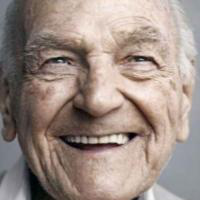

In [12]:
dataset['test']['image'][1]

In [13]:
label_age = dataset['test']['age']
label_gender = dataset['test']['gender']

In [14]:
label_gender_encode = []
for gender in label_gender:
  if gender == 'male':
    label_gender_encode.append(0)
  else:
    label_gender_encode.append(1)

In [15]:
example = dataset['test'][20]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x7FF3AF762A40>,
 'age': 10,
 'gender': 'male',
 'race': 'white',
 'image_name': '10_0_0_20170103200329407.jpg'}

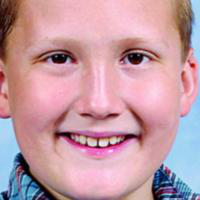

In [16]:
example['image']

In [17]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(checkpoint_path)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [18]:
from torchvision.transforms import(
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
    RandomRotation,
    ColorJitter
)

In [19]:
normalize = Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            RandomRotation(20),
            ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_test(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [20]:
# training + validation splitting
splits = dataset['test'].train_test_split(test_size = .1)
train_ds = splits['train']
test_ds = splits['test']

In [21]:
# transform train dataset and test dataset
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_test)

In [22]:
train_ds[10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x7FF367F8B6A0>,
 'age': 49,
 'gender': 'female',
 'race': 'white',
 'image_name': '49_1_0_20170109220426712.jpg',
 'pixel_values': tensor([[[-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
          ...,
          [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980]],
 
         [[-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
          [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
          [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
          ...,
          [-1.9132, -1.9132, -1.9132,  ..., -1.9132, -1.9132, -1.9132],
          [-1.9132, -1.9132, -1.9132,  .

### Training model

In [23]:
from transformers import ViTModel
vit_model = ViTModel.from_pretrained(checkpoint_path)

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTModel: ['decoder.decoder_layers.6.attention.attention.value.bias', 'decoder.decoder_layers.3.output.dense.weight', 'decoder.decoder_layers.2.intermediate.dense.weight', 'decoder.decoder_layers.0.attention.attention.value.bias', 'decoder.decoder_layers.3.attention.attention.value.weight', 'decoder.decoder_pos_embed', 'decoder.decoder_layers.1.intermediate.dense.weight', 'decoder.decoder_layers.7.attention.attention.query.bias', 'decoder.decoder_layers.3.layernorm_before.weight', 'decoder.decoder_layers.3.attention.attention.query.weight', 'decoder.decoder_norm.weight', 'decoder.decoder_layers.7.attention.attention.query.weight', 'decoder.decoder_layers.6.layernorm_before.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.2.layernorm_before.bias', 'decoder.decoder_layers.5.attention.attention.key.weight', 'decoder.decoder_layers.1.output.dense.bias', 'decoder.d

In [24]:
vit_model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [25]:
class AgeGenderClassifier(nn.Module):
  def __init__(self):
    super(AgeGenderClassifier, self).__init__()
    self.vit = vit_model
    self.gender_bn = nn.BatchNorm1d(768)
    self.gender_classifier =nn.Linear(768,2)
    self.age_bn = nn.BatchNorm1d(768)
    self.age_regressor = nn.Linear(768,1)

  def forward(self, input_ids):
    outputs = self.vit(input_ids)
    pooler_output = outputs.pooler_output
    
    gender_output = self.gender_classifier(self.gender_bn(pooler_output))
    age_output = self.age_regressor(self.age_bn(pooler_output))
    return gender_output, age_output

In [26]:
age_gender_model = AgeGenderClassifier()

In [27]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pixel_values = item['pixel_values']
        gender = 1.0 if item['gender'] == 'female' else 0.0  # encode 'female' as 1.0 and 'male' as 0.0
        age = float(item['age'])
        return pixel_values, torch.tensor(gender), torch.tensor(age)

In [28]:
train_dataset = CustomDataset(train_ds)
test_dataset = CustomDataset(test_ds)

In [29]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True, num_workers=2)

In [30]:
dataloaders = {'train': train_loader, 'test': test_loader}

In [31]:
from torch import optim
from torch.optim import lr_scheduler
import copy
model = age_gender_model

# Specify the loss functions for each head
criterion1 = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss for the gender classification
criterion2 = nn.SmoothL1Loss(reduction='mean')

# Applying weight for eahc loss
weight_gender = 0.95
weight_age = 1- weight_gender

# Specify the optimizer
optimizer = optim.Adam(model.parameters(), lr= 10e-5, weight_decay = 1e-4)

# Specify the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

# Specify the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model.to(device)

# Initialize empty lists to store loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Initialize additional lists to store MAE values
train_age_error_values = []
test_age_error_values = []

# Initialize the best model weights variable
# best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

#Dataset_sizes
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'test']}
# Number of epochs
num_epochs = 30

for epoch in range(num_epochs):
    #print('Epoch {}/{}'.format(epoch, num_epochs -1))
    print('-'*10)
    
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        correct_gender_preds = 0
        total_gender_preds = 0
        total_age_error = 0

        for inputs, gender_labels, age_labels in tqdm(dataloaders[phase], desc=f'Epoch {epoch+1}/{num_epochs} {phase.capitalize()}'):
            inputs = inputs.to(device)
            gender_labels = gender_labels.to(device).long()
            age_labels = age_labels.to(device)

            optimizer.zero_grad()
            

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                gender_preds, age_preds = model(inputs)
                # Calculate the losses for each head
                loss1 = criterion1(gender_preds, gender_labels)
                loss2 = criterion2(age_preds.view(-1), age_labels.float()) 
                # Total loss is the sum of the two losses
                loss = weight_gender*loss1 + weight_age*loss2
                print(loss)
                

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        

            # Calculate the number of correct gender predictions
            _, predicted_genders = torch.max(gender_preds, 1)
            correct_gender_preds += (predicted_genders == gender_labels).sum().item()
            total_gender_preds += gender_labels.size(0)

            # Calculate the total age prediction error
            total_age_error += torch.sum(torch.abs(age_preds.view(-1) - age_labels.float())).item()
            
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = correct_gender_preds / total_gender_preds
        epoch_age_error = total_age_error / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f} Age MAE: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_age_error))
        
        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())
            
        # Store loss and accuracy and MAE values for each epoch
        if phase == 'train':
            train_loss_values.append(epoch_loss)
            train_acc_values.append(epoch_acc)
            train_age_error_values.append(epoch_age_error)
        else:
            test_loss_values.append(epoch_loss)
            test_acc_values.append(epoch_acc)
            test_age_error_values.append(epoch_age_error)
            
    # # Save model after each epoch for future training if needed
    # torch.save(model.state_dict(),f'/content/drive/MyDrive/Age and Gender Prediction/model_checkpoints{epoch+1}.pt')
    # print('State dict saved')

print('Best test Acc: {:4f}'.format(best_acc))

# # Load best model weights
# model.load_state_dict(best_model_wts)

----------


Epoch 1/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(2.0679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   0%|          | 1/334 [00:09<52:25,  9.45s/it]

tensor(2.9834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 2/334 [00:09<23:03,  4.17s/it]

tensor(2.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 3/334 [00:10<13:40,  2.48s/it]

tensor(2.2354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 4/334 [00:10<09:15,  1.68s/it]

tensor(2.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|▏         | 5/334 [00:11<06:49,  1.24s/it]

tensor(2.2520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 6/334 [00:11<05:21,  1.02it/s]

tensor(2.3115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 7/334 [00:12<04:25,  1.23it/s]

tensor(2.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 8/334 [00:12<03:49,  1.42it/s]

tensor(2.3265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 9/334 [00:13<03:24,  1.59it/s]

tensor(2.3534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 10/334 [00:13<03:07,  1.73it/s]

tensor(2.2450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 11/334 [00:14<02:56,  1.83it/s]

tensor(2.3212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▎         | 12/334 [00:14<02:47,  1.92it/s]

tensor(2.3161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 13/334 [00:15<02:42,  1.98it/s]

tensor(2.1927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 14/334 [00:15<02:37,  2.03it/s]

tensor(2.1794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 15/334 [00:15<02:35,  2.05it/s]

tensor(2.1768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▍         | 16/334 [00:16<02:33,  2.08it/s]

tensor(2.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▌         | 17/334 [00:16<02:31,  2.09it/s]

tensor(2.2901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▌         | 18/334 [00:17<02:29,  2.11it/s]

tensor(2.3253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▌         | 19/334 [00:17<02:28,  2.12it/s]

tensor(2.1762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▌         | 20/334 [00:18<02:27,  2.12it/s]

tensor(2.0825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▋         | 21/334 [00:18<02:27,  2.13it/s]

tensor(2.1621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 22/334 [00:19<02:26,  2.13it/s]

tensor(2.3346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 23/334 [00:19<02:26,  2.12it/s]

tensor(2.1788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 24/334 [00:20<02:25,  2.13it/s]

tensor(2.2626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 25/334 [00:20<02:25,  2.12it/s]

tensor(2.2585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 26/334 [00:21<02:24,  2.13it/s]

tensor(2.2531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 27/334 [00:21<02:24,  2.13it/s]

tensor(2.2458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 28/334 [00:22<02:23,  2.13it/s]

tensor(2.2184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▊         | 29/334 [00:22<02:23,  2.13it/s]

tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▉         | 30/334 [00:23<02:22,  2.13it/s]

tensor(2.3731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▉         | 31/334 [00:23<02:22,  2.13it/s]

tensor(2.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|▉         | 32/334 [00:23<02:21,  2.13it/s]

tensor(2.3034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|▉         | 33/334 [00:24<02:21,  2.13it/s]

tensor(2.2179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|█         | 34/334 [00:24<02:20,  2.14it/s]

tensor(2.3370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|█         | 35/334 [00:25<02:20,  2.13it/s]

tensor(2.2353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█         | 36/334 [00:25<02:19,  2.13it/s]

tensor(2.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█         | 37/334 [00:26<02:19,  2.14it/s]

tensor(1.9212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█▏        | 38/334 [00:26<02:18,  2.14it/s]

tensor(2.2796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 39/334 [00:27<02:18,  2.14it/s]

tensor(2.3160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 40/334 [00:27<02:17,  2.14it/s]

tensor(2.1354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 41/334 [00:28<02:17,  2.14it/s]

tensor(1.9748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 42/334 [00:28<02:16,  2.14it/s]

tensor(2.1661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 43/334 [00:29<02:16,  2.14it/s]

tensor(2.2383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 44/334 [00:29<02:15,  2.14it/s]

tensor(2.3787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 45/334 [00:30<02:15,  2.14it/s]

tensor(2.2447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 46/334 [00:30<02:14,  2.14it/s]

tensor(2.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 47/334 [00:30<02:14,  2.14it/s]

tensor(2.2982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 48/334 [00:31<02:13,  2.14it/s]

tensor(2.2644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▍        | 49/334 [00:31<02:13,  2.14it/s]

tensor(2.0834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▍        | 50/334 [00:32<02:12,  2.14it/s]

tensor(2.1752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▌        | 51/334 [00:32<02:12,  2.14it/s]

tensor(2.1992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 52/334 [00:33<02:11,  2.14it/s]

tensor(2.1843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 53/334 [00:33<02:11,  2.14it/s]

tensor(2.0958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 54/334 [00:34<02:11,  2.14it/s]

tensor(2.3436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▋        | 55/334 [00:34<02:10,  2.13it/s]

tensor(2.2359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 56/334 [00:35<02:10,  2.13it/s]

tensor(2.2455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 57/334 [00:35<02:09,  2.14it/s]

tensor(2.0716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 58/334 [00:36<02:09,  2.14it/s]

tensor(2.1095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 59/334 [00:36<02:08,  2.14it/s]

tensor(2.2371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 60/334 [00:37<02:08,  2.14it/s]

tensor(2.3728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 61/334 [00:37<02:07,  2.14it/s]

tensor(2.1500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▊        | 62/334 [00:38<02:07,  2.14it/s]

tensor(2.3628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 63/334 [00:38<02:06,  2.14it/s]

tensor(2.2398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 64/334 [00:38<02:06,  2.14it/s]

tensor(2.1063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 65/334 [00:39<02:05,  2.14it/s]

tensor(2.2056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|█▉        | 66/334 [00:39<02:05,  2.14it/s]

tensor(2.1344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|██        | 67/334 [00:40<02:04,  2.14it/s]

tensor(2.2738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|██        | 68/334 [00:40<02:04,  2.14it/s]

tensor(2.2194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██        | 69/334 [00:41<02:03,  2.14it/s]

tensor(2.2062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██        | 70/334 [00:41<02:03,  2.14it/s]

tensor(2.2351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██▏       | 71/334 [00:42<02:03,  2.13it/s]

tensor(2.3164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 72/334 [00:42<02:02,  2.13it/s]

tensor(2.1564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 73/334 [00:43<02:02,  2.13it/s]

tensor(2.3168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 74/334 [00:43<02:01,  2.13it/s]

tensor(2.2774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 75/334 [00:44<02:01,  2.13it/s]

tensor(2.2473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 76/334 [00:44<02:00,  2.14it/s]

tensor(2.1460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 77/334 [00:45<02:00,  2.13it/s]

tensor(2.0670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 78/334 [00:45<01:59,  2.14it/s]

tensor(1.9947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▎       | 79/334 [00:45<01:59,  2.13it/s]

tensor(2.2950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▍       | 80/334 [00:46<01:59,  2.13it/s]

tensor(2.1813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▍       | 81/334 [00:46<01:58,  2.13it/s]

tensor(2.1314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▍       | 82/334 [00:47<01:58,  2.13it/s]

tensor(2.1257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▍       | 83/334 [00:47<01:57,  2.13it/s]

tensor(2.1066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▌       | 84/334 [00:48<01:57,  2.13it/s]

tensor(2.3766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▌       | 85/334 [00:48<01:56,  2.13it/s]

tensor(1.9005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▌       | 86/334 [00:49<01:56,  2.13it/s]

tensor(2.1835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▌       | 87/334 [00:49<01:56,  2.13it/s]

tensor(2.2217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▋       | 88/334 [00:50<01:55,  2.13it/s]

tensor(2.2416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 89/334 [00:50<01:54,  2.13it/s]

tensor(2.0817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 90/334 [00:51<01:54,  2.13it/s]

tensor(2.0919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 91/334 [00:51<01:53,  2.13it/s]

tensor(2.0378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 92/334 [00:52<01:53,  2.13it/s]

tensor(2.1204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 93/334 [00:52<01:52,  2.13it/s]

tensor(2.2234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 94/334 [00:53<01:52,  2.13it/s]

tensor(1.8923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 95/334 [00:53<01:51,  2.14it/s]

tensor(2.2014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▊       | 96/334 [00:53<01:51,  2.14it/s]

tensor(1.8460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▉       | 97/334 [00:54<01:50,  2.14it/s]

tensor(1.9820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▉       | 98/334 [00:54<01:50,  2.13it/s]

tensor(2.0490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|██▉       | 99/334 [00:55<01:50,  2.13it/s]

tensor(2.2061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|██▉       | 100/334 [00:55<01:49,  2.13it/s]

tensor(2.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|███       | 101/334 [00:56<01:49,  2.13it/s]

tensor(2.0491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 102/334 [00:56<01:48,  2.13it/s]

tensor(1.9717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 103/334 [00:57<01:48,  2.13it/s]

tensor(2.1383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 104/334 [00:57<01:47,  2.13it/s]

tensor(1.9344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███▏      | 105/334 [00:58<01:47,  2.13it/s]

tensor(1.9463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 106/334 [00:58<01:46,  2.13it/s]

tensor(1.8815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 107/334 [00:59<01:46,  2.14it/s]

tensor(2.1924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 108/334 [00:59<01:45,  2.14it/s]

tensor(2.2323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 109/334 [01:00<01:45,  2.14it/s]

tensor(2.1356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 110/334 [01:00<01:44,  2.14it/s]

tensor(1.9907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 111/334 [01:00<01:44,  2.14it/s]

tensor(2.0716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▎      | 112/334 [01:01<01:43,  2.14it/s]

tensor(2.2037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 113/334 [01:01<01:43,  2.14it/s]

tensor(2.0406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 114/334 [01:02<01:43,  2.13it/s]

tensor(2.3504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 115/334 [01:02<01:42,  2.13it/s]

tensor(1.9698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▍      | 116/334 [01:03<01:42,  2.13it/s]

tensor(2.2096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▌      | 117/334 [01:03<01:42,  2.12it/s]

tensor(2.2860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▌      | 118/334 [01:04<01:41,  2.13it/s]

tensor(2.1034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 119/334 [01:04<01:40,  2.13it/s]

tensor(2.0924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 120/334 [01:05<01:40,  2.13it/s]

tensor(2.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 121/334 [01:05<01:39,  2.13it/s]

tensor(2.2357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 122/334 [01:06<01:39,  2.14it/s]

tensor(2.0330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 123/334 [01:06<01:38,  2.14it/s]

tensor(2.1152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 124/334 [01:07<01:38,  2.13it/s]

tensor(2.2011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 125/334 [01:07<01:37,  2.13it/s]

tensor(2.0277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 126/334 [01:08<01:37,  2.13it/s]

tensor(2.1459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 127/334 [01:08<01:36,  2.13it/s]

tensor(2.1426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 128/334 [01:08<01:36,  2.13it/s]

tensor(2.3159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▊      | 129/334 [01:09<01:35,  2.14it/s]

tensor(2.1056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▉      | 130/334 [01:09<01:35,  2.13it/s]

tensor(2.0673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▉      | 131/334 [01:10<01:35,  2.14it/s]

tensor(2.2250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|███▉      | 132/334 [01:10<01:34,  2.14it/s]

tensor(2.1931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|███▉      | 133/334 [01:11<01:34,  2.14it/s]

tensor(2.3596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|████      | 134/334 [01:11<01:33,  2.14it/s]

tensor(1.8500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|████      | 135/334 [01:12<01:33,  2.14it/s]

tensor(2.0357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████      | 136/334 [01:12<01:32,  2.14it/s]

tensor(2.1080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████      | 137/334 [01:13<01:32,  2.14it/s]

tensor(2.1541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████▏     | 138/334 [01:13<01:31,  2.14it/s]

tensor(2.1486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 139/334 [01:14<01:31,  2.13it/s]

tensor(1.9610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 140/334 [01:14<01:30,  2.13it/s]

tensor(2.3013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 141/334 [01:15<01:30,  2.13it/s]

tensor(1.9508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 142/334 [01:15<01:29,  2.13it/s]

tensor(1.9781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 143/334 [01:15<01:29,  2.13it/s]

tensor(2.0270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 144/334 [01:16<01:29,  2.13it/s]

tensor(2.0897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 145/334 [01:16<01:28,  2.13it/s]

tensor(2.1400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▎     | 146/334 [01:17<01:28,  2.13it/s]

tensor(1.9191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▍     | 147/334 [01:17<01:27,  2.13it/s]

tensor(2.1895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▍     | 148/334 [01:18<01:27,  2.13it/s]

tensor(2.1442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▍     | 149/334 [01:18<01:27,  2.13it/s]

tensor(2.2032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▍     | 150/334 [01:19<01:26,  2.13it/s]

tensor(2.0058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▌     | 151/334 [01:19<01:25,  2.13it/s]

tensor(2.2627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 152/334 [01:20<01:25,  2.13it/s]

tensor(1.9776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 153/334 [01:20<01:24,  2.13it/s]

tensor(2.1947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 154/334 [01:21<01:24,  2.13it/s]

tensor(2.1951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▋     | 155/334 [01:21<01:24,  2.13it/s]

tensor(2.0605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 156/334 [01:22<01:23,  2.13it/s]

tensor(2.0794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 157/334 [01:22<01:23,  2.13it/s]

tensor(2.1728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 158/334 [01:23<01:22,  2.13it/s]

tensor(2.0692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 159/334 [01:23<01:21,  2.13it/s]

tensor(2.1169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 160/334 [01:23<01:21,  2.13it/s]

tensor(2.0511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 161/334 [01:24<01:21,  2.13it/s]

tensor(2.0006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▊     | 162/334 [01:24<01:20,  2.13it/s]

tensor(1.7722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 163/334 [01:25<01:20,  2.13it/s]

tensor(2.2508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 164/334 [01:25<01:19,  2.13it/s]

tensor(2.0729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 165/334 [01:26<01:19,  2.13it/s]

tensor(2.1626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|████▉     | 166/334 [01:26<01:19,  2.13it/s]

tensor(2.0357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|█████     | 167/334 [01:27<01:18,  2.13it/s]

tensor(2.1199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|█████     | 168/334 [01:27<01:18,  2.13it/s]

tensor(2.0801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 169/334 [01:28<01:17,  2.13it/s]

tensor(2.0544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 170/334 [01:28<01:17,  2.13it/s]

tensor(2.2999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 171/334 [01:29<01:16,  2.13it/s]

tensor(2.2711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████▏    | 172/334 [01:29<01:16,  2.13it/s]

tensor(1.8990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 173/334 [01:30<01:15,  2.13it/s]

tensor(1.9549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 174/334 [01:30<01:15,  2.13it/s]

tensor(2.0174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 175/334 [01:30<01:14,  2.13it/s]

tensor(2.0732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 176/334 [01:31<01:14,  2.13it/s]

tensor(1.8883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 177/334 [01:31<01:13,  2.13it/s]

tensor(1.8932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 178/334 [01:32<01:13,  2.13it/s]

tensor(2.0049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▎    | 179/334 [01:32<01:12,  2.13it/s]

tensor(1.8732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 180/334 [01:33<01:12,  2.13it/s]

tensor(1.9568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 181/334 [01:33<01:11,  2.13it/s]

tensor(2.0674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 182/334 [01:34<01:11,  2.13it/s]

tensor(2.2219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▍    | 183/334 [01:34<01:10,  2.13it/s]

tensor(2.1519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▌    | 184/334 [01:35<01:10,  2.13it/s]

tensor(1.9179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▌    | 185/334 [01:35<01:09,  2.13it/s]

tensor(2.2218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▌    | 186/334 [01:36<01:09,  2.13it/s]

tensor(2.0232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▌    | 187/334 [01:36<01:08,  2.13it/s]

tensor(2.0032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▋    | 188/334 [01:37<01:08,  2.13it/s]

tensor(1.8338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 189/334 [01:37<01:07,  2.13it/s]

tensor(2.3213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 190/334 [01:38<01:07,  2.13it/s]

tensor(1.9697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 191/334 [01:38<01:07,  2.13it/s]

tensor(2.3082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 192/334 [01:38<01:06,  2.13it/s]

tensor(2.2225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 193/334 [01:39<01:06,  2.13it/s]

tensor(1.9663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 194/334 [01:39<01:05,  2.13it/s]

tensor(1.7603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 195/334 [01:40<01:05,  2.13it/s]

tensor(2.0383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▊    | 196/334 [01:40<01:04,  2.13it/s]

tensor(1.9472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▉    | 197/334 [01:41<01:04,  2.13it/s]

tensor(1.9815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▉    | 198/334 [01:41<01:03,  2.13it/s]

tensor(2.0598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|█████▉    | 199/334 [01:42<01:03,  2.13it/s]

tensor(2.1005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|█████▉    | 200/334 [01:42<01:02,  2.13it/s]

tensor(1.8693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|██████    | 201/334 [01:43<01:02,  2.13it/s]

tensor(2.0788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|██████    | 202/334 [01:43<01:01,  2.13it/s]

tensor(1.9029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████    | 203/334 [01:44<01:01,  2.12it/s]

tensor(1.8106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████    | 204/334 [01:44<01:01,  2.13it/s]

tensor(1.9654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████▏   | 205/334 [01:45<01:00,  2.13it/s]

tensor(2.0168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 206/334 [01:45<01:00,  2.13it/s]

tensor(1.9517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 207/334 [01:46<00:59,  2.13it/s]

tensor(1.9416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 208/334 [01:46<00:59,  2.13it/s]

tensor(1.9044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 209/334 [01:46<00:58,  2.13it/s]

tensor(2.3774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 210/334 [01:47<00:58,  2.13it/s]

tensor(2.0276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 211/334 [01:47<00:57,  2.13it/s]

tensor(2.0547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 212/334 [01:48<00:57,  2.13it/s]

tensor(1.9623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 213/334 [01:48<00:56,  2.13it/s]

tensor(2.1392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 214/334 [01:49<00:56,  2.13it/s]

tensor(2.0252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 215/334 [01:49<00:55,  2.13it/s]

tensor(2.0805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▍   | 216/334 [01:50<00:55,  2.13it/s]

tensor(1.9191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▍   | 217/334 [01:50<00:54,  2.13it/s]

tensor(2.2078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▌   | 218/334 [01:51<00:54,  2.13it/s]

tensor(2.3675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 219/334 [01:51<00:53,  2.13it/s]

tensor(1.9768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 220/334 [01:52<00:53,  2.13it/s]

tensor(1.9392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 221/334 [01:52<00:52,  2.13it/s]

tensor(1.9979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▋   | 222/334 [01:53<00:52,  2.13it/s]

tensor(2.2875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 223/334 [01:53<00:52,  2.13it/s]

tensor(1.9195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 224/334 [01:53<00:51,  2.13it/s]

tensor(2.1100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 225/334 [01:54<00:51,  2.13it/s]

tensor(2.0047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 226/334 [01:54<00:50,  2.13it/s]

tensor(1.7513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 227/334 [01:55<00:50,  2.13it/s]

tensor(1.9971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 228/334 [01:55<00:49,  2.13it/s]

tensor(1.9189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▊   | 229/334 [01:56<00:49,  2.13it/s]

tensor(2.0942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 230/334 [01:56<00:48,  2.13it/s]

tensor(1.9401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 231/334 [01:57<00:48,  2.12it/s]

tensor(1.9955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 232/334 [01:57<00:47,  2.13it/s]

tensor(1.8224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|██████▉   | 233/334 [01:58<00:47,  2.13it/s]

tensor(1.9386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|███████   | 234/334 [01:58<00:46,  2.13it/s]

tensor(2.0079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|███████   | 235/334 [01:59<00:46,  2.13it/s]

tensor(2.0029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████   | 236/334 [01:59<00:46,  2.13it/s]

tensor(1.9823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████   | 237/334 [02:00<00:45,  2.13it/s]

tensor(1.8854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████▏  | 238/334 [02:00<00:45,  2.13it/s]

tensor(1.9203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 239/334 [02:01<00:44,  2.13it/s]

tensor(1.7530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 240/334 [02:01<00:44,  2.13it/s]

tensor(1.8018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 241/334 [02:01<00:43,  2.13it/s]

tensor(2.0039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 242/334 [02:02<00:43,  2.13it/s]

tensor(2.2256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 243/334 [02:02<00:42,  2.13it/s]

tensor(2.2725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 244/334 [02:03<00:42,  2.13it/s]

tensor(1.8725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 245/334 [02:03<00:41,  2.13it/s]

tensor(1.9503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▎  | 246/334 [02:04<00:41,  2.13it/s]

tensor(2.0439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▍  | 247/334 [02:04<00:40,  2.13it/s]

tensor(1.8806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▍  | 248/334 [02:05<00:40,  2.13it/s]

tensor(2.0844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▍  | 249/334 [02:05<00:39,  2.13it/s]

tensor(2.0219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▍  | 250/334 [02:06<00:39,  2.12it/s]

tensor(2.3134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▌  | 251/334 [02:06<00:39,  2.13it/s]

tensor(2.1555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▌  | 252/334 [02:07<00:38,  2.13it/s]

tensor(2.0614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▌  | 253/334 [02:07<00:38,  2.13it/s]

tensor(1.9511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▌  | 254/334 [02:08<00:37,  2.12it/s]

tensor(1.9310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▋  | 255/334 [02:08<00:37,  2.13it/s]

tensor(2.0551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 256/334 [02:09<00:36,  2.13it/s]

tensor(2.1126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 257/334 [02:09<00:36,  2.13it/s]

tensor(2.1421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 258/334 [02:09<00:35,  2.12it/s]

tensor(1.8898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 259/334 [02:10<00:35,  2.12it/s]

tensor(2.1835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 260/334 [02:10<00:34,  2.12it/s]

tensor(2.0039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 261/334 [02:11<00:34,  2.13it/s]

tensor(1.8717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 262/334 [02:11<00:33,  2.13it/s]

tensor(2.0674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▊  | 263/334 [02:12<00:33,  2.13it/s]

tensor(2.0646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▉  | 264/334 [02:12<00:32,  2.12it/s]

tensor(1.9875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▉  | 265/334 [02:13<00:32,  2.13it/s]

tensor(2.0151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|███████▉  | 266/334 [02:13<00:32,  2.12it/s]

tensor(1.8855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|███████▉  | 267/334 [02:14<00:31,  2.13it/s]

tensor(1.9612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|████████  | 268/334 [02:14<00:31,  2.13it/s]

tensor(1.7592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 269/334 [02:15<00:30,  2.13it/s]

tensor(2.1897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 270/334 [02:15<00:30,  2.13it/s]

tensor(1.9996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 271/334 [02:16<00:29,  2.13it/s]

tensor(1.8241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████▏ | 272/334 [02:16<00:29,  2.13it/s]

tensor(1.9149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 273/334 [02:17<00:28,  2.13it/s]

tensor(1.9644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 274/334 [02:17<00:28,  2.13it/s]

tensor(1.8715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 275/334 [02:17<00:27,  2.12it/s]

tensor(1.6790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 276/334 [02:18<00:27,  2.12it/s]

tensor(2.0066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 277/334 [02:18<00:26,  2.13it/s]

tensor(1.8901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 278/334 [02:19<00:26,  2.13it/s]

tensor(1.8756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▎ | 279/334 [02:19<00:25,  2.13it/s]

tensor(2.2168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 280/334 [02:20<00:25,  2.13it/s]

tensor(1.8404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 281/334 [02:20<00:24,  2.13it/s]

tensor(1.7571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 282/334 [02:21<00:24,  2.13it/s]

tensor(2.2402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▍ | 283/334 [02:21<00:23,  2.13it/s]

tensor(2.1137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▌ | 284/334 [02:22<00:23,  2.13it/s]

tensor(2.0173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▌ | 285/334 [02:22<00:22,  2.13it/s]

tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 286/334 [02:23<00:22,  2.13it/s]

tensor(1.9348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 287/334 [02:23<00:22,  2.13it/s]

tensor(1.9105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 288/334 [02:24<00:21,  2.13it/s]

tensor(1.9538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 289/334 [02:24<00:21,  2.13it/s]

tensor(1.9733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 290/334 [02:24<00:20,  2.12it/s]

tensor(1.8614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 291/334 [02:25<00:20,  2.13it/s]

tensor(2.0577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 292/334 [02:25<00:19,  2.13it/s]

tensor(2.0039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 293/334 [02:26<00:19,  2.13it/s]

tensor(1.9740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 294/334 [02:26<00:18,  2.13it/s]

tensor(1.9207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 295/334 [02:27<00:18,  2.13it/s]

tensor(1.8387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▊ | 296/334 [02:27<00:17,  2.13it/s]

tensor(2.0832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▉ | 297/334 [02:28<00:17,  2.13it/s]

tensor(1.9263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▉ | 298/334 [02:28<00:16,  2.13it/s]

tensor(2.0464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|████████▉ | 299/334 [02:29<00:16,  2.12it/s]

tensor(2.0180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|████████▉ | 300/334 [02:29<00:15,  2.13it/s]

tensor(1.9175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|█████████ | 301/334 [02:30<00:15,  2.13it/s]

tensor(2.0393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|█████████ | 302/334 [02:30<00:15,  2.13it/s]

tensor(2.0347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████ | 303/334 [02:31<00:14,  2.13it/s]

tensor(1.6842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████ | 304/334 [02:31<00:14,  2.13it/s]

tensor(2.0471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████▏| 305/334 [02:32<00:13,  2.13it/s]

tensor(1.7699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 306/334 [02:32<00:13,  2.13it/s]

tensor(1.7511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 307/334 [02:32<00:12,  2.13it/s]

tensor(1.8670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 308/334 [02:33<00:12,  2.13it/s]

tensor(1.9829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 309/334 [02:33<00:11,  2.13it/s]

tensor(1.9388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 310/334 [02:34<00:11,  2.13it/s]

tensor(1.6897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 311/334 [02:34<00:10,  2.13it/s]

tensor(1.9420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 312/334 [02:35<00:10,  2.13it/s]

tensor(2.0041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▎| 313/334 [02:35<00:09,  2.13it/s]

tensor(1.7866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▍| 314/334 [02:36<00:09,  2.13it/s]

tensor(1.9596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▍| 315/334 [02:36<00:08,  2.12it/s]

tensor(2.1459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▍| 316/334 [02:37<00:08,  2.13it/s]

tensor(2.0758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▍| 317/334 [02:37<00:07,  2.13it/s]

tensor(1.8889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▌| 318/334 [02:38<00:07,  2.13it/s]

tensor(1.9843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 319/334 [02:38<00:07,  2.13it/s]

tensor(2.0322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 320/334 [02:39<00:06,  2.13it/s]

tensor(1.7433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 321/334 [02:39<00:06,  2.13it/s]

tensor(1.7769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▋| 322/334 [02:40<00:05,  2.13it/s]

tensor(1.9417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 323/334 [02:40<00:05,  2.13it/s]

tensor(1.8625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 324/334 [02:40<00:04,  2.13it/s]

tensor(1.7670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 325/334 [02:41<00:04,  2.13it/s]

tensor(2.1917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 326/334 [02:41<00:03,  2.13it/s]

tensor(1.8204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 327/334 [02:42<00:03,  2.13it/s]

tensor(2.0175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 328/334 [02:42<00:02,  2.13it/s]

tensor(1.8575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▊| 329/334 [02:43<00:02,  2.13it/s]

tensor(1.9744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 330/334 [02:43<00:01,  2.13it/s]

tensor(1.8714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 331/334 [02:44<00:01,  2.13it/s]

tensor(2.0033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 332/334 [02:44<00:00,  2.13it/s]

tensor(1.8342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train: 100%|██████████| 334/334 [02:45<00:00,  2.64it/s]

tensor(2.0251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train: 100%|██████████| 334/334 [02:45<00:00,  2.02it/s]


train Loss: 2.0839 Acc: 0.7458 Age MAE: 32.6896


Epoch 1/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.23it/s]

tensor(1.7891, device='cuda:0')
tensor(1.8819, device='cuda:0')


Epoch 1/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.68it/s]

tensor(1.6837, device='cuda:0')
tensor(1.6921, device='cuda:0')


Epoch 1/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.40it/s]

tensor(1.9078, device='cuda:0')
tensor(2.1486, device='cuda:0')


Epoch 1/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.76it/s]

tensor(1.9180, device='cuda:0')
tensor(1.7197, device='cuda:0')


Epoch 1/30 Test:  26%|██▋       | 10/38 [00:01<00:04,  5.97it/s]

tensor(1.5535, device='cuda:0')
tensor(1.8020, device='cuda:0')


Epoch 1/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  6.01it/s]

tensor(1.7750, device='cuda:0')
tensor(2.0036, device='cuda:0')


Epoch 1/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.03it/s]

tensor(2.0996, device='cuda:0')
tensor(1.9876, device='cuda:0')


Epoch 1/30 Test:  42%|████▏     | 16/38 [00:02<00:03,  6.06it/s]

tensor(1.7271, device='cuda:0')
tensor(1.8844, device='cuda:0')


Epoch 1/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.07it/s]

tensor(1.9044, device='cuda:0')
tensor(1.7310, device='cuda:0')


Epoch 1/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.14it/s]

tensor(1.8632, device='cuda:0')
tensor(1.9406, device='cuda:0')


Epoch 1/30 Test:  58%|█████▊    | 22/38 [00:03<00:02,  6.10it/s]

tensor(1.8199, device='cuda:0')
tensor(1.7214, device='cuda:0')


Epoch 1/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.09it/s]

tensor(1.9559, device='cuda:0')
tensor(1.9458, device='cuda:0')


Epoch 1/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.08it/s]

tensor(1.9589, device='cuda:0')
tensor(1.9574, device='cuda:0')


Epoch 1/30 Test:  74%|███████▎  | 28/38 [00:04<00:01,  6.08it/s]

tensor(1.6873, device='cuda:0')
tensor(1.8899, device='cuda:0')


Epoch 1/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.06it/s]

tensor(1.7986, device='cuda:0')
tensor(1.8687, device='cuda:0')


Epoch 1/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.12it/s]

tensor(1.6000, device='cuda:0')
tensor(1.7637, device='cuda:0')


Epoch 1/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  6.10it/s]

tensor(1.7964, device='cuda:0')
tensor(1.6525, device='cuda:0')


Epoch 1/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.16it/s]

tensor(1.8649, device='cuda:0')
tensor(1.7767, device='cuda:0')


Epoch 1/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.83it/s]


tensor(1.8380, device='cuda:0')
tensor(1.2792, device='cuda:0')
test Loss: 1.8347 Acc: 0.8397 Age MAE: 29.6733
----------


Epoch 2/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(2.0959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   0%|          | 1/334 [00:01<06:34,  1.18s/it]

tensor(1.9511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 2/334 [00:01<04:13,  1.31it/s]

tensor(2.0123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 3/334 [00:02<03:28,  1.59it/s]

tensor(2.2006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(1.6943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|▏         | 5/334 [00:03<02:54,  1.88it/s]

tensor(1.7827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(1.8940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(1.9627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 8/334 [00:04<02:38,  2.05it/s]

tensor(2.0255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(1.8806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 10/334 [00:05<02:34,  2.09it/s]

tensor(1.9989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(2.1827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(2.3739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(1.7723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(1.9393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.13it/s]

tensor(1.6904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.13it/s]

tensor(2.0132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▌         | 17/334 [00:08<02:28,  2.13it/s]

tensor(1.8454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(1.8790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▌         | 19/334 [00:09<02:27,  2.13it/s]

tensor(1.9144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(1.8196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(1.8536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(1.8634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 23/334 [00:11<02:25,  2.13it/s]

tensor(1.7356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 24/334 [00:11<02:25,  2.13it/s]

tensor(1.8884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(1.9155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(2.0119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(1.6191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(1.7881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(1.9355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(1.7754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(2.0208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(1.9072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(1.8759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(2.0182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(1.8108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(1.8554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(1.8169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(1.9192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(1.9202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 40/334 [00:19<02:17,  2.13it/s]

tensor(1.9707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(1.8642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 42/334 [00:20<02:16,  2.13it/s]

tensor(1.9688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(1.9446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 44/334 [00:21<02:15,  2.13it/s]

tensor(1.9329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(2.0964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(2.0074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(1.9356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(1.7988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(1.8986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(1.9442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(1.7803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(1.8687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(1.7883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(1.8603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▋        | 55/334 [00:26<02:10,  2.13it/s]

tensor(1.9246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 56/334 [00:26<02:10,  2.13it/s]

tensor(1.7621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(1.8956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(2.1567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(1.8853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(1.9499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(2.0654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(2.0772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(2.0007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(2.0904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(2.0471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(2.2027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(1.6957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.14it/s]

tensor(1.7217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(1.7324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(1.8889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(1.5746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(1.7779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 73/334 [00:34<02:02,  2.14it/s]

tensor(2.2548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 74/334 [00:35<02:01,  2.14it/s]

tensor(1.7701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(2.1944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 76/334 [00:36<02:00,  2.13it/s]

tensor(1.9358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(1.9811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 78/334 [00:37<01:59,  2.14it/s]

tensor(1.8995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(1.7130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▍       | 80/334 [00:38<01:58,  2.13it/s]

tensor(1.7868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(1.6704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(1.8292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.14it/s]

tensor(1.8923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(1.7487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.14it/s]

tensor(2.0011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(1.8637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(1.7634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▋       | 88/334 [00:41<01:55,  2.13it/s]

tensor(1.8451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 89/334 [00:42<01:54,  2.13it/s]

tensor(1.8540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 90/334 [00:42<01:54,  2.13it/s]

tensor(1.8151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 91/334 [00:43<01:53,  2.13it/s]

tensor(1.8922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(1.7445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(1.7383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(1.9297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(1.9322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(1.9858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(1.8672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(2.1115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(1.6613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(1.7331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(1.9749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(1.7686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(1.9060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 104/334 [00:49<01:47,  2.13it/s]

tensor(1.7640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███▏      | 105/334 [00:49<01:47,  2.13it/s]

tensor(1.6972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(1.7719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 107/334 [00:50<01:46,  2.13it/s]

tensor(1.9374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(2.0034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(1.9576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(1.8316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(1.8706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(1.7825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(1.8231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(1.7922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(2.1397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(1.8335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(1.5447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(1.8082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.13it/s]

tensor(1.8428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(1.9441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(1.9992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 122/334 [00:57<01:39,  2.13it/s]

tensor(1.7258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(1.7635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 124/334 [00:58<01:38,  2.13it/s]

tensor(1.7299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(1.8291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(1.6676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(1.7610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(1.7612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(1.7512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(2.0997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(1.6481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(1.7259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(1.9352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(1.8973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(1.8594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(1.7421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████▏     | 138/334 [01:05<01:31,  2.13it/s]

tensor(1.9935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 139/334 [01:05<01:31,  2.13it/s]

tensor(1.8653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 140/334 [01:06<01:30,  2.13it/s]

tensor(1.7131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 141/334 [01:06<01:30,  2.13it/s]

tensor(1.6947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(1.8628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(1.7808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(1.7684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(1.7033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(1.9737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(1.7658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(1.8969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(1.7607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(1.6695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(1.8563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(1.7328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.12it/s]

tensor(1.7305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 154/334 [01:12<01:24,  2.13it/s]

tensor(1.7017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(1.7007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 156/334 [01:13<01:23,  2.13it/s]

tensor(1.8166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(2.0647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 158/334 [01:14<01:22,  2.13it/s]

tensor(1.6999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(1.7720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(1.9061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(1.7065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(1.9566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(1.9288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(1.8313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(1.7529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.13it/s]

tensor(1.3712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(1.7521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(1.7618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(1.7024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(1.8326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 171/334 [01:20<01:16,  2.13it/s]

tensor(2.0978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(1.6327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 173/334 [01:21<01:15,  2.13it/s]

tensor(1.9050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(1.7751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 175/334 [01:22<01:14,  2.13it/s]

tensor(1.7378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(1.7202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(1.6394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(1.7781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(1.9576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(1.8665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(1.9618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(1.7324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(1.9652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(1.7800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(1.9162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(1.9309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▌    | 187/334 [01:28<01:11,  2.06it/s]

tensor(1.8323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▋    | 188/334 [01:29<01:10,  2.08it/s]

tensor(2.0120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 189/334 [01:29<01:09,  2.09it/s]

tensor(1.7974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 190/334 [01:29<01:08,  2.10it/s]

tensor(1.7314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 191/334 [01:30<01:08,  2.10it/s]

tensor(1.7777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 192/334 [01:30<01:07,  2.11it/s]

tensor(1.7924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(1.9088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 194/334 [01:31<01:06,  2.11it/s]

tensor(1.8415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(1.6184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.12it/s]

tensor(1.6183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(1.6025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(1.9935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(1.9239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(1.6674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(1.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|██████    | 202/334 [01:35<01:01,  2.13it/s]

tensor(2.0084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(1.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(1.8755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(1.7634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(1.8207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 207/334 [01:37<00:59,  2.13it/s]

tensor(1.6903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(1.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 209/334 [01:38<00:58,  2.12it/s]

tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(1.7760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(1.7990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(1.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.12it/s]

tensor(1.8150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(1.7531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(1.7240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(1.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.13it/s]

tensor(1.6764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(1.9125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(1.8132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(1.7385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(1.2787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(1.9320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(1.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 224/334 [01:45<00:51,  2.12it/s]

tensor(1.9486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(1.8580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 226/334 [01:46<00:50,  2.13it/s]

tensor(1.8278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(1.6846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(1.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(1.7342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(1.8436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(1.7062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(1.6739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(1.6828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(1.5956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(1.6177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(1.6338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(1.8592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(1.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(1.7897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(1.8233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 241/334 [01:53<00:43,  2.12it/s]

tensor(2.0162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(1.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 243/334 [01:54<00:42,  2.12it/s]

tensor(1.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(1.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.13it/s]

tensor(1.7160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(1.6575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.12it/s]

tensor(1.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(1.6935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(1.7048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(1.6388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(1.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(1.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(1.6728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(1.5772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(1.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 256/334 [02:00<00:36,  2.13it/s]

tensor(1.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(1.7078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 258/334 [02:01<00:35,  2.13it/s]

tensor(1.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(1.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 260/334 [02:02<00:34,  2.13it/s]

tensor(1.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(1.6885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(1.7901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(1.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(1.3466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(1.8432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(1.6132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(1.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(1.6688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(1.5943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(1.6813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(1.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(1.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 273/334 [02:08<00:28,  2.13it/s]

tensor(1.6176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(1.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 275/334 [02:09<00:27,  2.13it/s]

tensor(1.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(1.7013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 277/334 [02:10<00:26,  2.12it/s]

tensor(1.6661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(1.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.12it/s]

tensor(1.8019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(1.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(1.7189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(1.6172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(1.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(1.5542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(1.7370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(1.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(1.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(1.5206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(1.5709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 290/334 [02:16<00:20,  2.13it/s]

tensor(1.6126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(1.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 292/334 [02:17<00:19,  2.13it/s]

tensor(1.7655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(1.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 294/334 [02:18<00:18,  2.12it/s]

tensor(1.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(1.5707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(1.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(1.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(1.6035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(1.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(1.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(1.6479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(1.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(1.6999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(1.6815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(1.7429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(1.7421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 307/334 [02:24<00:12,  2.12it/s]

tensor(1.6359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(1.7339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 309/334 [02:25<00:11,  2.13it/s]

tensor(1.6028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(1.6716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 311/334 [02:26<00:10,  2.13it/s]

tensor(1.6076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(1.6747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.12it/s]

tensor(1.3185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(1.3663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(1.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(1.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(1.9087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(1.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(1.5992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(1.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(1.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(1.3810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(1.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 324/334 [02:32<00:04,  2.13it/s]

tensor(1.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(1.7079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 326/334 [02:33<00:03,  2.13it/s]

tensor(1.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(1.6234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 328/334 [02:34<00:02,  2.12it/s]

tensor(1.7923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(1.5809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.13it/s]

tensor(1.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(1.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(1.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(1.4955, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 1.7718 Acc: 0.8231 Age MAE: 28.8646


Epoch 2/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.27it/s]

tensor(1.4666, device='cuda:0')
tensor(1.5767, device='cuda:0')


Epoch 2/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.73it/s]

tensor(1.5756, device='cuda:0')
tensor(1.3983, device='cuda:0')


Epoch 2/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.41it/s]

tensor(1.6898, device='cuda:0')
tensor(1.4935, device='cuda:0')


Epoch 2/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.74it/s]

tensor(1.3415, device='cuda:0')
tensor(1.3575, device='cuda:0')


Epoch 2/30 Test:  26%|██▋       | 10/38 [00:01<00:04,  5.91it/s]

tensor(1.4223, device='cuda:0')
tensor(1.3557, device='cuda:0')


Epoch 2/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.99it/s]

tensor(1.2842, device='cuda:0')
tensor(1.5618, device='cuda:0')


Epoch 2/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.06it/s]

tensor(1.6499, device='cuda:0')
tensor(1.5566, device='cuda:0')


Epoch 2/30 Test:  42%|████▏     | 16/38 [00:02<00:03,  5.99it/s]

tensor(1.5767, device='cuda:0')
tensor(1.2753, device='cuda:0')


Epoch 2/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.96it/s]

tensor(1.2820, device='cuda:0')
tensor(1.6226, device='cuda:0')


Epoch 2/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.02it/s]

tensor(1.4813, device='cuda:0')
tensor(1.3762, device='cuda:0')


Epoch 2/30 Test:  58%|█████▊    | 22/38 [00:03<00:02,  6.01it/s]

tensor(1.4789, device='cuda:0')
tensor(1.6720, device='cuda:0')


Epoch 2/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.04it/s]

tensor(1.5666, device='cuda:0')
tensor(1.5738, device='cuda:0')


Epoch 2/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.03it/s]

tensor(1.3239, device='cuda:0')
tensor(1.4284, device='cuda:0')


Epoch 2/30 Test:  74%|███████▎  | 28/38 [00:04<00:01,  6.05it/s]

tensor(1.2570, device='cuda:0')
tensor(1.2757, device='cuda:0')


Epoch 2/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.11it/s]

tensor(1.6015, device='cuda:0')
tensor(1.4359, device='cuda:0')


Epoch 2/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.07it/s]

tensor(1.4440, device='cuda:0')
tensor(1.6311, device='cuda:0')


Epoch 2/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  6.05it/s]

tensor(1.5476, device='cuda:0')
tensor(1.7012, device='cuda:0')


Epoch 2/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.07it/s]

tensor(1.1229, device='cuda:0')
tensor(1.3893, device='cuda:0')


Epoch 2/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.81it/s]


tensor(1.4049, device='cuda:0')
tensor(1.3215, device='cuda:0')
test Loss: 1.4646 Acc: 0.8798 Age MAE: 24.0895
----------


Epoch 3/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(1.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   0%|          | 1/334 [00:01<06:31,  1.18s/it]

tensor(1.2660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 2/334 [00:01<04:13,  1.31it/s]

tensor(1.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(1.7217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(1.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|▏         | 5/334 [00:03<02:56,  1.87it/s]

tensor(1.7513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 6/334 [00:03<02:48,  1.95it/s]

tensor(1.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 7/334 [00:04<02:43,  2.00it/s]

tensor(1.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(1.7066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(1.6500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(1.4147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.10it/s]

tensor(1.6686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(1.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(1.8690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.12it/s]

tensor(1.5781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(1.3405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(1.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(1.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(1.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(1.5873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(1.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▋         | 21/334 [00:10<02:26,  2.13it/s]

tensor(1.7921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(1.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(1.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(1.3819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(1.3507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(1.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(1.6599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(1.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(1.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(1.5886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(1.6443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(1.5923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(1.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(1.6115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.12it/s]

tensor(1.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.13it/s]

tensor(1.4320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(1.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(1.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(1.6721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(1.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(1.5972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(1.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(1.5460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.12it/s]

tensor(1.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 45/334 [00:21<02:16,  2.12it/s]

tensor(1.5480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(1.7179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(1.5202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(1.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(1.5982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(1.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(1.8572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(1.5997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(1.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(1.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▋        | 55/334 [00:26<02:10,  2.13it/s]

tensor(1.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(1.7118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(1.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(1.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(1.6318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(1.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(1.6324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(1.3672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(1.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(1.3638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(1.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(1.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(1.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(1.5611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(1.7374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(1.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(1.3194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(1.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(1.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 74/334 [00:35<02:01,  2.13it/s]

tensor(1.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(1.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 76/334 [00:36<02:00,  2.13it/s]

tensor(1.6617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(1.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(1.3188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(1.3416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(1.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(1.3461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(1.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(1.2965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(1.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(1.3659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(1.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(1.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(1.2911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(1.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(1.4492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(1.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(1.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(1.2399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(1.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(1.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(1.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(1.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(1.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.12it/s]

tensor(1.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(1.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(1.3740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(1.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(1.6808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 104/334 [00:49<01:47,  2.13it/s]

tensor(1.3623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(1.3888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(1.2726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.12it/s]

tensor(1.4682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(1.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(1.4497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(1.3213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(1.4226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(1.3971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(1.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(1.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(1.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(1.6603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(1.2671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(1.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(1.3271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(1.2982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 121/334 [00:57<01:39,  2.13it/s]

tensor(1.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(1.3896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(1.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 124/334 [00:58<01:38,  2.13it/s]

tensor(1.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(1.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 126/334 [00:59<01:38,  2.12it/s]

tensor(1.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(1.2390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(1.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(1.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(1.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(1.3733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(1.3105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(1.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(1.3706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(1.1725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(1.2473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(1.2049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(1.3419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(1.2596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(1.3280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 141/334 [01:06<01:30,  2.13it/s]

tensor(1.3402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(1.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.12it/s]

tensor(1.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(1.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(1.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(1.2389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(1.3787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(1.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(1.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(1.3154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(1.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(1.2095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(1.3806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(1.3124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.12it/s]

tensor(1.3148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(1.2295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(1.3314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 158/334 [01:14<01:22,  2.12it/s]

tensor(1.3312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(1.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(1.1091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(1.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(1.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(1.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(1.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(1.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(1.3224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(1.3411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(1.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(1.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(1.4068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(1.3003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(1.2197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(1.3113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(1.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 175/334 [01:22<01:15,  2.12it/s]

tensor(1.3066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(1.5703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(1.1940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(1.2417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(1.2753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(1.2800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 181/334 [01:25<01:12,  2.11it/s]

tensor(1.3519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(1.1157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.11it/s]

tensor(1.1904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.12it/s]

tensor(1.3290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(1.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(1.3028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(1.1838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(1.5582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(1.1916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(1.2918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(1.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 192/334 [01:30<01:06,  2.13it/s]

tensor(1.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(1.2381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.9916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(1.1899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(1.0264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(1.3024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(1.2782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(1.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.13it/s]

tensor(1.1878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(1.1740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(1.2900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(1.1882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(1.1090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(1.1980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(1.4942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(1.3611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(1.1612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 209/334 [01:38<00:58,  2.12it/s]

tensor(1.2566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(1.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.12it/s]

tensor(1.1758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(1.2604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.12it/s]

tensor(1.2076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(1.2867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(1.1216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(1.2358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.13it/s]

tensor(1.2240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(1.0036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(1.2628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(1.2681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(1.2052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(1.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(1.1588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(1.0800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(1.2788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 226/334 [01:46<00:50,  2.13it/s]

tensor(1.2452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(1.1126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(1.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(1.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(1.2729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(1.3414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(1.3877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(1.2218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(1.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(1.2365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████   | 236/334 [01:51<00:45,  2.13it/s]

tensor(1.2953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(1.3105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(1.2042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(1.1336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(1.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(1.2733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(1.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 243/334 [01:54<00:42,  2.12it/s]

tensor(1.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(1.1816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.12it/s]

tensor(1.1160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(1.1742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▍  | 247/334 [01:56<00:41,  2.12it/s]

tensor(1.0301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(1.1293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(1.1557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(1.2683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(1.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(1.0462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(1.1074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(1.3523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(1.2972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(1.2985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(1.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(1.0987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(1.3020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 260/334 [02:02<00:34,  2.13it/s]

tensor(1.3306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(1.3394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(1.2078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(1.1997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(1.6663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(1.2444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(1.1088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(1.2688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(1.1993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(1.1962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(1.3166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(1.2590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(1.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(1.0637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(1.1039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(1.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(1.0184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 277/334 [02:10<00:26,  2.12it/s]

tensor(1.2819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(1.3061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.12it/s]

tensor(1.0739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(1.1044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.12it/s]

tensor(1.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(1.2702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(1.3258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(1.1798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(1.1050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(1.1468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(1.0737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.8942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(1.0928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.9771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(1.0879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(1.3022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(1.0854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 294/334 [02:18<00:18,  2.13it/s]

tensor(1.2155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(1.2354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.13it/s]

tensor(1.1714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(1.0522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(1.0913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(1.1966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(1.2745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(1.0289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(1.1373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(1.2469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(1.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(1.1503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(1.1664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(1.2074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(1.1259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(1.2283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(1.1181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 311/334 [02:26<00:10,  2.12it/s]

tensor(1.2860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(1.0338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.12it/s]

tensor(1.0531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.9726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(1.1404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(1.3145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(1.0322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(1.0704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(1.1598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(1.1177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(1.0848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(1.1800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.9790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(1.0956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(1.0237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(1.0547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(1.0291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 328/334 [02:34<00:02,  2.13it/s]

tensor(1.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(1.0840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.13it/s]

tensor(1.0015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(1.1070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(1.3351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(1.5215, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 1.3519 Acc: 0.8442 Age MAE: 21.1954


Epoch 3/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.19it/s]

tensor(0.9124, device='cuda:0')
tensor(0.9350, device='cuda:0')


Epoch 3/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.67it/s]

tensor(0.7984, device='cuda:0')
tensor(1.1604, device='cuda:0')


Epoch 3/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.35it/s]

tensor(1.0566, device='cuda:0')
tensor(0.9326, device='cuda:0')


Epoch 3/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.71it/s]

tensor(1.1613, device='cuda:0')
tensor(1.0760, device='cuda:0')


Epoch 3/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.88it/s]

tensor(0.8434, device='cuda:0')
tensor(0.9196, device='cuda:0')


Epoch 3/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.92it/s]

tensor(1.0690, device='cuda:0')
tensor(0.9772, device='cuda:0')


Epoch 3/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.06it/s]

tensor(0.9432, device='cuda:0')
tensor(1.0872, device='cuda:0')


Epoch 3/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.98it/s]

tensor(0.8644, device='cuda:0')
tensor(1.0126, device='cuda:0')


Epoch 3/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.98it/s]

tensor(0.8480, device='cuda:0')
tensor(0.9127, device='cuda:0')


Epoch 3/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.02it/s]

tensor(1.1163, device='cuda:0')
tensor(0.9573, device='cuda:0')


Epoch 3/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.03it/s]

tensor(0.9038, device='cuda:0')
tensor(0.9535, device='cuda:0')


Epoch 3/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.8710, device='cuda:0')
tensor(1.2322, device='cuda:0')


Epoch 3/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.03it/s]

tensor(0.8332, device='cuda:0')
tensor(0.9501, device='cuda:0')


Epoch 3/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.05it/s]

tensor(1.1136, device='cuda:0')
tensor(0.9531, device='cuda:0')


Epoch 3/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.05it/s]

tensor(1.2369, device='cuda:0')
tensor(1.2528, device='cuda:0')


Epoch 3/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.05it/s]

tensor(0.7490, device='cuda:0')
tensor(1.1336, device='cuda:0')


Epoch 3/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  6.06it/s]

tensor(0.9832, device='cuda:0')
tensor(0.9522, device='cuda:0')


Epoch 3/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.07it/s]

tensor(0.9533, device='cuda:0')
tensor(0.8839, device='cuda:0')


Epoch 3/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


tensor(1.0495, device='cuda:0')
tensor(0.7103, device='cuda:0')
test Loss: 0.9885 Acc: 0.8857 Age MAE: 15.0398
----------


Epoch 4/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.9207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   0%|          | 1/334 [00:01<06:28,  1.17s/it]

tensor(1.1221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 2/334 [00:01<04:12,  1.32it/s]

tensor(1.2346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 3/334 [00:02<03:27,  1.59it/s]

tensor(1.2220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 4/334 [00:02<03:06,  1.77it/s]

tensor(1.1366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|▏         | 5/334 [00:03<02:54,  1.88it/s]

tensor(1.2602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(1.2004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 7/334 [00:03<02:42,  2.01it/s]

tensor(1.1639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(1.1138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(1.2773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(1.2277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.09it/s]

tensor(1.3356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(1.2239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.11it/s]

tensor(0.9369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(1.1882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.9796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(1.0497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(1.1723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(1.0393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(1.1734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(1.0370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(1.0172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(1.0746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(1.1794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 24/334 [00:11<02:25,  2.13it/s]

tensor(1.1767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(1.3603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(1.0390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(1.0268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(1.1037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.9249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(1.1930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.9475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(1.0872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(1.3312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.9463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(1.0646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.9290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(1.0586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(1.2208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.8739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 40/334 [00:19<02:17,  2.13it/s]

tensor(0.9998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.12it/s]

tensor(1.1606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(1.0019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.7717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.8608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.9632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(1.1515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(1.0176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.9454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.9755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.7966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.9265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.9349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(1.0736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.8475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(1.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.7749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.8042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(0.9638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(1.0798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.9241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.9758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(1.0708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(1.0138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(1.1621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.8058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.8678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(1.2007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(1.1501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(1.0693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.8138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.8643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.9641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.9710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.9841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.9655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.9406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.9291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(1.0081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.8952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.7744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(1.0622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.9017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.9149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.9931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.13it/s]

tensor(1.0619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.9806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(1.0405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.12it/s]

tensor(1.1097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(1.2581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 90/334 [00:42<01:54,  2.13it/s]

tensor(1.1968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.8481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(0.9833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(1.0135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.9631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.9001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(1.1881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.12it/s]

tensor(0.9977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(1.0768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.12it/s]

tensor(0.9878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.8950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.9559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.8356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.9071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.9200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.12it/s]

tensor(1.1015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.7957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 107/334 [00:50<01:46,  2.13it/s]

tensor(1.1550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.7752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.12it/s]

tensor(1.1342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(1.1091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.8344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(1.0075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.8963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(1.0247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(1.0253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.8372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(1.2194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(1.0024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.7742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.9408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(1.1603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(1.0549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(1.0353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 124/334 [00:58<01:38,  2.13it/s]

tensor(0.7888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(1.0964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(0.9770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(1.0702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.7302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.9790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.9969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.8904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(1.0192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.9787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.13it/s]

tensor(1.0673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(1.1849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.8836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.6568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(1.1136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.9690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(0.9116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 141/334 [01:06<01:30,  2.12it/s]

tensor(0.8196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(1.0037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 143/334 [01:07<01:30,  2.12it/s]

tensor(0.7950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.9462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.8604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.8920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.9162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.8446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.8899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.9921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▌     | 151/334 [01:11<01:25,  2.13it/s]

tensor(0.9477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.9750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 153/334 [01:12<01:24,  2.13it/s]

tensor(0.8723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(1.0515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.8144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.9766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(1.0160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 158/334 [01:14<01:22,  2.13it/s]

tensor(1.2087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(1.2131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.9798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.8876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▊     | 162/334 [01:16<01:21,  2.12it/s]

tensor(0.8327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.8987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.9709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.8853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.8814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.8683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.13it/s]

tensor(0.9804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.9467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.8785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.7841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.9310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.9369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(1.0573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 175/334 [01:22<01:14,  2.13it/s]

tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.9476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.7024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.8161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.7571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(1.1095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.7973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.9343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.9284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(1.0371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.7632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.9650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.7160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.9849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.7628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.9490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.6876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 192/334 [01:30<01:07,  2.12it/s]

tensor(0.9772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(1.1206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.12it/s]

tensor(0.8938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.7147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.8545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.7406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.8669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.8947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.7339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(1.0679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.8933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.8147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.9568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.7943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(1.1121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(1.0936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.8910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 209/334 [01:38<00:58,  2.12it/s]

tensor(0.9242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(1.0067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.12it/s]

tensor(0.9071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.7710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.8957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.7314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.8591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.9485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.9987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.7604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.8437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.6176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.9258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.9363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.6948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.8708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.9902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 226/334 [01:46<00:50,  2.13it/s]

tensor(0.9361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(1.0043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.8218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.8700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.8801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.7399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.8379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.7457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(1.0199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.8204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(1.0531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.8272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.8971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.8414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.8520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 243/334 [01:54<00:42,  2.12it/s]

tensor(0.8473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.9656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.12it/s]

tensor(0.8662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(1.0124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(1.0183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.8582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.6731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.8708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.7588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.7523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.7626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.8933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.8043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.8607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(1.0244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.7743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 260/334 [02:02<00:34,  2.13it/s]

tensor(0.8109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(1.0630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.6743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.6638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.6977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.8194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.6789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.8325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.9635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.8245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.8752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.8463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.11it/s]

tensor(0.9003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.7283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.7851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.8425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 277/334 [02:10<00:26,  2.11it/s]

tensor(0.8570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.8449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.12it/s]

tensor(0.9467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.7685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.7180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.7584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.8756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.7856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.8592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.7909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.9521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.9523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.8143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.7354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.8401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 294/334 [02:18<00:18,  2.13it/s]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.7804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(0.8184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.7449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.9624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.9860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.8786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.7619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.7920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.7054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.8060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.8837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.9078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.7823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 311/334 [02:26<00:10,  2.12it/s]

tensor(0.7346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.8566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.12it/s]

tensor(0.7512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.11it/s]

tensor(0.8589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.8545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.11it/s]

tensor(0.7728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.8305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.8417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.8753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.8222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.7719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.7266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.7910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.7457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 328/334 [02:34<00:02,  2.13it/s]

tensor(0.7375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.8186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.13it/s]

tensor(0.8262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.7707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.8528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(1.2362, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.9216 Acc: 0.8552 Age MAE: 13.0538


Epoch 4/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.19it/s]

tensor(0.5140, device='cuda:0')
tensor(0.4911, device='cuda:0')


Epoch 4/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.66it/s]

tensor(0.5850, device='cuda:0')
tensor(0.6895, device='cuda:0')


Epoch 4/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.37it/s]

tensor(0.6528, device='cuda:0')
tensor(0.6987, device='cuda:0')


Epoch 4/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.71it/s]

tensor(0.6039, device='cuda:0')
tensor(0.7683, device='cuda:0')


Epoch 4/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.82it/s]

tensor(0.4720, device='cuda:0')
tensor(0.8816, device='cuda:0')


Epoch 4/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.90it/s]

tensor(0.6190, device='cuda:0')
tensor(0.7050, device='cuda:0')


Epoch 4/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.96it/s]

tensor(0.6198, device='cuda:0')
tensor(0.5882, device='cuda:0')


Epoch 4/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.96it/s]

tensor(0.6498, device='cuda:0')
tensor(0.6411, device='cuda:0')


Epoch 4/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.98it/s]

tensor(0.6376, device='cuda:0')
tensor(0.5219, device='cuda:0')


Epoch 4/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.01it/s]

tensor(0.5443, device='cuda:0')
tensor(0.6167, device='cuda:0')


Epoch 4/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.02it/s]

tensor(0.6677, device='cuda:0')
tensor(0.7156, device='cuda:0')


Epoch 4/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.05it/s]

tensor(0.6328, device='cuda:0')
tensor(0.5870, device='cuda:0')


Epoch 4/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.12it/s]

tensor(0.5651, device='cuda:0')
tensor(0.5959, device='cuda:0')


Epoch 4/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.09it/s]

tensor(0.4276, device='cuda:0')
tensor(0.6637, device='cuda:0')


Epoch 4/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.03it/s]

tensor(0.8331, device='cuda:0')
tensor(0.6342, device='cuda:0')


Epoch 4/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.04it/s]

tensor(0.5564, device='cuda:0')
tensor(0.7139, device='cuda:0')


Epoch 4/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.03it/s]

tensor(0.4895, device='cuda:0')
tensor(0.7135, device='cuda:0')


Epoch 4/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.06it/s]

tensor(0.6564, device='cuda:0')
tensor(0.5417, device='cuda:0')


Epoch 4/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


tensor(0.6004, device='cuda:0')
tensor(0.2288, device='cuda:0')
test Loss: 0.6237 Acc: 0.9106 Age MAE: 8.9652
----------


Epoch 5/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   0%|          | 1/334 [00:01<06:38,  1.20s/it]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 2/334 [00:01<04:14,  1.30it/s]

tensor(0.8297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.8501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.7267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.88it/s]

tensor(0.8479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.7371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.8086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.7648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.08it/s]

tensor(0.8163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 10/334 [00:05<02:34,  2.09it/s]

tensor(0.8752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.11it/s]

tensor(0.8420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.9079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.8697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.6393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.8490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.13it/s]

tensor(0.8262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▌         | 17/334 [00:08<02:28,  2.13it/s]

tensor(0.9240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.8413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.6958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.8146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.8190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.8427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.6658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 24/334 [00:11<02:25,  2.13it/s]

tensor(0.7925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.8120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.7395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.8064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.7931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▊         | 29/334 [00:14<02:22,  2.13it/s]

tensor(0.7112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.7166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▉         | 31/334 [00:15<02:21,  2.13it/s]

tensor(0.8267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.8738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.8604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.8168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.7723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(0.8310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.7280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.6810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.6696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.12it/s]

tensor(0.7141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.8288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.7448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.12it/s]

tensor(0.9386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▍        | 50/334 [00:24<02:14,  2.12it/s]

tensor(0.6839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.12it/s]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.12it/s]

tensor(0.8029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.8068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.12it/s]

tensor(0.7596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.7828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.6228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.9870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.12it/s]

tensor(0.8010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.8563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.7173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.6405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.7594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.9498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.13it/s]

tensor(0.8406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.6735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(0.7408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.7163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.6326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.9508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(0.6969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.7450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 74/334 [00:35<02:01,  2.13it/s]

tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.6908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.8024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.8539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.6896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.7605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.7342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.13it/s]

tensor(0.8254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.6549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.13it/s]

tensor(1.0477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.7446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.8523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.6976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.7181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.6638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.9148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(0.6543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.6386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.7254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.6682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.6656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.7970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.7258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.6903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.8213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.12it/s]

tensor(0.6686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.8757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.12it/s]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.12it/s]

tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.8513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(0.6095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.7349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.7196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.7029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.7579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.6983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.7141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.13it/s]

tensor(0.8160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.13it/s]

tensor(0.7245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.7723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.8461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.7464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 123/334 [00:58<01:38,  2.13it/s]

tensor(0.6971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 124/334 [00:58<01:38,  2.13it/s]

tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.6816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 126/334 [00:59<01:38,  2.12it/s]

tensor(0.7427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.7525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.7384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.7893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.7258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.6823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.7419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.6582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.8348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.6535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.12it/s]

tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.7593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.7494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.7784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 141/334 [01:06<01:30,  2.13it/s]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.7819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.12it/s]

tensor(0.8270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.6661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.6729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.8577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.6814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.7784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.6540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.8355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.7776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 158/334 [01:14<01:22,  2.13it/s]

tensor(0.8330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.7042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.7622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.12it/s]

tensor(0.7522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.7690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.7407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.6173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.7515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.6770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.6803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.8127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 175/334 [01:22<01:14,  2.13it/s]

tensor(0.6821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.6925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.7466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.12it/s]

tensor(0.6213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.9389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.7416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.7713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.6346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.7251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▌    | 187/334 [01:28<01:08,  2.13it/s]

tensor(0.6415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.8488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.6277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.7521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 192/334 [01:30<01:06,  2.13it/s]

tensor(0.7400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.6749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.12it/s]

tensor(0.6127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.7463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.12it/s]

tensor(0.6636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(0.7329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.11it/s]

tensor(0.7232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.6819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.8175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.6935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.7239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.8087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.7941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.8344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.7640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 209/334 [01:38<00:58,  2.13it/s]

tensor(0.7944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.6160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 211/334 [01:39<00:58,  2.12it/s]

tensor(0.6559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.7683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.11it/s]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.9512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.7334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.7435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.6261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.7443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.7050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.7986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.6727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.7193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.7656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 226/334 [01:46<00:50,  2.12it/s]

tensor(0.8458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.6589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.12it/s]

tensor(0.7084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.6042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 230/334 [01:48<00:49,  2.12it/s]

tensor(0.8752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.6975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.7521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.6244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.6827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.6397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.5559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.6504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.6893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.7518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 243/334 [01:54<00:42,  2.13it/s]

tensor(0.7342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.13it/s]

tensor(0.6523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.5970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.7177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.7172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.7293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.6155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.6681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.6988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.7388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.6453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 260/334 [02:02<00:34,  2.12it/s]

tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.7055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.12it/s]

tensor(0.7251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.6679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.7555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.6318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.6050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.7543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.7683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.7719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.6766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.6717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.7742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 277/334 [02:10<00:26,  2.13it/s]

tensor(0.6011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.8003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.6922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.6584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.6700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.9191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.6788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.6373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.6867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.6265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.6450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.7278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 294/334 [02:18<00:18,  2.12it/s]

tensor(0.6942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.5545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(0.7878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.6745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.8490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.6452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.6796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.8845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.6571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.6518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 311/334 [02:26<00:10,  2.13it/s]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.6950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.13it/s]

tensor(0.6877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.7518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.6809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.7926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.5876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.6449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 328/334 [02:34<00:02,  2.12it/s]

tensor(0.7318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.7202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.12it/s]

tensor(0.7347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.7384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.5473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.8418, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.7072 Acc: 0.8622 Age MAE: 8.9715


Epoch 5/30 Test:   5%|▌         | 2/38 [00:00<00:10,  3.28it/s]

tensor(0.6297, device='cuda:0')
tensor(0.5413, device='cuda:0')


Epoch 5/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.73it/s]

tensor(0.7129, device='cuda:0')
tensor(0.5514, device='cuda:0')


Epoch 5/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.42it/s]

tensor(0.5740, device='cuda:0')
tensor(0.5174, device='cuda:0')


Epoch 5/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.72it/s]

tensor(0.6084, device='cuda:0')
tensor(0.6462, device='cuda:0')


Epoch 5/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.86it/s]

tensor(0.6540, device='cuda:0')
tensor(0.6011, device='cuda:0')


Epoch 5/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.96it/s]

tensor(0.4955, device='cuda:0')
tensor(0.7534, device='cuda:0')


Epoch 5/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.00it/s]

tensor(0.6201, device='cuda:0')
tensor(0.7277, device='cuda:0')


Epoch 5/30 Test:  42%|████▏     | 16/38 [00:02<00:03,  6.03it/s]

tensor(0.6944, device='cuda:0')
tensor(0.6153, device='cuda:0')


Epoch 5/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.00it/s]

tensor(0.5896, device='cuda:0')
tensor(0.5124, device='cuda:0')


Epoch 5/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.07it/s]

tensor(0.5506, device='cuda:0')
tensor(0.5698, device='cuda:0')


Epoch 5/30 Test:  58%|█████▊    | 22/38 [00:03<00:02,  6.06it/s]

tensor(0.6450, device='cuda:0')
tensor(0.4410, device='cuda:0')


Epoch 5/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.05it/s]

tensor(0.5323, device='cuda:0')
tensor(0.5274, device='cuda:0')


Epoch 5/30 Test:  68%|██████▊   | 26/38 [00:04<00:02,  5.98it/s]

tensor(0.5906, device='cuda:0')
tensor(0.7769, device='cuda:0')


Epoch 5/30 Test:  74%|███████▎  | 28/38 [00:04<00:01,  5.96it/s]

tensor(0.6220, device='cuda:0')
tensor(0.5398, device='cuda:0')


Epoch 5/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.97it/s]

tensor(0.5346, device='cuda:0')
tensor(0.6912, device='cuda:0')


Epoch 5/30 Test:  84%|████████▍ | 32/38 [00:05<00:01,  5.94it/s]

tensor(0.4439, device='cuda:0')
tensor(0.5302, device='cuda:0')


Epoch 5/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  5.95it/s]

tensor(0.5710, device='cuda:0')
tensor(0.7190, device='cuda:0')


Epoch 5/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.02it/s]

tensor(0.4830, device='cuda:0')
tensor(0.6269, device='cuda:0')


Epoch 5/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


tensor(0.5363, device='cuda:0')
tensor(0.4330, device='cuda:0')
test Loss: 0.5937 Acc: 0.9047 Age MAE: 8.2795
----------


Epoch 6/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.8611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   0%|          | 1/334 [00:01<06:31,  1.18s/it]

tensor(0.7029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 2/334 [00:01<04:12,  1.31it/s]

tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 3/334 [00:02<03:27,  1.59it/s]

tensor(0.7794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 4/334 [00:02<03:06,  1.77it/s]

tensor(0.6129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|▏         | 5/334 [00:03<02:54,  1.88it/s]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 7/334 [00:03<02:42,  2.01it/s]

tensor(0.8123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 8/334 [00:04<02:38,  2.05it/s]

tensor(0.6644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.08it/s]

tensor(0.6999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 10/334 [00:05<02:34,  2.09it/s]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.10it/s]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.8444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.13it/s]

tensor(0.6913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.13it/s]

tensor(0.8525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▌         | 19/334 [00:09<02:27,  2.13it/s]

tensor(0.9572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.6638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.7007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(0.6573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 24/334 [00:11<02:25,  2.13it/s]

tensor(0.8389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.6305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.12it/s]

tensor(0.7895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.13it/s]

tensor(0.8084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.7039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.5998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.6207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.7354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.7494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.8545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.6013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.13it/s]

tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.13it/s]

tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.7814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.7531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.5344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(0.6844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.7166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.5928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.7050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.6147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.7515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.13it/s]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(0.7703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.7147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.7739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.7455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 75/334 [00:35<02:02,  2.12it/s]

tensor(0.8489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.7350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.5562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.6819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▍       | 80/334 [00:38<02:00,  2.11it/s]

tensor(0.7095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.11it/s]

tensor(0.7327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▍       | 82/334 [00:39<01:59,  2.11it/s]

tensor(0.7008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.11it/s]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.8015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▌       | 86/334 [00:41<01:57,  2.12it/s]

tensor(0.6921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▋       | 88/334 [00:42<01:56,  2.12it/s]

tensor(0.6798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.7893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(0.6158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.5659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.6835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.6867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.7399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.6554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.6302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 106/334 [00:50<01:46,  2.13it/s]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(0.6161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.6212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.6707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.7262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.13it/s]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.6956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.7389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.7145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.12it/s]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.6052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.6309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.7255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(0.6166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.6257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.13it/s]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.6812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.7770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.6758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.8243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.6053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.6867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.6654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 145/334 [01:08<01:29,  2.12it/s]

tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.7215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.6399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.6682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.6090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.6584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.6768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.6917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.6250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.6242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 158/334 [01:14<01:22,  2.13it/s]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.6911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.7221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.7619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.7203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.13it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.6869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 175/334 [01:22<01:14,  2.13it/s]

tensor(0.6034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.6378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.6539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.7333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 181/334 [01:25<01:12,  2.12it/s]

tensor(0.6471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.5765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.7090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.7817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.6538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.7016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.7191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.12it/s]

tensor(0.5764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.6983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 192/334 [01:30<01:06,  2.13it/s]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.7112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.6704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.6238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.7795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.6169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.6973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.7856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.7216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.7151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 209/334 [01:38<00:58,  2.13it/s]

tensor(0.6610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.7331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.7235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.12it/s]

tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.13it/s]

tensor(0.6296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.7745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.6140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.6123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 226/334 [01:46<00:50,  2.13it/s]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.6568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.6040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 232/334 [01:49<00:48,  2.12it/s]

tensor(0.7159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.6091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.6308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.6936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.8208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.7369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 243/334 [01:54<00:42,  2.12it/s]

tensor(0.7785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.13it/s]

tensor(0.7901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.6782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.8992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.7669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.6673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.7395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.6862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.7100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.7560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.7022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.6586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.7948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 260/334 [02:02<00:34,  2.13it/s]

tensor(0.6485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.12it/s]

tensor(0.6651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.7249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.6072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.6768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.6284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.6949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.8725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.8400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.6265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.5731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 277/334 [02:10<00:26,  2.12it/s]

tensor(0.6086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.7222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.8159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.6797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.6492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.6785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.7903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.5953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 294/334 [02:18<00:18,  2.12it/s]

tensor(0.6334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.6176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(0.6037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.6689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.7858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.7163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.6889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.6212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.7170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.6275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.6490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 311/334 [02:26<00:10,  2.13it/s]

tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.7105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.13it/s]

tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.8078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.5953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.7700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.7903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.5391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.7223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.5562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 328/334 [02:34<00:02,  2.13it/s]

tensor(0.6526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.7081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.13it/s]

tensor(0.5919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.5838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.7196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.6407, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.6451 Acc: 0.8690 Age MAE: 7.9120


Epoch 6/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.24it/s]

tensor(0.5941, device='cuda:0')
tensor(0.6198, device='cuda:0')


Epoch 6/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.70it/s]

tensor(0.7068, device='cuda:0')
tensor(0.5161, device='cuda:0')


Epoch 6/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.41it/s]

tensor(0.6257, device='cuda:0')
tensor(0.7690, device='cuda:0')


Epoch 6/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.73it/s]

tensor(0.6356, device='cuda:0')
tensor(0.7046, device='cuda:0')


Epoch 6/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.89it/s]

tensor(0.5330, device='cuda:0')
tensor(0.4980, device='cuda:0')


Epoch 6/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.93it/s]

tensor(0.4266, device='cuda:0')
tensor(0.5963, device='cuda:0')


Epoch 6/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.79it/s]

tensor(0.5637, device='cuda:0')
tensor(0.7383, device='cuda:0')


Epoch 6/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.92it/s]

tensor(0.6063, device='cuda:0')
tensor(0.5158, device='cuda:0')


Epoch 6/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.99it/s]

tensor(0.6641, device='cuda:0')
tensor(0.6279, device='cuda:0')


Epoch 6/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.09it/s]

tensor(0.5353, device='cuda:0')
tensor(0.7623, device='cuda:0')


Epoch 6/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.05it/s]

tensor(0.7062, device='cuda:0')
tensor(0.5280, device='cuda:0')


Epoch 6/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.05it/s]

tensor(0.5353, device='cuda:0')
tensor(0.4732, device='cuda:0')


Epoch 6/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.04it/s]

tensor(0.7272, device='cuda:0')
tensor(0.5652, device='cuda:0')


Epoch 6/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.05it/s]

tensor(0.5007, device='cuda:0')
tensor(0.8081, device='cuda:0')


Epoch 6/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.04it/s]

tensor(0.5402, device='cuda:0')
tensor(0.6746, device='cuda:0')


Epoch 6/30 Test:  84%|████████▍ | 32/38 [00:05<00:01,  5.96it/s]

tensor(0.5545, device='cuda:0')
tensor(0.4675, device='cuda:0')


Epoch 6/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  5.98it/s]

tensor(0.6344, device='cuda:0')
tensor(0.5792, device='cuda:0')


Epoch 6/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  5.99it/s]

tensor(0.6272, device='cuda:0')
tensor(0.5007, device='cuda:0')


Epoch 6/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.76it/s]


tensor(0.6021, device='cuda:0')
tensor(1.0483, device='cuda:0')
test Loss: 0.6023 Acc: 0.9173 Age MAE: 8.6000
----------


Epoch 7/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   0%|          | 1/334 [00:01<06:30,  1.17s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 2/334 [00:01<04:12,  1.31it/s]

tensor(0.6990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 3/334 [00:02<03:28,  1.59it/s]

tensor(0.6313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 4/334 [00:02<03:06,  1.77it/s]

tensor(0.6586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|▏         | 5/334 [00:03<02:54,  1.88it/s]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.95it/s]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 7/334 [00:04<02:43,  2.00it/s]

tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.7833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.6017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.7407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.7008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.7347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.6655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.7424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.7101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▌         | 19/334 [00:09<02:27,  2.13it/s]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▌         | 20/334 [00:10<02:28,  2.12it/s]

tensor(0.6271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.5777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.6767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 24/334 [00:11<02:26,  2.12it/s]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.12it/s]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.7630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.5911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|█         | 35/334 [00:17<02:21,  2.11it/s]

tensor(0.7500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.12it/s]

tensor(0.6952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.5860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.7288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.5931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.6586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.6191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.6197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.6768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.13it/s]

tensor(0.7017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.6156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.6724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.12it/s]

tensor(0.6108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.6455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.6373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.7339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 58/334 [00:27<02:10,  2.12it/s]

tensor(0.7232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.7235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.6780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.7885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.5683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.5166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.6897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.6305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.6308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 73/334 [00:35<02:03,  2.12it/s]

tensor(0.6006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 75/334 [00:35<02:02,  2.12it/s]

tensor(0.5816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.5564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.6448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.13it/s]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 89/334 [00:42<01:54,  2.13it/s]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 92/334 [00:43<01:54,  2.12it/s]

tensor(0.7999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.7028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.6552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.6888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.7817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.8979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(0.6572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.6216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 104/334 [00:49<01:47,  2.13it/s]

tensor(0.6853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.6849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.12it/s]

tensor(0.6240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.5830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.7161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.12it/s]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.13it/s]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 120/334 [00:57<01:41,  2.12it/s]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.7571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.12it/s]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.6113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.6199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(0.8572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.6477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.6060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.6537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.6343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.6921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.6627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.6877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.6669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.7214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.5231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.13it/s]

tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.6027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.5859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.12it/s]

tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(0.6117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.12it/s]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.5948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▊     | 162/334 [01:16<01:21,  2.12it/s]

tensor(0.6260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.7072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.6136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.6179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.6616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.6258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 177/334 [01:23<01:14,  2.12it/s]

tensor(0.6646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.12it/s]

tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 181/334 [01:25<01:12,  2.12it/s]

tensor(0.6324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.13it/s]

tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.6599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.6674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.6162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 192/334 [01:31<01:07,  2.12it/s]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.12it/s]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.12it/s]

tensor(0.7958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.6537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.11it/s]

tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.6885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.6258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.11it/s]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.9369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 209/334 [01:39<00:59,  2.11it/s]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.7241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 211/334 [01:40<00:58,  2.12it/s]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.9281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.5838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.7266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.9425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.6452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.6804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.7500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.5857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.5142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.6976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.7086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.5836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 228/334 [01:48<00:50,  2.12it/s]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.6571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.12it/s]

tensor(0.7568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.5970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.7069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.6999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.8131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.6078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.6556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.6561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.6221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.6567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.6291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.8659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.6888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.6423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.12it/s]

tensor(0.6378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.6069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.6306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.6689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.7600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.6925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.6094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.6841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.7223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.5542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.12it/s]

tensor(0.7068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.6436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.6042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▌ | 285/334 [02:14<00:22,  2.13it/s]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.7180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.7389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.6138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.13it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.6522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.13it/s]

tensor(0.7032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.6918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.6648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.6029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.11it/s]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.6877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.6533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.6783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.5513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.6890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.7872, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.6098 Acc: 0.8728 Age MAE: 7.4266


Epoch 7/30 Test:   5%|▌         | 2/38 [00:00<00:10,  3.28it/s]

tensor(0.3424, device='cuda:0')
tensor(0.3504, device='cuda:0')


Epoch 7/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.73it/s]

tensor(0.5562, device='cuda:0')
tensor(0.5640, device='cuda:0')


Epoch 7/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.41it/s]

tensor(0.5415, device='cuda:0')
tensor(0.5778, device='cuda:0')


Epoch 7/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.75it/s]

tensor(0.4228, device='cuda:0')
tensor(0.5980, device='cuda:0')


Epoch 7/30 Test:  26%|██▋       | 10/38 [00:01<00:04,  5.90it/s]

tensor(0.4677, device='cuda:0')
tensor(0.4897, device='cuda:0')


Epoch 7/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.97it/s]

tensor(0.4798, device='cuda:0')
tensor(0.5360, device='cuda:0')


Epoch 7/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.01it/s]

tensor(0.6326, device='cuda:0')
tensor(0.5577, device='cuda:0')


Epoch 7/30 Test:  42%|████▏     | 16/38 [00:02<00:03,  6.01it/s]

tensor(0.4490, device='cuda:0')
tensor(0.4381, device='cuda:0')


Epoch 7/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.01it/s]

tensor(0.5585, device='cuda:0')
tensor(0.5979, device='cuda:0')


Epoch 7/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.02it/s]

tensor(0.4228, device='cuda:0')
tensor(0.4764, device='cuda:0')


Epoch 7/30 Test:  58%|█████▊    | 22/38 [00:03<00:02,  6.02it/s]

tensor(0.5910, device='cuda:0')
tensor(0.4683, device='cuda:0')


Epoch 7/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.01it/s]

tensor(0.3775, device='cuda:0')
tensor(0.5634, device='cuda:0')


Epoch 7/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.08it/s]

tensor(0.6383, device='cuda:0')
tensor(0.4723, device='cuda:0')


Epoch 7/30 Test:  74%|███████▎  | 28/38 [00:04<00:01,  6.06it/s]

tensor(0.4003, device='cuda:0')
tensor(0.3305, device='cuda:0')


Epoch 7/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.04it/s]

tensor(0.3747, device='cuda:0')
tensor(0.5494, device='cuda:0')


Epoch 7/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.05it/s]

tensor(0.3945, device='cuda:0')
tensor(0.4459, device='cuda:0')


Epoch 7/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  6.03it/s]

tensor(0.4917, device='cuda:0')
tensor(0.4334, device='cuda:0')


Epoch 7/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.05it/s]

tensor(0.4078, device='cuda:0')
tensor(0.5506, device='cuda:0')


Epoch 7/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.80it/s]


tensor(0.4570, device='cuda:0')
tensor(0.3736, device='cuda:0')
test Loss: 0.4865 Acc: 0.9161 Age MAE: 6.2899
----------


Epoch 8/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   0%|          | 1/334 [00:01<06:30,  1.17s/it]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 2/334 [00:01<04:12,  1.32it/s]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 3/334 [00:02<03:28,  1.59it/s]

tensor(0.6676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.7806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.7550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.5322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.09it/s]

tensor(0.6567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▎         | 12/334 [00:06<02:33,  2.10it/s]

tensor(0.7175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.11it/s]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.12it/s]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.7317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▌         | 18/334 [00:09<02:29,  2.12it/s]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.5407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 22/334 [00:11<02:27,  2.12it/s]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.12it/s]

tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.12it/s]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.12it/s]

tensor(0.7467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.13it/s]

tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.7157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.7273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.7331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.7660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 39/334 [00:19<02:19,  2.12it/s]

tensor(0.8185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 41/334 [00:20<02:18,  2.12it/s]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.12it/s]

tensor(0.5493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.5484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.6862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.12it/s]

tensor(0.6427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.13it/s]

tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.3977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 58/334 [00:27<02:10,  2.12it/s]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.6823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.7226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.11it/s]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 65/334 [00:31<02:07,  2.11it/s]

tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|██        | 67/334 [00:32<02:06,  2.12it/s]

tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.6407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.6296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.7487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.7387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.7078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.5873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.13it/s]

tensor(0.6595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.6506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 90/334 [00:43<01:55,  2.12it/s]

tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.6233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.12it/s]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.6399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(0.6451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.5972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.12it/s]

tensor(0.7177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.11it/s]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|██▉       | 99/334 [00:47<01:51,  2.12it/s]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.6320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.12it/s]

tensor(0.7277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.12it/s]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 107/334 [00:51<01:47,  2.12it/s]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 109/334 [00:52<01:46,  2.12it/s]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.6353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.7230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.6616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.7060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.12it/s]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.4776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.13it/s]

tensor(1.0217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.6748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.7222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.7561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.6202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.7371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 141/334 [01:07<01:31,  2.12it/s]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.6809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 143/334 [01:08<01:30,  2.12it/s]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.7012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 145/334 [01:08<01:29,  2.12it/s]

tensor(0.6640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.7048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.6119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.7446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.7166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.5822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.6118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.12it/s]

tensor(0.6512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.7120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.6442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.12it/s]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 160/334 [01:16<01:21,  2.13it/s]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.7455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.5953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.7233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.13it/s]

tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.6716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 175/334 [01:23<01:15,  2.11it/s]

tensor(0.5526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.12it/s]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.6534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 181/334 [01:25<01:12,  2.12it/s]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.13it/s]

tensor(0.6595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.5878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.6511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.6436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.6617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.12it/s]

tensor(0.6398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.5504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.12it/s]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.6677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.12it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.6984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.7231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.7554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.11it/s]

tensor(0.6887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.6030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.6607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.6542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.12it/s]

tensor(0.6625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 232/334 [01:49<00:48,  2.12it/s]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.6345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.6142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.6472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.7595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.5985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.7590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.7073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.12it/s]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.12it/s]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.6392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.12it/s]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.11it/s]

tensor(0.6218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.11it/s]

tensor(0.5816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.11it/s]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.11it/s]

tensor(0.6210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.11it/s]

tensor(0.5954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.7326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.7432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.12it/s]

tensor(0.5920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▉  | 264/334 [02:05<00:33,  2.12it/s]

tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.6517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.6130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.6838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.7043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.5813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.11it/s]

tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.11it/s]

tensor(0.7744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.5805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.11it/s]

tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.7519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▎ | 279/334 [02:12<00:26,  2.11it/s]

tensor(0.6861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 281/334 [02:13<00:25,  2.11it/s]

tensor(0.6448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.6444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.5797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.6357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.6385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.6756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.7257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.6472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▉ | 298/334 [02:21<00:16,  2.12it/s]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|████████▉ | 300/334 [02:22<00:16,  2.12it/s]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.6709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.6296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.05it/s]

tensor(0.8074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 309/334 [02:26<00:12,  2.07it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.09it/s]

tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.10it/s]

tensor(0.5782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.11it/s]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.11it/s]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.11it/s]

tensor(0.7460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▍| 315/334 [02:29<00:08,  2.12it/s]

tensor(0.5860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▍| 317/334 [02:30<00:08,  2.12it/s]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.6326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.7001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.6932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.6994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.6020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.5072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.13it/s]

tensor(0.7101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.7389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 332/334 [02:37<00:00,  2.12it/s]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.7668, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.5971 Acc: 0.8791 Age MAE: 7.3552


Epoch 8/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.11it/s]

tensor(0.5212, device='cuda:0')
tensor(0.5178, device='cuda:0')


Epoch 8/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.59it/s]

tensor(0.4541, device='cuda:0')
tensor(0.5492, device='cuda:0')


Epoch 8/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.28it/s]

tensor(0.4116, device='cuda:0')
tensor(0.4246, device='cuda:0')


Epoch 8/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.62it/s]

tensor(0.4743, device='cuda:0')
tensor(0.4820, device='cuda:0')


Epoch 8/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.82it/s]

tensor(0.5738, device='cuda:0')
tensor(0.5104, device='cuda:0')


Epoch 8/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.84it/s]

tensor(0.4294, device='cuda:0')
tensor(0.5673, device='cuda:0')


Epoch 8/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.90it/s]

tensor(0.5775, device='cuda:0')
tensor(0.4085, device='cuda:0')


Epoch 8/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.97it/s]

tensor(0.4649, device='cuda:0')
tensor(0.4166, device='cuda:0')


Epoch 8/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.00it/s]

tensor(0.5903, device='cuda:0')
tensor(0.4060, device='cuda:0')


Epoch 8/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.01it/s]

tensor(0.5171, device='cuda:0')
tensor(0.5381, device='cuda:0')


Epoch 8/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.02it/s]

tensor(0.4524, device='cuda:0')
tensor(0.4933, device='cuda:0')


Epoch 8/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.03it/s]

tensor(0.5346, device='cuda:0')
tensor(0.5078, device='cuda:0')


Epoch 8/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.03it/s]

tensor(0.4802, device='cuda:0')
tensor(0.5511, device='cuda:0')


Epoch 8/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.04it/s]

tensor(0.4587, device='cuda:0')
tensor(0.5687, device='cuda:0')


Epoch 8/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.02it/s]

tensor(0.5054, device='cuda:0')
tensor(0.5166, device='cuda:0')


Epoch 8/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.02it/s]

tensor(0.5949, device='cuda:0')
tensor(0.4521, device='cuda:0')


Epoch 8/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.00it/s]

tensor(0.5240, device='cuda:0')
tensor(0.4889, device='cuda:0')


Epoch 8/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  5.96it/s]

tensor(0.4175, device='cuda:0')
tensor(0.4496, device='cuda:0')


Epoch 8/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.72it/s]


tensor(0.4652, device='cuda:0')
tensor(0.3014, device='cuda:0')
test Loss: 0.4942 Acc: 0.9161 Age MAE: 6.6777
----------


Epoch 9/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   0%|          | 1/334 [00:01<06:50,  1.23s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 2/334 [00:01<04:21,  1.27it/s]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 3/334 [00:02<03:33,  1.55it/s]

tensor(0.7589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 4/334 [00:02<03:10,  1.73it/s]

tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|▏         | 5/334 [00:03<02:56,  1.86it/s]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 6/334 [00:03<02:49,  1.93it/s]

tensor(0.6880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 7/334 [00:04<02:44,  1.99it/s]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 8/334 [00:04<02:40,  2.03it/s]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 9/334 [00:05<02:37,  2.06it/s]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.10it/s]

tensor(0.6695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.10it/s]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 15/334 [00:07<02:31,  2.11it/s]

tensor(0.6237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▍         | 16/334 [00:08<02:31,  2.10it/s]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▌         | 17/334 [00:08<02:30,  2.10it/s]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▌         | 18/334 [00:09<02:29,  2.11it/s]

tensor(0.6879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▌         | 19/334 [00:09<02:29,  2.11it/s]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▌         | 20/334 [00:10<02:28,  2.12it/s]

tensor(0.7425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.7040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 22/334 [00:11<02:27,  2.11it/s]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 23/334 [00:11<02:27,  2.11it/s]

tensor(0.6867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 24/334 [00:12<02:26,  2.12it/s]

tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.12it/s]

tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 26/334 [00:13<02:25,  2.12it/s]

tensor(0.5669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.6166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.13it/s]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.12it/s]

tensor(0.6262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|▉         | 33/334 [00:16<02:22,  2.12it/s]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|█         | 35/334 [00:17<02:21,  2.12it/s]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.11it/s]

tensor(0.8475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█         | 37/334 [00:18<02:20,  2.12it/s]

tensor(0.6153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.12it/s]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.6784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.12it/s]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 43/334 [00:21<02:17,  2.12it/s]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 44/334 [00:21<02:17,  2.11it/s]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 45/334 [00:22<02:16,  2.11it/s]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 46/334 [00:22<02:16,  2.11it/s]

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.6059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.5262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.13it/s]

tensor(0.7417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.6296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.13it/s]

tensor(0.6999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.7243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.13it/s]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.6844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.5899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.6539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.5672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.6312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 60/334 [00:29<02:08,  2.13it/s]

tensor(0.5755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.6270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▊        | 62/334 [00:30<02:07,  2.13it/s]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.13it/s]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.6375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.6159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 73/334 [00:35<02:03,  2.12it/s]

tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 75/334 [00:36<02:02,  2.12it/s]

tensor(0.6211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 76/334 [00:36<02:02,  2.11it/s]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 77/334 [00:37<02:01,  2.11it/s]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.5736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▎       | 79/334 [00:38<02:00,  2.12it/s]

tensor(0.6278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.6062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.6532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.5563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.6966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.5758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.7334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.5453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 92/334 [00:44<01:54,  2.12it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 94/334 [00:45<01:53,  2.12it/s]

tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▊       | 96/334 [00:46<01:51,  2.13it/s]

tensor(0.6700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(0.6142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 111/334 [00:53<01:45,  2.12it/s]

tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 113/334 [00:54<01:44,  2.12it/s]

tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.12it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.12it/s]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.6044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.7165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.13it/s]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.7326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 128/334 [01:01<01:36,  2.13it/s]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▉      | 130/334 [01:02<01:35,  2.13it/s]

tensor(0.5661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.13it/s]

tensor(0.5766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.6957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.6537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.13it/s]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 145/334 [01:09<01:28,  2.13it/s]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▍     | 147/334 [01:10<01:27,  2.13it/s]

tensor(0.7693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.6156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.7217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▌     | 151/334 [01:11<01:25,  2.13it/s]

tensor(0.7336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.12it/s]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.12it/s]

tensor(0.5528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.5901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.6710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.12it/s]

tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 160/334 [01:16<01:22,  2.12it/s]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.6240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▊     | 162/334 [01:17<01:20,  2.12it/s]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.7439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 164/334 [01:18<01:20,  2.12it/s]

tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.11it/s]

tensor(0.6482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.12it/s]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.8203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.7751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▎    | 179/334 [01:25<01:12,  2.12it/s]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.5344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 181/334 [01:26<01:12,  2.12it/s]

tensor(0.5709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.13it/s]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.12it/s]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.6071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.6916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.12it/s]

tensor(0.5867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.6047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 192/334 [01:31<01:07,  2.11it/s]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 194/334 [01:32<01:06,  2.12it/s]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▊    | 196/334 [01:33<01:04,  2.12it/s]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.6747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▉    | 198/334 [01:34<01:03,  2.13it/s]

tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.6591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.6488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.5780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.12it/s]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 211/334 [01:40<00:58,  2.12it/s]

tensor(0.5887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.6327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 213/334 [01:41<00:57,  2.12it/s]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.8125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 215/334 [01:42<00:56,  2.12it/s]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.13it/s]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.6627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.8424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.6726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.6352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.7101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.6050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 230/334 [01:49<00:48,  2.13it/s]

tensor(0.6771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 232/334 [01:50<00:47,  2.13it/s]

tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.6886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.5657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.6852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.6398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.6263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.7435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.12it/s]

tensor(0.6183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▍  | 247/334 [01:57<00:41,  2.12it/s]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▍  | 249/334 [01:58<00:40,  2.12it/s]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▌  | 251/334 [01:59<00:39,  2.12it/s]

tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.6456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.12it/s]

tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▉  | 264/334 [02:05<00:32,  2.13it/s]

tensor(0.6499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.5398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|███████▉  | 266/334 [02:06<00:32,  2.12it/s]

tensor(0.7081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|████████  | 268/334 [02:07<00:31,  2.13it/s]

tensor(0.6244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.5413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.11it/s]

tensor(0.7630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▎ | 279/334 [02:12<00:26,  2.11it/s]

tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 281/334 [02:13<00:25,  2.12it/s]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▍ | 283/334 [02:14<00:24,  2.12it/s]

tensor(0.7641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.11it/s]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▌ | 285/334 [02:15<00:23,  2.11it/s]

tensor(0.7016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(0.5504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.6908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.5756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.5932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.6770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.6370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.13it/s]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.5792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.13it/s]

tensor(0.6843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.6872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▉ | 298/334 [02:21<00:16,  2.13it/s]

tensor(0.7961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|████████▉ | 300/334 [02:22<00:16,  2.12it/s]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.6996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|█████████ | 302/334 [02:23<00:15,  2.13it/s]

tensor(0.5926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.8684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.5656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.6276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.6956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.12it/s]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.6567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▍| 315/334 [02:29<00:08,  2.12it/s]

tensor(0.6445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▍| 317/334 [02:30<00:07,  2.13it/s]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.6448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 319/334 [02:31<00:07,  2.12it/s]

tensor(0.6018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.8611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.6023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.5878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 332/334 [02:37<00:00,  2.12it/s]

tensor(0.6467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.6654, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.5850 Acc: 0.8808 Age MAE: 7.1850


Epoch 9/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.16it/s]

tensor(0.4248, device='cuda:0')
tensor(0.5192, device='cuda:0')


Epoch 9/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.62it/s]

tensor(0.3965, device='cuda:0')
tensor(0.5899, device='cuda:0')


Epoch 9/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.34it/s]

tensor(0.5248, device='cuda:0')
tensor(0.5920, device='cuda:0')


Epoch 9/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.68it/s]

tensor(0.4413, device='cuda:0')
tensor(0.4763, device='cuda:0')


Epoch 9/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.85it/s]

tensor(0.6027, device='cuda:0')
tensor(0.4936, device='cuda:0')


Epoch 9/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.92it/s]

tensor(0.3819, device='cuda:0')
tensor(0.4531, device='cuda:0')


Epoch 9/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.95it/s]

tensor(0.4859, device='cuda:0')
tensor(0.5569, device='cuda:0')


Epoch 9/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.94it/s]

tensor(0.4644, device='cuda:0')
tensor(0.3901, device='cuda:0')


Epoch 9/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.97it/s]

tensor(0.5244, device='cuda:0')
tensor(0.5536, device='cuda:0')


Epoch 9/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  6.00it/s]

tensor(0.5655, device='cuda:0')
tensor(0.5528, device='cuda:0')


Epoch 9/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.94it/s]

tensor(0.4494, device='cuda:0')
tensor(0.5026, device='cuda:0')


Epoch 9/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  5.99it/s]

tensor(0.4479, device='cuda:0')
tensor(0.4992, device='cuda:0')


Epoch 9/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.00it/s]

tensor(0.6252, device='cuda:0')
tensor(0.5406, device='cuda:0')


Epoch 9/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.02it/s]

tensor(0.4598, device='cuda:0')
tensor(0.4484, device='cuda:0')


Epoch 9/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.02it/s]

tensor(0.4848, device='cuda:0')
tensor(0.3690, device='cuda:0')


Epoch 9/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.03it/s]

tensor(0.4645, device='cuda:0')
tensor(0.5852, device='cuda:0')


Epoch 9/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.02it/s]

tensor(0.4431, device='cuda:0')
tensor(0.5439, device='cuda:0')


Epoch 9/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.01it/s]

tensor(0.5064, device='cuda:0')
tensor(0.5471, device='cuda:0')


Epoch 9/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


tensor(0.4118, device='cuda:0')
tensor(0.1482, device='cuda:0')
test Loss: 0.4947 Acc: 0.9173 Age MAE: 6.7692
----------


Epoch 10/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   0%|          | 1/334 [00:01<06:47,  1.22s/it]

tensor(0.5907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 2/334 [00:01<04:18,  1.28it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 3/334 [00:02<03:31,  1.57it/s]

tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|▏         | 5/334 [00:03<02:56,  1.86it/s]

tensor(0.6677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 6/334 [00:03<02:48,  1.95it/s]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 7/334 [00:04<02:43,  2.00it/s]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.7335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.7047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.5798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.13it/s]

tensor(0.7003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.6801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.12it/s]

tensor(0.6293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.5921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 24/334 [00:12<02:26,  2.12it/s]

tensor(0.6503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.6608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.7953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(0.7180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.6224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.12it/s]

tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.12it/s]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.5556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.6526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.13it/s]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.12it/s]

tensor(0.7117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 52/334 [00:25<02:13,  2.12it/s]

tensor(0.6700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 54/334 [00:26<02:12,  2.12it/s]

tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.12it/s]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.12it/s]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 58/334 [00:28<02:10,  2.12it/s]

tensor(0.5582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.12it/s]

tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.6970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.6416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.13it/s]

tensor(0.7319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.5672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 73/334 [00:35<02:03,  2.12it/s]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.7322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.7093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▌       | 84/334 [00:40<01:58,  2.12it/s]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.5493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.6727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.13it/s]

tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.5491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.5999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.6607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 104/334 [00:49<01:47,  2.13it/s]

tensor(0.7325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 109/334 [00:52<01:46,  2.12it/s]

tensor(0.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.6682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.6893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.13it/s]

tensor(0.6233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.12it/s]

tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.12it/s]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 120/334 [00:57<01:41,  2.12it/s]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.11it/s]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 122/334 [00:58<01:40,  2.12it/s]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.6187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.13it/s]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.8464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.7456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.6554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.11it/s]

tensor(0.5886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 141/334 [01:07<01:31,  2.12it/s]

tensor(0.7708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.11it/s]

tensor(0.6754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 143/334 [01:08<01:30,  2.12it/s]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 145/334 [01:08<01:29,  2.12it/s]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▌     | 151/334 [01:11<01:25,  2.13it/s]

tensor(0.6500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.6278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 153/334 [01:12<01:24,  2.13it/s]

tensor(0.4740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.4740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.12it/s]

tensor(0.4837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.6771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 160/334 [01:16<01:22,  2.12it/s]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▊     | 162/334 [01:16<01:21,  2.12it/s]

tensor(0.6579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.7143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.12it/s]

tensor(0.7433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.5296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.5693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.5967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.6376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.6557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.6351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.6101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.7003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.5834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.12it/s]

tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.7039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.6070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.6376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.6694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.6856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.5839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.5786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.7118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.11it/s]

tensor(0.6889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.11it/s]

tensor(0.5931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.6587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.5936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.13it/s]

tensor(0.7031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.6313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.7290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.6412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.6336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.12it/s]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.12it/s]

tensor(0.5481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.6058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 232/334 [01:49<00:48,  2.12it/s]

tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.5989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.6260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.6486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.12it/s]

tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.12it/s]

tensor(0.7754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.5296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.13it/s]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.8115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.5845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.7742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.6488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.5603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.6390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.13it/s]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.5542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.6098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.5904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.5991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.3984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.6093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.7650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.13it/s]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.6443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.6378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.7178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.6510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.11it/s]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.5231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.6500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.6007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.11it/s]

tensor(0.5921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.11it/s]

tensor(0.6837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.4870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.5957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.5791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.6082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.8907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.5758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.5850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.6818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.7358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.6288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.7184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.13it/s]

tensor(0.6545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.6496, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.5738 Acc: 0.8826 Age MAE: 7.0081


Epoch 10/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.16it/s]

tensor(0.5654, device='cuda:0')
tensor(0.4905, device='cuda:0')


Epoch 10/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.59it/s]

tensor(0.4897, device='cuda:0')
tensor(0.4163, device='cuda:0')


Epoch 10/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.33it/s]

tensor(0.3805, device='cuda:0')
tensor(0.4092, device='cuda:0')


Epoch 10/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.69it/s]

tensor(0.3421, device='cuda:0')
tensor(0.4303, device='cuda:0')


Epoch 10/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.82it/s]

tensor(0.3551, device='cuda:0')
tensor(0.4419, device='cuda:0')


Epoch 10/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.92it/s]

tensor(0.4061, device='cuda:0')
tensor(0.4449, device='cuda:0')


Epoch 10/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.98it/s]

tensor(0.3395, device='cuda:0')
tensor(0.4681, device='cuda:0')


Epoch 10/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.00it/s]

tensor(0.4250, device='cuda:0')
tensor(0.4927, device='cuda:0')


Epoch 10/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.02it/s]

tensor(0.5313, device='cuda:0')
tensor(0.4380, device='cuda:0')


Epoch 10/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.02it/s]

tensor(0.4404, device='cuda:0')
tensor(0.4282, device='cuda:0')


Epoch 10/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.01it/s]

tensor(0.5507, device='cuda:0')
tensor(0.4598, device='cuda:0')


Epoch 10/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.01it/s]

tensor(0.3768, device='cuda:0')
tensor(0.3792, device='cuda:0')


Epoch 10/30 Test:  68%|██████▊   | 26/38 [00:04<00:02,  5.94it/s]

tensor(0.4720, device='cuda:0')
tensor(0.4373, device='cuda:0')


Epoch 10/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  5.95it/s]

tensor(0.4946, device='cuda:0')
tensor(0.5596, device='cuda:0')


Epoch 10/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.88it/s]

tensor(0.5326, device='cuda:0')
tensor(0.4172, device='cuda:0')


Epoch 10/30 Test:  84%|████████▍ | 32/38 [00:05<00:01,  5.95it/s]

tensor(0.4625, device='cuda:0')
tensor(0.4361, device='cuda:0')


Epoch 10/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  5.95it/s]

tensor(0.4440, device='cuda:0')
tensor(0.5133, device='cuda:0')


Epoch 10/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  5.98it/s]

tensor(0.4979, device='cuda:0')
tensor(0.5946, device='cuda:0')


Epoch 10/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


tensor(0.3598, device='cuda:0')
tensor(0.1297, device='cuda:0')
test Loss: 0.4516 Acc: 0.9207 Age MAE: 5.7868
----------


Epoch 11/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   0%|          | 1/334 [00:01<06:38,  1.20s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 2/334 [00:01<04:16,  1.29it/s]

tensor(0.6313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.5911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.7681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.88it/s]

tensor(0.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.8108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.7755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.6447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.5841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.5857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.12it/s]

tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.6173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.3709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.12it/s]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 43/334 [00:20<02:17,  2.12it/s]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.12it/s]

tensor(0.4320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 45/334 [00:21<02:16,  2.12it/s]

tensor(0.6090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.12it/s]

tensor(0.5262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.12it/s]

tensor(0.5926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▍        | 50/334 [00:24<02:14,  2.12it/s]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.12it/s]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.12it/s]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.6241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 58/334 [00:28<02:10,  2.12it/s]

tensor(0.6119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.3549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.6516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.13it/s]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.6394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.5657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.5778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.5484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.12it/s]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.13it/s]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.5957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.6040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.5756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.3787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 104/334 [00:49<01:47,  2.13it/s]

tensor(0.5816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.12it/s]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.6503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.5973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.3821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.11it/s]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.12it/s]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.12it/s]

tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.5660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.5943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.6606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.6137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.6420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.12it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 143/334 [01:08<01:30,  2.12it/s]

tensor(0.5529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 145/334 [01:08<01:29,  2.12it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.5434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.6471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.3871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.12it/s]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.13it/s]

tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(0.6098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.5201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.7872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.12it/s]

tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.3811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.6250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.11it/s]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.11it/s]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.6995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.12it/s]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 211/334 [01:40<00:58,  2.12it/s]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.5818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.9000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.12it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 232/334 [01:49<00:48,  2.12it/s]

tensor(0.7048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.6194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.3529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.4396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.5803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.11it/s]

tensor(0.5387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.5807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 262/334 [02:04<00:34,  2.12it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.5944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▉  | 264/334 [02:04<00:33,  2.12it/s]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.4682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.6095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.13it/s]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.7026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.5735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.5480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.5413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.13it/s]

tensor(0.4870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.5513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.5260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.5411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.4028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.4682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.6561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.3950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.3568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.12it/s]

tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.5142 Acc: 0.8999 Age MAE: 6.4426


Epoch 11/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.15it/s]

tensor(0.3287, device='cuda:0')
tensor(0.4067, device='cuda:0')


Epoch 11/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.63it/s]

tensor(0.3556, device='cuda:0')
tensor(0.3706, device='cuda:0')


Epoch 11/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.37it/s]

tensor(0.3968, device='cuda:0')
tensor(0.4321, device='cuda:0')


Epoch 11/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.65it/s]

tensor(0.2983, device='cuda:0')
tensor(0.2725, device='cuda:0')


Epoch 11/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.81it/s]

tensor(0.4868, device='cuda:0')
tensor(0.6240, device='cuda:0')


Epoch 11/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.90it/s]

tensor(0.3964, device='cuda:0')
tensor(0.3483, device='cuda:0')


Epoch 11/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.91it/s]

tensor(0.3713, device='cuda:0')
tensor(0.4428, device='cuda:0')


Epoch 11/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.95it/s]

tensor(0.4181, device='cuda:0')
tensor(0.3472, device='cuda:0')


Epoch 11/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.99it/s]

tensor(0.5110, device='cuda:0')
tensor(0.3294, device='cuda:0')


Epoch 11/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.95it/s]

tensor(0.4253, device='cuda:0')
tensor(0.3998, device='cuda:0')


Epoch 11/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.99it/s]

tensor(0.4100, device='cuda:0')
tensor(0.4783, device='cuda:0')


Epoch 11/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.4223, device='cuda:0')
tensor(0.3707, device='cuda:0')


Epoch 11/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.04it/s]

tensor(0.3831, device='cuda:0')
tensor(0.4832, device='cuda:0')


Epoch 11/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.03it/s]

tensor(0.4730, device='cuda:0')
tensor(0.3158, device='cuda:0')


Epoch 11/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.05it/s]

tensor(0.4771, device='cuda:0')
tensor(0.3561, device='cuda:0')


Epoch 11/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.04it/s]

tensor(0.4196, device='cuda:0')
tensor(0.3700, device='cuda:0')


Epoch 11/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.01it/s]

tensor(0.3949, device='cuda:0')
tensor(0.2972, device='cuda:0')


Epoch 11/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.00it/s]

tensor(0.3792, device='cuda:0')
tensor(0.4466, device='cuda:0')


Epoch 11/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


tensor(0.3750, device='cuda:0')
tensor(0.3097, device='cuda:0')
test Loss: 0.4003 Acc: 0.9308 Age MAE: 5.3060
----------


Epoch 12/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   0%|          | 1/334 [00:01<06:36,  1.19s/it]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 2/334 [00:01<04:14,  1.30it/s]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.3767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.88it/s]

tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.5940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.6000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.6491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.4622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.12it/s]

tensor(0.6007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.5932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.13it/s]

tensor(0.5545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.6098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.3963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.3930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.12it/s]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 39/334 [00:19<02:19,  2.12it/s]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.6098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 41/334 [00:19<02:18,  2.12it/s]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 43/334 [00:20<02:17,  2.12it/s]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.12it/s]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.12it/s]

tensor(0.4279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.13it/s]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.5659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 57/334 [00:27<02:09,  2.13it/s]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.5773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.3242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.6362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.3814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 75/334 [00:35<02:02,  2.12it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.5828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.13it/s]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.6485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(0.6199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.4497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.2906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.11it/s]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 95/334 [00:45<01:53,  2.11it/s]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.11it/s]

tensor(0.3838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▉       | 97/334 [00:46<01:52,  2.11it/s]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.11it/s]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.12it/s]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|███       | 101/334 [00:48<01:50,  2.12it/s]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.12it/s]

tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.5603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.5263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.6443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.5258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.3588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 126/334 [01:00<01:38,  2.12it/s]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.5886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.13it/s]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.12it/s]

tensor(0.5854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.7052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.3870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(0.4126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 158/334 [01:15<01:23,  2.11it/s]

tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 160/334 [01:16<01:22,  2.12it/s]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▊     | 162/334 [01:16<01:21,  2.12it/s]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.6640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.6999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.12it/s]

tensor(0.6672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.13it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.6166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.4321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.12it/s]

tensor(0.3802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.6056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.12it/s]

tensor(0.4598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.5684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.6305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.3671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.6060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.3707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.6414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.12it/s]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.11it/s]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▍  | 247/334 [01:56<00:41,  2.11it/s]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.12it/s]

tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.6216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.13it/s]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.6160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.4110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.11it/s]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.12it/s]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.12it/s]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.5263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(0.7195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.5992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.6639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.6096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.6300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.4317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.5348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.6069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.5933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.11it/s]

tensor(0.3512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.6482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.11it/s]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.11it/s]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.11it/s]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.12it/s]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.5811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.5859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.11it/s]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.4256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.12it/s]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.7804, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.5018 Acc: 0.9000 Age MAE: 6.2749


Epoch 12/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.26it/s]

tensor(0.4060, device='cuda:0')
tensor(0.4998, device='cuda:0')


Epoch 12/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.68it/s]

tensor(0.4263, device='cuda:0')
tensor(0.3357, device='cuda:0')


Epoch 12/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.38it/s]

tensor(0.3785, device='cuda:0')
tensor(0.3539, device='cuda:0')


Epoch 12/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.72it/s]

tensor(0.4353, device='cuda:0')
tensor(0.3612, device='cuda:0')


Epoch 12/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.87it/s]

tensor(0.3459, device='cuda:0')
tensor(0.3669, device='cuda:0')


Epoch 12/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.95it/s]

tensor(0.3272, device='cuda:0')
tensor(0.4300, device='cuda:0')


Epoch 12/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.99it/s]

tensor(0.4540, device='cuda:0')
tensor(0.4557, device='cuda:0')


Epoch 12/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.02it/s]

tensor(0.3906, device='cuda:0')
tensor(0.4214, device='cuda:0')


Epoch 12/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.03it/s]

tensor(0.4791, device='cuda:0')
tensor(0.4076, device='cuda:0')


Epoch 12/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.04it/s]

tensor(0.3863, device='cuda:0')
tensor(0.3538, device='cuda:0')


Epoch 12/30 Test:  58%|█████▊    | 22/38 [00:03<00:02,  6.03it/s]

tensor(0.3369, device='cuda:0')
tensor(0.3914, device='cuda:0')


Epoch 12/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.3752, device='cuda:0')
tensor(0.3163, device='cuda:0')


Epoch 12/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.01it/s]

tensor(0.5155, device='cuda:0')
tensor(0.4789, device='cuda:0')


Epoch 12/30 Test:  74%|███████▎  | 28/38 [00:04<00:01,  6.03it/s]

tensor(0.2621, device='cuda:0')
tensor(0.3918, device='cuda:0')


Epoch 12/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.02it/s]

tensor(0.3781, device='cuda:0')
tensor(0.4157, device='cuda:0')


Epoch 12/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.08it/s]

tensor(0.3717, device='cuda:0')
tensor(0.4158, device='cuda:0')


Epoch 12/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  6.05it/s]

tensor(0.3825, device='cuda:0')
tensor(0.4014, device='cuda:0')


Epoch 12/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.06it/s]

tensor(0.4793, device='cuda:0')
tensor(0.3750, device='cuda:0')


Epoch 12/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


tensor(0.3895, device='cuda:0')
tensor(0.6650, device='cuda:0')
test Loss: 0.3974 Acc: 0.9350 Age MAE: 5.2408
----------


Epoch 13/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   0%|          | 1/334 [00:01<06:38,  1.20s/it]

tensor(0.5263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 2/334 [00:01<04:15,  1.30it/s]

tensor(0.6596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 3/334 [00:02<03:30,  1.58it/s]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.88it/s]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.5338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.06it/s]

tensor(0.5270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.09it/s]

tensor(0.3637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▎         | 12/334 [00:06<02:33,  2.10it/s]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.11it/s]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.5488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▌         | 20/334 [00:10<02:28,  2.12it/s]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.6264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 22/334 [00:11<02:27,  2.12it/s]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.12it/s]

tensor(0.6205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 26/334 [00:12<02:25,  2.12it/s]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.13it/s]

tensor(0.6285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|▉         | 33/334 [00:16<02:22,  2.11it/s]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.12it/s]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.12it/s]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 39/334 [00:19<02:19,  2.12it/s]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 41/334 [00:20<02:18,  2.11it/s]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 42/334 [00:20<02:18,  2.11it/s]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 43/334 [00:21<02:17,  2.12it/s]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.12it/s]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 45/334 [00:21<02:16,  2.12it/s]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.4890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.5777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▋        | 55/334 [00:26<02:10,  2.13it/s]

tensor(0.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.5627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.5687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.5777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██        | 69/334 [00:33<02:05,  2.12it/s]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.6128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.3990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 89/334 [00:42<01:54,  2.13it/s]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 92/334 [00:44<01:54,  2.12it/s]

tensor(0.6329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.12it/s]

tensor(0.6020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.12it/s]

tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.5661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|███       | 101/334 [00:48<01:50,  2.12it/s]

tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 103/334 [00:49<01:49,  2.11it/s]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.11it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███▏      | 105/334 [00:50<01:48,  2.12it/s]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.12it/s]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 107/334 [00:51<01:47,  2.12it/s]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 109/334 [00:52<01:46,  2.12it/s]

tensor(0.3954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.13it/s]

tensor(0.6925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▌      | 118/334 [00:56<01:42,  2.12it/s]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 120/334 [00:57<01:41,  2.12it/s]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.11it/s]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 122/334 [00:58<01:40,  2.12it/s]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 126/334 [01:00<01:38,  2.12it/s]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.11it/s]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 128/334 [01:01<01:37,  2.12it/s]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.3849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.12it/s]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.13it/s]

tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 145/334 [01:09<01:28,  2.13it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.4014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.6496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.12it/s]

tensor(0.6993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 160/334 [01:16<01:22,  2.12it/s]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▊     | 162/334 [01:17<01:21,  2.12it/s]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.4663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.5739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▎    | 179/334 [01:25<01:12,  2.13it/s]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.3639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.3356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.6250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 190/334 [01:30<01:08,  2.12it/s]

tensor(0.5529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.11it/s]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 192/334 [01:31<01:07,  2.12it/s]

tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.11it/s]

tensor(0.4767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 194/334 [01:32<01:06,  2.12it/s]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.5737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▊    | 196/334 [01:33<01:05,  2.12it/s]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.4053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.3691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 209/334 [01:39<00:59,  2.12it/s]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.11it/s]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 211/334 [01:40<00:58,  2.12it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.6199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 213/334 [01:41<00:57,  2.12it/s]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.6249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.5473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.4068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.6478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 230/334 [01:49<00:48,  2.12it/s]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.6138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▍  | 247/334 [01:57<00:40,  2.13it/s]

tensor(0.4942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.7315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.5998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.6861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.13it/s]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▉  | 264/334 [02:05<00:33,  2.12it/s]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.3692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.7607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.5991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.12it/s]

tensor(0.5973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 281/334 [02:13<00:24,  2.13it/s]

tensor(0.4487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.11it/s]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.11it/s]

tensor(0.6111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.11it/s]

tensor(0.6655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.4113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.6263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.5350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.4674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▉ | 298/334 [02:21<00:16,  2.12it/s]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.5976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▍| 315/334 [02:29<00:08,  2.13it/s]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.3715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.3163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.3611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 332/334 [02:37<00:00,  2.12it/s]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.5973, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4959 Acc: 0.9017 Age MAE: 6.2209


Epoch 13/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.13it/s]

tensor(0.4070, device='cuda:0')
tensor(0.3659, device='cuda:0')


Epoch 13/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.61it/s]

tensor(0.4811, device='cuda:0')
tensor(0.2756, device='cuda:0')


Epoch 13/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.28it/s]

tensor(0.5455, device='cuda:0')
tensor(0.3177, device='cuda:0')


Epoch 13/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.67it/s]

tensor(0.3532, device='cuda:0')
tensor(0.5560, device='cuda:0')


Epoch 13/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.85it/s]

tensor(0.3819, device='cuda:0')
tensor(0.3899, device='cuda:0')


Epoch 13/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.88it/s]

tensor(0.5143, device='cuda:0')
tensor(0.3272, device='cuda:0')


Epoch 13/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.87it/s]

tensor(0.3122, device='cuda:0')
tensor(0.4178, device='cuda:0')


Epoch 13/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.90it/s]

tensor(0.4728, device='cuda:0')
tensor(0.4556, device='cuda:0')


Epoch 13/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.96it/s]

tensor(0.5524, device='cuda:0')
tensor(0.3706, device='cuda:0')


Epoch 13/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  6.00it/s]

tensor(0.3809, device='cuda:0')
tensor(0.3739, device='cuda:0')


Epoch 13/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.00it/s]

tensor(0.2704, device='cuda:0')
tensor(0.3103, device='cuda:0')


Epoch 13/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.3770, device='cuda:0')
tensor(0.4261, device='cuda:0')


Epoch 13/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.03it/s]

tensor(0.3528, device='cuda:0')
tensor(0.3942, device='cuda:0')


Epoch 13/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.02it/s]

tensor(0.3630, device='cuda:0')
tensor(0.5672, device='cuda:0')


Epoch 13/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.01it/s]

tensor(0.3914, device='cuda:0')
tensor(0.2784, device='cuda:0')


Epoch 13/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.02it/s]

tensor(0.2577, device='cuda:0')
tensor(0.3692, device='cuda:0')


Epoch 13/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.03it/s]

tensor(0.3984, device='cuda:0')
tensor(0.4137, device='cuda:0')


Epoch 13/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.04it/s]

tensor(0.3554, device='cuda:0')
tensor(0.3959, device='cuda:0')


Epoch 13/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


tensor(0.5148, device='cuda:0')
tensor(0.4550, device='cuda:0')
test Loss: 0.3970 Acc: 0.9321 Age MAE: 5.3740
----------


Epoch 14/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   0%|          | 1/334 [00:01<06:46,  1.22s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 2/334 [00:01<04:18,  1.29it/s]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 3/334 [00:02<03:30,  1.57it/s]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.95it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 7/334 [00:04<02:43,  2.00it/s]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 8/334 [00:04<02:40,  2.04it/s]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.06it/s]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.09it/s]

tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.11it/s]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▌         | 18/334 [00:09<02:29,  2.12it/s]

tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.12it/s]

tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.6599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.4772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 26/334 [00:12<02:25,  2.12it/s]

tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.6277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.13it/s]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.4674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.12it/s]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 41/334 [00:20<02:18,  2.12it/s]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 45/334 [00:21<02:16,  2.12it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 46/334 [00:22<02:16,  2.11it/s]

tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.11it/s]

tensor(0.6132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▍        | 50/334 [00:24<02:14,  2.12it/s]

tensor(0.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.12it/s]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 52/334 [00:25<02:13,  2.12it/s]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 53/334 [00:25<02:13,  2.11it/s]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 54/334 [00:26<02:12,  2.12it/s]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.12it/s]

tensor(0.3739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.12it/s]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.12it/s]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 60/334 [00:29<02:09,  2.12it/s]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.13it/s]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.12it/s]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 77/334 [00:37<02:01,  2.12it/s]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▍       | 82/334 [00:39<01:59,  2.11it/s]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.3678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.5503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.12it/s]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 90/334 [00:43<01:55,  2.12it/s]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.12it/s]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 94/334 [00:45<01:53,  2.12it/s]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(0.3884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 103/334 [00:49<01:49,  2.12it/s]

tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.12it/s]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.12it/s]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.12it/s]

tensor(0.6395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 111/334 [00:53<01:45,  2.12it/s]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.3643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.13it/s]

tensor(0.3576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.3384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 126/334 [01:00<01:38,  2.12it/s]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 128/334 [01:01<01:37,  2.12it/s]

tensor(0.4767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.4163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.13it/s]

tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.6564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.6207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.13it/s]

tensor(0.5661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 145/334 [01:09<01:28,  2.13it/s]

tensor(0.5345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.12it/s]

tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.3252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 160/334 [01:16<01:21,  2.13it/s]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▊     | 162/334 [01:17<01:20,  2.13it/s]

tensor(0.5786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.6622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.6329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.6095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.5904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.6270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▎    | 179/334 [01:25<01:12,  2.13it/s]

tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▊    | 196/334 [01:33<01:05,  2.12it/s]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.11it/s]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(0.7205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.5025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.11it/s]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.5864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.4660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.5643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.12it/s]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.5510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.13it/s]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 213/334 [01:41<00:57,  2.12it/s]

tensor(0.6140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.6991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.6968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.6024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.11it/s]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 226/334 [01:47<00:51,  2.11it/s]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.5175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.12it/s]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.3639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 230/334 [01:49<00:49,  2.12it/s]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.12it/s]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▍  | 247/334 [01:57<00:40,  2.13it/s]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.12it/s]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.13it/s]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.3435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.4147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.6962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.13it/s]

tensor(0.6468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▉  | 264/334 [02:05<00:32,  2.13it/s]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|████████  | 268/334 [02:06<00:30,  2.13it/s]

tensor(0.5447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.5559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.5345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.13it/s]

tensor(0.5255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 281/334 [02:13<00:24,  2.12it/s]

tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.4948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.6480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.5453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.13it/s]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.3799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▉ | 298/334 [02:21<00:17,  2.12it/s]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.11it/s]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.11it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.3561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▍| 315/334 [02:29<00:08,  2.12it/s]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.11it/s]

tensor(0.3963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.11it/s]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.11it/s]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.11it/s]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.6143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.5926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.13it/s]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 332/334 [02:37<00:00,  2.13it/s]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4914 Acc: 0.9061 Age MAE: 6.2439


Epoch 14/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.11it/s]

tensor(0.3404, device='cuda:0')
tensor(0.3201, device='cuda:0')


Epoch 14/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.63it/s]

tensor(0.4437, device='cuda:0')
tensor(0.3776, device='cuda:0')


Epoch 14/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.36it/s]

tensor(0.4028, device='cuda:0')
tensor(0.4126, device='cuda:0')


Epoch 14/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.70it/s]

tensor(0.3699, device='cuda:0')
tensor(0.2890, device='cuda:0')


Epoch 14/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.88it/s]

tensor(0.2875, device='cuda:0')
tensor(0.3434, device='cuda:0')


Epoch 14/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.97it/s]

tensor(0.3048, device='cuda:0')
tensor(0.4239, device='cuda:0')


Epoch 14/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.96it/s]

tensor(0.3074, device='cuda:0')
tensor(0.3109, device='cuda:0')


Epoch 14/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.00it/s]

tensor(0.4242, device='cuda:0')
tensor(0.4151, device='cuda:0')


Epoch 14/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.03it/s]

tensor(0.4029, device='cuda:0')
tensor(0.5541, device='cuda:0')


Epoch 14/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.10it/s]

tensor(0.3556, device='cuda:0')
tensor(0.4091, device='cuda:0')


Epoch 14/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.01it/s]

tensor(0.3172, device='cuda:0')
tensor(0.5030, device='cuda:0')


Epoch 14/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.01it/s]

tensor(0.3132, device='cuda:0')
tensor(0.4894, device='cuda:0')


Epoch 14/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.00it/s]

tensor(0.4770, device='cuda:0')
tensor(0.2634, device='cuda:0')


Epoch 14/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  5.93it/s]

tensor(0.3516, device='cuda:0')
tensor(0.4361, device='cuda:0')


Epoch 14/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.95it/s]

tensor(0.3871, device='cuda:0')
tensor(0.6585, device='cuda:0')


Epoch 14/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.05it/s]

tensor(0.4380, device='cuda:0')
tensor(0.3086, device='cuda:0')


Epoch 14/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.00it/s]

tensor(0.3458, device='cuda:0')
tensor(0.4052, device='cuda:0')


Epoch 14/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.04it/s]

tensor(0.5047, device='cuda:0')
tensor(0.2851, device='cuda:0')


Epoch 14/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.75it/s]


tensor(0.3901, device='cuda:0')
tensor(0.6011, device='cuda:0')
test Loss: 0.3886 Acc: 0.9342 Age MAE: 5.1609
----------


Epoch 15/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   0%|          | 1/334 [00:01<06:35,  1.19s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 2/334 [00:01<04:14,  1.30it/s]

tensor(0.6954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 3/334 [00:02<03:28,  1.59it/s]

tensor(0.3740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|▏         | 5/334 [00:03<02:54,  1.88it/s]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 10/334 [00:05<02:34,  2.09it/s]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.3661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.6066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.3971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.13it/s]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▌         | 19/334 [00:09<02:27,  2.13it/s]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.12it/s]

tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 24/334 [00:11<02:25,  2.13it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.3976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.6086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.12it/s]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.6901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.12it/s]

tensor(0.5488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.4391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 54/334 [00:26<02:12,  2.12it/s]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▋        | 55/334 [00:26<02:12,  2.11it/s]

tensor(0.3393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 56/334 [00:27<02:11,  2.12it/s]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 57/334 [00:27<02:11,  2.11it/s]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 58/334 [00:27<02:10,  2.12it/s]

tensor(0.3826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██▏       | 71/334 [00:34<02:04,  2.11it/s]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▍       | 83/334 [00:39<02:01,  2.07it/s]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▌       | 84/334 [00:40<01:59,  2.09it/s]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▌       | 85/334 [00:40<01:58,  2.10it/s]

tensor(0.5526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▌       | 86/334 [00:41<01:57,  2.11it/s]

tensor(0.5512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.11it/s]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▋       | 88/334 [00:42<01:56,  2.12it/s]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 92/334 [00:44<01:54,  2.11it/s]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.5926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.12it/s]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███▏      | 105/334 [00:50<01:48,  2.11it/s]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.12it/s]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.12it/s]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.12it/s]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.12it/s]

tensor(0.6358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.12it/s]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.12it/s]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.6808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████      | 137/334 [01:05<01:33,  2.12it/s]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.12it/s]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.5328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.12it/s]

tensor(0.3304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.4399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 160/334 [01:16<01:21,  2.13it/s]

tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.4480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.13it/s]

tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.3512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.12it/s]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.4740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 181/334 [01:25<01:12,  2.12it/s]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.6431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.12it/s]

tensor(0.6339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.5270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.11it/s]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.6108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.11it/s]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 209/334 [01:39<00:59,  2.12it/s]

tensor(0.6355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.12it/s]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 213/334 [01:41<00:56,  2.13it/s]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.7996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.3574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 230/334 [01:49<00:48,  2.13it/s]

tensor(0.4042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 232/334 [01:49<00:48,  2.12it/s]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.3912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.6960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.5836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.12it/s]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▍  | 247/334 [01:57<00:40,  2.13it/s]

tensor(0.5878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.13it/s]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▉  | 264/334 [02:05<00:32,  2.12it/s]

tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.4660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.5434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.3971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.6293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.13it/s]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.4663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 281/334 [02:13<00:24,  2.12it/s]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.6109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.3739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.6096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.3494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.13it/s]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▉ | 298/334 [02:21<00:16,  2.13it/s]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.3144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.11it/s]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.5991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.5979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.5328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▍| 315/334 [02:29<00:08,  2.12it/s]

tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.3675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.13it/s]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 332/334 [02:37<00:00,  2.12it/s]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.6473, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4902 Acc: 0.9073 Age MAE: 6.2016


Epoch 15/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.16it/s]

tensor(0.4237, device='cuda:0')
tensor(0.3228, device='cuda:0')


Epoch 15/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.66it/s]

tensor(0.3574, device='cuda:0')
tensor(0.5355, device='cuda:0')


Epoch 15/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.37it/s]

tensor(0.4389, device='cuda:0')
tensor(0.3525, device='cuda:0')


Epoch 15/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.71it/s]

tensor(0.3979, device='cuda:0')
tensor(0.3874, device='cuda:0')


Epoch 15/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.88it/s]

tensor(0.4167, device='cuda:0')
tensor(0.3808, device='cuda:0')


Epoch 15/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.96it/s]

tensor(0.2880, device='cuda:0')
tensor(0.3281, device='cuda:0')


Epoch 15/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.07it/s]

tensor(0.2798, device='cuda:0')
tensor(0.4669, device='cuda:0')


Epoch 15/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.06it/s]

tensor(0.3590, device='cuda:0')
tensor(0.2892, device='cuda:0')


Epoch 15/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.97it/s]

tensor(0.3506, device='cuda:0')
tensor(0.3005, device='cuda:0')


Epoch 15/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.99it/s]

tensor(0.4117, device='cuda:0')
tensor(0.4984, device='cuda:0')


Epoch 15/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.01it/s]

tensor(0.4135, device='cuda:0')
tensor(0.3320, device='cuda:0')


Epoch 15/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.3331, device='cuda:0')
tensor(0.3036, device='cuda:0')


Epoch 15/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.04it/s]

tensor(0.3413, device='cuda:0')
tensor(0.4053, device='cuda:0')


Epoch 15/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.01it/s]

tensor(0.2829, device='cuda:0')
tensor(0.4372, device='cuda:0')


Epoch 15/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.02it/s]

tensor(0.3497, device='cuda:0')
tensor(0.4481, device='cuda:0')


Epoch 15/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.03it/s]

tensor(0.3409, device='cuda:0')
tensor(0.4438, device='cuda:0')


Epoch 15/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.04it/s]

tensor(0.4104, device='cuda:0')
tensor(0.4087, device='cuda:0')


Epoch 15/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.05it/s]

tensor(0.3165, device='cuda:0')
tensor(0.3661, device='cuda:0')


Epoch 15/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


tensor(0.6090, device='cuda:0')
tensor(0.3357, device='cuda:0')
test Loss: 0.3818 Acc: 0.9376 Age MAE: 5.1510
----------


Epoch 16/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   0%|          | 1/334 [00:01<06:37,  1.19s/it]

tensor(0.4082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 2/334 [00:01<04:14,  1.30it/s]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.8421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.7565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 6/334 [00:03<02:48,  1.95it/s]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.3661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.12it/s]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 22/334 [00:11<02:27,  2.12it/s]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.6274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 24/334 [00:12<02:26,  2.12it/s]

tensor(0.4772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.12it/s]

tensor(0.4117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 26/334 [00:12<02:25,  2.12it/s]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.4136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.5123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.13it/s]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 40/334 [00:19<02:17,  2.13it/s]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.12it/s]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.2845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.12it/s]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.12it/s]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.12it/s]

tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.3515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.13it/s]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.6025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.3701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.3591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.5755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.5545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 89/334 [00:42<01:54,  2.13it/s]

tensor(0.5805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.3524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.12it/s]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.12it/s]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.12it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.3888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.4087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.3119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.2981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.5652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.6331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.5166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.3626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.3574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 126/334 [00:59<01:38,  2.12it/s]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.11it/s]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.6101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.13it/s]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.5113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.3414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.12it/s]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.6357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.12it/s]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 160/334 [01:15<01:22,  2.12it/s]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▊     | 162/334 [01:16<01:21,  2.12it/s]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.6695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.5899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.4213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.12it/s]

tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.12it/s]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.6491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.7513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.4107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.12it/s]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.3996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.6142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.11it/s]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.6451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 230/334 [01:48<00:49,  2.12it/s]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.3618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████   | 236/334 [01:51<00:45,  2.13it/s]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.6058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.6118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 245/334 [01:55<00:42,  2.12it/s]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▍  | 247/334 [01:56<00:41,  2.12it/s]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.3173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.12it/s]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.13it/s]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.3332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.3654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.3468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.4948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.6100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.6576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.5859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.3646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.5504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.4114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.6348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.13it/s]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.3760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.4023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.3619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.4942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.7135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.4058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.12it/s]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.6300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.3248, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4834 Acc: 0.9069 Age MAE: 6.1280


Epoch 16/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.20it/s]

tensor(0.3288, device='cuda:0')
tensor(0.3275, device='cuda:0')


Epoch 16/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.66it/s]

tensor(0.3816, device='cuda:0')
tensor(0.3349, device='cuda:0')


Epoch 16/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.37it/s]

tensor(0.5001, device='cuda:0')
tensor(0.3165, device='cuda:0')


Epoch 16/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.72it/s]

tensor(0.5164, device='cuda:0')
tensor(0.3893, device='cuda:0')


Epoch 16/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.84it/s]

tensor(0.3459, device='cuda:0')
tensor(0.3161, device='cuda:0')


Epoch 16/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.95it/s]

tensor(0.4965, device='cuda:0')
tensor(0.4114, device='cuda:0')


Epoch 16/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.98it/s]

tensor(0.3400, device='cuda:0')
tensor(0.3761, device='cuda:0')


Epoch 16/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.02it/s]

tensor(0.3370, device='cuda:0')
tensor(0.5261, device='cuda:0')


Epoch 16/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.02it/s]

tensor(0.3164, device='cuda:0')
tensor(0.3199, device='cuda:0')


Epoch 16/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.08it/s]

tensor(0.4770, device='cuda:0')
tensor(0.3501, device='cuda:0')


Epoch 16/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.05it/s]

tensor(0.3183, device='cuda:0')
tensor(0.4103, device='cuda:0')


Epoch 16/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.04it/s]

tensor(0.2777, device='cuda:0')
tensor(0.4832, device='cuda:0')


Epoch 16/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.03it/s]

tensor(0.3304, device='cuda:0')
tensor(0.4408, device='cuda:0')


Epoch 16/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.02it/s]

tensor(0.3852, device='cuda:0')
tensor(0.2725, device='cuda:0')


Epoch 16/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.02it/s]

tensor(0.4495, device='cuda:0')
tensor(0.3446, device='cuda:0')


Epoch 16/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.04it/s]

tensor(0.5123, device='cuda:0')
tensor(0.2352, device='cuda:0')


Epoch 16/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  6.01it/s]

tensor(0.2873, device='cuda:0')
tensor(0.3171, device='cuda:0')


Epoch 16/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  5.99it/s]

tensor(0.5095, device='cuda:0')
tensor(0.3904, device='cuda:0')


Epoch 16/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


tensor(0.3253, device='cuda:0')
tensor(0.2779, device='cuda:0')
test Loss: 0.3782 Acc: 0.9388 Age MAE: 5.0846
----------


Epoch 17/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   0%|          | 1/334 [00:01<06:42,  1.21s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 2/334 [00:01<04:16,  1.29it/s]

tensor(0.3087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.88it/s]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 10/334 [00:05<02:34,  2.09it/s]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.5096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.5528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 26/334 [00:12<02:25,  2.12it/s]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.4256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.6211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.3542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.13it/s]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 40/334 [00:19<02:17,  2.13it/s]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 43/334 [00:20<02:17,  2.12it/s]

tensor(0.3587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.6545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.6262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▋        | 55/334 [00:26<02:10,  2.13it/s]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.5739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.5983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.5954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.8633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 92/334 [00:43<01:54,  2.12it/s]

tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.12it/s]

tensor(0.3641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 109/334 [00:51<01:46,  2.12it/s]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.5904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.5927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.5319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 123/334 [00:58<01:38,  2.13it/s]

tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(0.3774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.11it/s]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.13it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████      | 136/334 [01:04<01:32,  2.13it/s]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████▏     | 138/334 [01:05<01:31,  2.13it/s]

tensor(0.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 140/334 [01:06<01:30,  2.13it/s]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.6147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 153/334 [01:12<01:24,  2.13it/s]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.7231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.3385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.5452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.6369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.5914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.5818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 170/334 [01:20<01:16,  2.13it/s]

tensor(0.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.3593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 175/334 [01:22<01:14,  2.13it/s]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.3424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.3557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.12it/s]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 192/334 [01:30<01:06,  2.13it/s]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.6710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 209/334 [01:38<00:58,  2.13it/s]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.12it/s]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.5433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.6188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 226/334 [01:46<00:50,  2.13it/s]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.5510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.12it/s]

tensor(0.3948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.3355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.6029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 243/334 [01:54<00:42,  2.13it/s]

tensor(0.4497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.12it/s]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▍  | 247/334 [01:56<00:41,  2.12it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.11it/s]

tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.11it/s]

tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.3208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.4094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 260/334 [02:02<00:34,  2.13it/s]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.3588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|████████  | 268/334 [02:06<00:30,  2.13it/s]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.3743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.3266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 277/334 [02:10<00:26,  2.11it/s]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.11it/s]

tensor(0.5839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.12it/s]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 281/334 [02:12<00:25,  2.12it/s]

tensor(0.3775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.4044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.3761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 294/334 [02:18<00:18,  2.12it/s]

tensor(0.3513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(0.5954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▉ | 298/334 [02:20<00:17,  2.12it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.5762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.3331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 311/334 [02:26<00:10,  2.12it/s]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.12it/s]

tensor(0.6422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.6850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.6087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 328/334 [02:34<00:02,  2.12it/s]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.4147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.13it/s]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.5322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4806 Acc: 0.9067 Age MAE: 6.0989


Epoch 17/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.14it/s]

tensor(0.4118, device='cuda:0')
tensor(0.3611, device='cuda:0')


Epoch 17/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.62it/s]

tensor(0.3518, device='cuda:0')
tensor(0.3868, device='cuda:0')


Epoch 17/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.32it/s]

tensor(0.4476, device='cuda:0')
tensor(0.3590, device='cuda:0')


Epoch 17/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.68it/s]

tensor(0.3383, device='cuda:0')
tensor(0.3055, device='cuda:0')


Epoch 17/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.86it/s]

tensor(0.2910, device='cuda:0')
tensor(0.5047, device='cuda:0')


Epoch 17/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.93it/s]

tensor(0.3667, device='cuda:0')
tensor(0.4913, device='cuda:0')


Epoch 17/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.98it/s]

tensor(0.3840, device='cuda:0')
tensor(0.4702, device='cuda:0')


Epoch 17/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.96it/s]

tensor(0.3423, device='cuda:0')
tensor(0.4126, device='cuda:0')


Epoch 17/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.00it/s]

tensor(0.3961, device='cuda:0')
tensor(0.3124, device='cuda:0')


Epoch 17/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.01it/s]

tensor(0.4442, device='cuda:0')
tensor(0.4622, device='cuda:0')


Epoch 17/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.02it/s]

tensor(0.4134, device='cuda:0')
tensor(0.3726, device='cuda:0')


Epoch 17/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.01it/s]

tensor(0.4799, device='cuda:0')
tensor(0.3425, device='cuda:0')


Epoch 17/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.02it/s]

tensor(0.4272, device='cuda:0')
tensor(0.3135, device='cuda:0')


Epoch 17/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.02it/s]

tensor(0.4075, device='cuda:0')
tensor(0.3141, device='cuda:0')


Epoch 17/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.02it/s]

tensor(0.4642, device='cuda:0')
tensor(0.2853, device='cuda:0')


Epoch 17/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.11it/s]

tensor(0.3940, device='cuda:0')
tensor(0.4116, device='cuda:0')


Epoch 17/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.01it/s]

tensor(0.3772, device='cuda:0')
tensor(0.4217, device='cuda:0')


Epoch 17/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.05it/s]

tensor(0.3164, device='cuda:0')
tensor(0.3232, device='cuda:0')


Epoch 17/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


tensor(0.2912, device='cuda:0')
tensor(0.4483, device='cuda:0')
test Loss: 0.3837 Acc: 0.9372 Age MAE: 5.1582
----------


Epoch 18/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   0%|          | 1/334 [00:01<06:35,  1.19s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 2/334 [00:01<04:14,  1.31it/s]

tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 3/334 [00:02<03:28,  1.59it/s]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.95it/s]

tensor(0.5794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.3473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 8/334 [00:04<02:40,  2.04it/s]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.5860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.3899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.13it/s]

tensor(0.6000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.13it/s]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▌         | 20/334 [00:10<02:28,  2.12it/s]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.6113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 24/334 [00:12<02:26,  2.12it/s]

tensor(0.6368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.12it/s]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.6034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.6505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.3706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.12it/s]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 39/334 [00:19<02:19,  2.12it/s]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.5647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 43/334 [00:20<02:17,  2.12it/s]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 45/334 [00:21<02:16,  2.12it/s]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.13it/s]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.13it/s]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.12it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.12it/s]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 52/334 [00:25<02:13,  2.12it/s]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 54/334 [00:26<02:12,  2.12it/s]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.5809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.12it/s]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 58/334 [00:28<02:10,  2.12it/s]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.3885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.4044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.5178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.3975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.6082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 75/334 [00:36<02:02,  2.12it/s]

tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.12it/s]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 89/334 [00:42<01:54,  2.13it/s]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(0.7161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.3798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.12it/s]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|██▉       | 99/334 [00:47<01:51,  2.12it/s]

tensor(0.3208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 103/334 [00:49<01:49,  2.12it/s]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.12it/s]

tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.12it/s]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.12it/s]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 109/334 [00:52<01:46,  2.12it/s]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.3413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.5911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 124/334 [00:59<01:39,  2.12it/s]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.12it/s]

tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.5386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████      | 136/334 [01:04<01:32,  2.13it/s]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.6111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.5510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.4345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.12it/s]

tensor(0.6677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.3363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.3528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 160/334 [01:15<01:22,  2.12it/s]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▊     | 162/334 [01:16<01:21,  2.12it/s]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.6066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.2962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.4095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.4529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.3867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.5190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.5385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.3813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.12it/s]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.3910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.6430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.4497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.11it/s]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.5347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.12it/s]

tensor(0.3481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(0.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.3794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.4529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.7062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.6050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.3655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.3617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.12it/s]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.6264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.13it/s]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.3248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.5531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.3741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.13it/s]

tensor(0.3406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.5693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.3203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.3479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.6462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.3378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.12it/s]

tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.3151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.3316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(1.0257, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4762 Acc: 0.9084 Age MAE: 6.0782


Epoch 18/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.19it/s]

tensor(0.2607, device='cuda:0')
tensor(0.3715, device='cuda:0')


Epoch 18/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.66it/s]

tensor(0.3653, device='cuda:0')
tensor(0.4768, device='cuda:0')


Epoch 18/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.29it/s]

tensor(0.3377, device='cuda:0')
tensor(0.3620, device='cuda:0')


Epoch 18/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.67it/s]

tensor(0.3696, device='cuda:0')
tensor(0.4025, device='cuda:0')


Epoch 18/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.87it/s]

tensor(0.4434, device='cuda:0')
tensor(0.3151, device='cuda:0')


Epoch 18/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.96it/s]

tensor(0.3560, device='cuda:0')
tensor(0.4328, device='cuda:0')


Epoch 18/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.00it/s]

tensor(0.4215, device='cuda:0')
tensor(0.4189, device='cuda:0')


Epoch 18/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.95it/s]

tensor(0.3232, device='cuda:0')
tensor(0.3371, device='cuda:0')


Epoch 18/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.00it/s]

tensor(0.3781, device='cuda:0')
tensor(0.3264, device='cuda:0')


Epoch 18/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.00it/s]

tensor(0.3200, device='cuda:0')
tensor(0.4265, device='cuda:0')


Epoch 18/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.95it/s]

tensor(0.3040, device='cuda:0')
tensor(0.3666, device='cuda:0')


Epoch 18/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  5.94it/s]

tensor(0.3559, device='cuda:0')
tensor(0.4207, device='cuda:0')


Epoch 18/30 Test:  68%|██████▊   | 26/38 [00:04<00:02,  5.96it/s]

tensor(0.2912, device='cuda:0')
tensor(0.3768, device='cuda:0')


Epoch 18/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.00it/s]

tensor(0.4247, device='cuda:0')
tensor(0.3544, device='cuda:0')


Epoch 18/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.00it/s]

tensor(0.3382, device='cuda:0')
tensor(0.4802, device='cuda:0')


Epoch 18/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.01it/s]

tensor(0.3225, device='cuda:0')
tensor(0.4818, device='cuda:0')


Epoch 18/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.00it/s]

tensor(0.3112, device='cuda:0')
tensor(0.5182, device='cuda:0')


Epoch 18/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.04it/s]

tensor(0.5083, device='cuda:0')
tensor(0.3929, device='cuda:0')


Epoch 18/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


tensor(0.5270, device='cuda:0')
tensor(0.0664, device='cuda:0')
test Loss: 0.3839 Acc: 0.9346 Age MAE: 5.1198
----------


Epoch 19/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   0%|          | 1/334 [00:01<06:45,  1.22s/it]

tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 2/334 [00:01<04:17,  1.29it/s]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 3/334 [00:02<03:30,  1.57it/s]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.4360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.3701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.95it/s]

tensor(0.6105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.11it/s]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.12it/s]

tensor(0.5634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.6427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▌         | 18/334 [00:09<02:29,  2.11it/s]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▌         | 20/334 [00:10<02:28,  2.12it/s]

tensor(0.3472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.4204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 22/334 [00:11<02:27,  2.12it/s]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.5186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.3578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.12it/s]

tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.13it/s]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.12it/s]

tensor(0.3675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.12it/s]

tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 41/334 [00:20<02:18,  2.12it/s]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.3180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.6260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.13it/s]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.3231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 56/334 [00:27<02:11,  2.11it/s]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.12it/s]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.12it/s]

tensor(0.5348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.3597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.5507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.7595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.3397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.3136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.11it/s]

tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▍       | 82/334 [00:39<01:59,  2.12it/s]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▋       | 88/334 [00:42<01:56,  2.12it/s]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.13it/s]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.6576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 103/334 [00:49<01:49,  2.12it/s]

tensor(0.5555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.12it/s]

tensor(0.4230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.3709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.3279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.5563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.5619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▍      | 116/334 [00:55<01:43,  2.11it/s]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.12it/s]

tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.13it/s]

tensor(0.6285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 124/334 [00:59<01:39,  2.12it/s]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 126/334 [01:00<01:38,  2.12it/s]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.12it/s]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.6168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.5969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.4230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.3556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.6052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.13it/s]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(0.6187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.12it/s]

tensor(0.3738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 160/334 [01:16<01:21,  2.13it/s]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.3411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.3254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.6088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 177/334 [01:24<01:14,  2.12it/s]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.12it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.5490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 181/334 [01:25<01:12,  2.12it/s]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.13it/s]

tensor(0.3931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.3814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.12it/s]

tensor(0.4163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.12it/s]

tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.6713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.5970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.6535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.13it/s]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.5095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.3455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.12it/s]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.3564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.6462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.3948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.6159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.5660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.6087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|████████  | 268/334 [02:06<00:30,  2.13it/s]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.6735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.3971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.12it/s]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▌ | 285/334 [02:14<00:22,  2.13it/s]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.13it/s]

tensor(0.4126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.12it/s]

tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.3813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.11it/s]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.11it/s]

tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.6423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.3607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.12it/s]

tensor(0.3936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.3407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4734 Acc: 0.9122 Age MAE: 6.0385


Epoch 19/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.13it/s]

tensor(0.3558, device='cuda:0')
tensor(0.5140, device='cuda:0')


Epoch 19/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.62it/s]

tensor(0.3871, device='cuda:0')
tensor(0.3667, device='cuda:0')


Epoch 19/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.28it/s]

tensor(0.3843, device='cuda:0')
tensor(0.4277, device='cuda:0')


Epoch 19/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.66it/s]

tensor(0.4565, device='cuda:0')
tensor(0.3579, device='cuda:0')


Epoch 19/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.85it/s]

tensor(0.3041, device='cuda:0')
tensor(0.3590, device='cuda:0')


Epoch 19/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.96it/s]

tensor(0.4341, device='cuda:0')
tensor(0.3769, device='cuda:0')


Epoch 19/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.99it/s]

tensor(0.3614, device='cuda:0')
tensor(0.3049, device='cuda:0')


Epoch 19/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.02it/s]

tensor(0.4467, device='cuda:0')
tensor(0.2728, device='cuda:0')


Epoch 19/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.03it/s]

tensor(0.3859, device='cuda:0')
tensor(0.3627, device='cuda:0')


Epoch 19/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.05it/s]

tensor(0.4295, device='cuda:0')
tensor(0.3959, device='cuda:0')


Epoch 19/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.02it/s]

tensor(0.4381, device='cuda:0')
tensor(0.3427, device='cuda:0')


Epoch 19/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.04it/s]

tensor(0.3135, device='cuda:0')
tensor(0.3072, device='cuda:0')


Epoch 19/30 Test:  68%|██████▊   | 26/38 [00:04<00:02,  6.00it/s]

tensor(0.4960, device='cuda:0')
tensor(0.4289, device='cuda:0')


Epoch 19/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.03it/s]

tensor(0.2936, device='cuda:0')
tensor(0.2562, device='cuda:0')


Epoch 19/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.03it/s]

tensor(0.3813, device='cuda:0')
tensor(0.3640, device='cuda:0')


Epoch 19/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.11it/s]

tensor(0.3781, device='cuda:0')
tensor(0.3665, device='cuda:0')


Epoch 19/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.07it/s]

tensor(0.3119, device='cuda:0')
tensor(0.4270, device='cuda:0')


Epoch 19/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.06it/s]

tensor(0.4026, device='cuda:0')
tensor(0.4562, device='cuda:0')


Epoch 19/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.76it/s]


tensor(0.3591, device='cuda:0')
tensor(0.6205, device='cuda:0')
test Loss: 0.3789 Acc: 0.9397 Age MAE: 5.0674
----------


Epoch 20/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   0%|          | 1/334 [00:01<06:38,  1.20s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 2/334 [00:01<04:16,  1.29it/s]

tensor(0.3723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 3/334 [00:02<03:30,  1.57it/s]

tensor(0.3562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.95it/s]

tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.3818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 10/334 [00:05<02:34,  2.09it/s]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.13it/s]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.3187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▌         | 19/334 [00:09<02:27,  2.13it/s]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.3659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 24/334 [00:12<02:26,  2.12it/s]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.12it/s]

tensor(0.3601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▉         | 31/334 [00:15<02:23,  2.11it/s]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.11it/s]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|▉         | 33/334 [00:16<02:22,  2.11it/s]

tensor(0.5067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.12it/s]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.3135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.13it/s]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 42/334 [00:20<02:16,  2.13it/s]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.3319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.4230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.6502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.12it/s]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.12it/s]

tensor(0.6127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 58/334 [00:28<02:10,  2.12it/s]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 59/334 [00:28<02:10,  2.11it/s]

tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.13it/s]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.3416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██▏       | 71/334 [00:34<02:04,  2.12it/s]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.3787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.5683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.3867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.6209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.13it/s]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.3487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▋       | 88/334 [00:42<01:56,  2.12it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 90/334 [00:43<01:55,  2.11it/s]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 91/334 [00:43<01:55,  2.11it/s]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 92/334 [00:44<01:54,  2.12it/s]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.3653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.5913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.4300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(0.3797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.6338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.5061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.5434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.12it/s]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.13it/s]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.13it/s]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.12it/s]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.3834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.13it/s]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.6956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.6071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.3888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.3181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.4948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.3393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.12it/s]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.6649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.3380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.5755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.3702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.3735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.4133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.3144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.13it/s]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.6922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 171/334 [01:21<01:17,  2.11it/s]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 173/334 [01:22<01:16,  2.11it/s]

tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.6235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.5345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.12it/s]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.12it/s]

tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.11it/s]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.5923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.3989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.3382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 219/334 [01:43<00:53,  2.13it/s]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.5510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.3549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.3307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.4023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.3550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.13it/s]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.5709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.3624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.3912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.3760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.5703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.3343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.4300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.3097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.12it/s]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.6401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.5062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.6533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.6094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.13it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.6792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.3863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.3411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.13it/s]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.3446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.3818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.12it/s]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4655 Acc: 0.9147 Age MAE: 6.0361


Epoch 20/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.16it/s]

tensor(0.3699, device='cuda:0')
tensor(0.3403, device='cuda:0')


Epoch 20/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.63it/s]

tensor(0.2760, device='cuda:0')
tensor(0.4717, device='cuda:0')


Epoch 20/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.37it/s]

tensor(0.2172, device='cuda:0')
tensor(0.3336, device='cuda:0')


Epoch 20/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.66it/s]

tensor(0.3252, device='cuda:0')
tensor(0.4297, device='cuda:0')


Epoch 20/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.85it/s]

tensor(0.4232, device='cuda:0')
tensor(0.2775, device='cuda:0')


Epoch 20/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.95it/s]

tensor(0.4788, device='cuda:0')
tensor(0.4405, device='cuda:0')


Epoch 20/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.99it/s]

tensor(0.3938, device='cuda:0')
tensor(0.4036, device='cuda:0')


Epoch 20/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.03it/s]

tensor(0.2974, device='cuda:0')
tensor(0.4363, device='cuda:0')


Epoch 20/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.05it/s]

tensor(0.3544, device='cuda:0')
tensor(0.3144, device='cuda:0')


Epoch 20/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.11it/s]

tensor(0.3258, device='cuda:0')
tensor(0.3472, device='cuda:0')


Epoch 20/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.08it/s]

tensor(0.3953, device='cuda:0')
tensor(0.2997, device='cuda:0')


Epoch 20/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.07it/s]

tensor(0.4999, device='cuda:0')
tensor(0.3571, device='cuda:0')


Epoch 20/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.04it/s]

tensor(0.3131, device='cuda:0')
tensor(0.4527, device='cuda:0')


Epoch 20/30 Test:  74%|███████▎  | 28/38 [00:04<00:01,  6.04it/s]

tensor(0.3627, device='cuda:0')
tensor(0.3320, device='cuda:0')


Epoch 20/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.04it/s]

tensor(0.4553, device='cuda:0')
tensor(0.3354, device='cuda:0')


Epoch 20/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.09it/s]

tensor(0.3510, device='cuda:0')
tensor(0.4256, device='cuda:0')


Epoch 20/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  6.07it/s]

tensor(0.3998, device='cuda:0')
tensor(0.4169, device='cuda:0')


Epoch 20/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.03it/s]

tensor(0.3856, device='cuda:0')
tensor(0.4477, device='cuda:0')


Epoch 20/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


tensor(0.4801, device='cuda:0')
tensor(1.9368, device='cuda:0')
test Loss: 0.3794 Acc: 0.9363 Age MAE: 5.0888
----------


Epoch 21/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   0%|          | 1/334 [00:01<06:41,  1.20s/it]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 2/334 [00:01<04:16,  1.29it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 3/334 [00:02<03:30,  1.57it/s]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.3871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.95it/s]

tensor(0.4144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.6564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 24/334 [00:12<02:26,  2.12it/s]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.3777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▊         | 29/334 [00:14<02:24,  2.12it/s]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.3475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|▉         | 33/334 [00:16<02:22,  2.12it/s]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.12it/s]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.13it/s]

tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.13it/s]

tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 42/334 [00:20<02:16,  2.13it/s]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 43/334 [00:20<02:17,  2.12it/s]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.12it/s]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 45/334 [00:21<02:16,  2.12it/s]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.2691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.5656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▋        | 55/334 [00:26<02:10,  2.13it/s]

tensor(0.3588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 57/334 [00:27<02:09,  2.13it/s]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.5989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.3478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 65/334 [00:31<02:07,  2.11it/s]

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.3874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.6077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.3992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.5363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▋       | 88/334 [00:42<01:56,  2.11it/s]

tensor(0.4776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 90/334 [00:43<01:55,  2.12it/s]

tensor(0.3401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.7355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.12it/s]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.3701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.13it/s]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.12it/s]

tensor(0.3892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|███       | 101/334 [00:48<01:50,  2.12it/s]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.12it/s]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.3741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.12it/s]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 124/334 [00:59<01:39,  2.11it/s]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 125/334 [00:59<01:39,  2.11it/s]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 126/334 [01:00<01:38,  2.11it/s]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 127/334 [01:00<01:38,  2.11it/s]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.3153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.11it/s]

tensor(0.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.13it/s]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████      | 136/334 [01:04<01:32,  2.13it/s]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.4052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.12it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.3413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 143/334 [01:08<01:30,  2.12it/s]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 145/334 [01:08<01:29,  2.12it/s]

tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.11it/s]

tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.7041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.3770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 160/334 [01:16<01:22,  2.11it/s]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▊     | 162/334 [01:17<01:21,  2.12it/s]

tensor(0.5987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.4014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.3350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.12it/s]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.3374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.12it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.12it/s]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(0.4223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.3798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.13it/s]

tensor(0.5766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.3494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.3930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.13it/s]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▍   | 216/334 [01:42<00:57,  2.06it/s]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▍   | 217/334 [01:42<00:56,  2.08it/s]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▌   | 218/334 [01:43<00:55,  2.09it/s]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.10it/s]

tensor(0.5743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.11it/s]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.3938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.3521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.3619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.3740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 230/334 [01:49<00:49,  2.12it/s]

tensor(0.3564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.12it/s]

tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 232/334 [01:49<00:48,  2.12it/s]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.2971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.5321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.12it/s]

tensor(0.5131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▍  | 247/334 [01:57<00:40,  2.12it/s]

tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.3389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.11it/s]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.12it/s]

tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.3811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▉  | 264/334 [02:05<00:32,  2.13it/s]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.6339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.3785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.3823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.3705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.2387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.5838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.11it/s]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.12it/s]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 281/334 [02:13<00:24,  2.12it/s]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.5739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.5397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.5836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▉ | 298/334 [02:21<00:16,  2.13it/s]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.6077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.3892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▍| 315/334 [02:29<00:08,  2.13it/s]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.3775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.5338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.3974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 332/334 [02:37<00:00,  2.12it/s]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.3836, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4622 Acc: 0.9135 Age MAE: 5.9369


Epoch 21/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.17it/s]

tensor(0.3917, device='cuda:0')
tensor(0.3736, device='cuda:0')


Epoch 21/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.68it/s]

tensor(0.5064, device='cuda:0')
tensor(0.4870, device='cuda:0')


Epoch 21/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.36it/s]

tensor(0.4352, device='cuda:0')
tensor(0.3151, device='cuda:0')


Epoch 21/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.60it/s]

tensor(0.3947, device='cuda:0')
tensor(0.4918, device='cuda:0')


Epoch 21/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.75it/s]

tensor(0.4092, device='cuda:0')
tensor(0.2723, device='cuda:0')


Epoch 21/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.88it/s]

tensor(0.4201, device='cuda:0')
tensor(0.4196, device='cuda:0')


Epoch 21/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.95it/s]

tensor(0.4325, device='cuda:0')
tensor(0.3980, device='cuda:0')


Epoch 21/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.00it/s]

tensor(0.3675, device='cuda:0')
tensor(0.3971, device='cuda:0')


Epoch 21/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.00it/s]

tensor(0.3842, device='cuda:0')
tensor(0.3513, device='cuda:0')


Epoch 21/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.02it/s]

tensor(0.2848, device='cuda:0')
tensor(0.4022, device='cuda:0')


Epoch 21/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.02it/s]

tensor(0.4543, device='cuda:0')
tensor(0.3809, device='cuda:0')


Epoch 21/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.03it/s]

tensor(0.4555, device='cuda:0')
tensor(0.2764, device='cuda:0')


Epoch 21/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.04it/s]

tensor(0.4136, device='cuda:0')
tensor(0.3571, device='cuda:0')


Epoch 21/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  5.97it/s]

tensor(0.3609, device='cuda:0')
tensor(0.3522, device='cuda:0')


Epoch 21/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.01it/s]

tensor(0.2631, device='cuda:0')
tensor(0.3234, device='cuda:0')


Epoch 21/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.01it/s]

tensor(0.3229, device='cuda:0')
tensor(0.3032, device='cuda:0')


Epoch 21/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  5.95it/s]

tensor(0.4596, device='cuda:0')
tensor(0.3380, device='cuda:0')


Epoch 21/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.02it/s]

tensor(0.3128, device='cuda:0')
tensor(0.3099, device='cuda:0')


Epoch 21/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


tensor(0.2668, device='cuda:0')
tensor(0.4483, device='cuda:0')
test Loss: 0.3754 Acc: 0.9384 Age MAE: 5.0302
----------


Epoch 22/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   0%|          | 1/334 [00:01<06:40,  1.20s/it]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 2/334 [00:01<04:16,  1.30it/s]

tensor(0.3222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 3/334 [00:02<03:30,  1.57it/s]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|▏         | 5/334 [00:03<02:56,  1.87it/s]

tensor(0.6313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 6/334 [00:03<02:48,  1.95it/s]

tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.06it/s]

tensor(0.5983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.12it/s]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.3026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▌         | 18/334 [00:09<02:29,  2.12it/s]

tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.3681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.5988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(0.5806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 40/334 [00:19<02:17,  2.13it/s]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.13it/s]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.5920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.12it/s]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.12it/s]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.3278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.3337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.3641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.12it/s]

tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.12it/s]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.12it/s]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.3564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.3515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(0.6980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.3651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.6006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.3823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(0.4255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.12it/s]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.11it/s]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███▏      | 105/334 [00:50<01:48,  2.11it/s]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 106/334 [00:50<01:48,  2.11it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 107/334 [00:51<01:47,  2.11it/s]

tensor(0.3809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 109/334 [00:51<01:46,  2.12it/s]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.3479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.12it/s]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.12it/s]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 122/334 [00:58<01:40,  2.12it/s]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.6018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.4740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.3779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.3794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.3667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.12it/s]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 141/334 [01:07<01:31,  2.12it/s]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.3194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▌     | 151/334 [01:11<01:25,  2.13it/s]

tensor(0.6023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.5398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.12it/s]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.12it/s]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.12it/s]

tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.13it/s]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.3157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.4028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.3067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.5490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.12it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 192/334 [01:31<01:07,  2.12it/s]

tensor(0.5123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.12it/s]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.12it/s]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.5433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.12it/s]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.3196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.6286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.3255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.11it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.12it/s]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.3647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.3076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.6447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.3430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.2953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.3510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.6205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.7015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████   | 236/334 [01:51<00:45,  2.13it/s]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.5743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.11it/s]

tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.11it/s]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 245/334 [01:55<00:42,  2.12it/s]

tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.12it/s]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.12it/s]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.11it/s]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.11it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.3398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.3948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.13it/s]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.3403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.3715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.12it/s]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.4772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.12it/s]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.6246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.13it/s]

tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.13it/s]

tensor(0.3226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.5391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.5406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.3418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.5951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.3692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.3996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.3826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.13it/s]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.2926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.12it/s]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4616 Acc: 0.9135 Age MAE: 5.9512


Epoch 22/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.14it/s]

tensor(0.3808, device='cuda:0')
tensor(0.2835, device='cuda:0')


Epoch 22/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.67it/s]

tensor(0.5285, device='cuda:0')
tensor(0.3117, device='cuda:0')


Epoch 22/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.30it/s]

tensor(0.3900, device='cuda:0')
tensor(0.3502, device='cuda:0')


Epoch 22/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.67it/s]

tensor(0.4930, device='cuda:0')
tensor(0.4278, device='cuda:0')


Epoch 22/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.84it/s]

tensor(0.4305, device='cuda:0')
tensor(0.3687, device='cuda:0')


Epoch 22/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.92it/s]

tensor(0.4280, device='cuda:0')
tensor(0.3324, device='cuda:0')


Epoch 22/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.85it/s]

tensor(0.4266, device='cuda:0')
tensor(0.4006, device='cuda:0')


Epoch 22/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.87it/s]

tensor(0.2709, device='cuda:0')
tensor(0.4439, device='cuda:0')


Epoch 22/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.94it/s]

tensor(0.3246, device='cuda:0')
tensor(0.3569, device='cuda:0')


Epoch 22/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.98it/s]

tensor(0.3319, device='cuda:0')
tensor(0.4708, device='cuda:0')


Epoch 22/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.04it/s]

tensor(0.4035, device='cuda:0')
tensor(0.4171, device='cuda:0')


Epoch 22/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  5.96it/s]

tensor(0.3448, device='cuda:0')
tensor(0.2845, device='cuda:0')


Epoch 22/30 Test:  68%|██████▊   | 26/38 [00:04<00:02,  5.96it/s]

tensor(0.5020, device='cuda:0')
tensor(0.3417, device='cuda:0')


Epoch 22/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.00it/s]

tensor(0.3695, device='cuda:0')
tensor(0.2896, device='cuda:0')


Epoch 22/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.97it/s]

tensor(0.3791, device='cuda:0')
tensor(0.3011, device='cuda:0')


Epoch 22/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.00it/s]

tensor(0.3244, device='cuda:0')
tensor(0.4577, device='cuda:0')


Epoch 22/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.02it/s]

tensor(0.3562, device='cuda:0')
tensor(0.2501, device='cuda:0')


Epoch 22/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.05it/s]

tensor(0.3161, device='cuda:0')
tensor(0.3027, device='cuda:0')


Epoch 22/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


tensor(0.4175, device='cuda:0')
tensor(0.2382, device='cuda:0')
test Loss: 0.3730 Acc: 0.9393 Age MAE: 4.9970
----------


Epoch 23/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   0%|          | 1/334 [00:01<06:29,  1.17s/it]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 2/334 [00:01<04:11,  1.32it/s]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 3/334 [00:02<03:28,  1.59it/s]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.4942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.6346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.11it/s]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▎         | 12/334 [00:06<02:33,  2.10it/s]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.3790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.12it/s]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.3446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▋         | 21/334 [00:10<02:26,  2.13it/s]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 24/334 [00:11<02:25,  2.13it/s]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.5496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.3317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.5948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(0.5055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.3573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 40/334 [00:19<02:17,  2.13it/s]

tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.3809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.3639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.2997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.3545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.12it/s]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.3417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.3671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.5624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.6030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.13it/s]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.3784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 90/334 [00:42<01:54,  2.13it/s]

tensor(0.3899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 92/334 [00:43<01:54,  2.12it/s]

tensor(0.4674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(0.3521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 107/334 [00:50<01:46,  2.13it/s]

tensor(0.3990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.3723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.6242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.13it/s]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.13it/s]

tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.3807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 124/334 [00:58<01:38,  2.12it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.5175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.5605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.12it/s]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 141/334 [01:06<01:30,  2.12it/s]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 143/334 [01:07<01:30,  2.12it/s]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.3963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 145/334 [01:08<01:29,  2.12it/s]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.4487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▌     | 151/334 [01:11<01:25,  2.13it/s]

tensor(0.4223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 153/334 [01:12<01:24,  2.13it/s]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 158/334 [01:14<01:22,  2.13it/s]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.4087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 165/334 [01:18<01:20,  2.11it/s]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|█████     | 167/334 [01:19<01:19,  2.11it/s]

tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.5101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.6885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 175/334 [01:22<01:14,  2.13it/s]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.12it/s]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.3509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.3854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 192/334 [01:30<01:07,  2.11it/s]

tensor(0.3880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.12it/s]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.3592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.2840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 209/334 [01:38<00:58,  2.13it/s]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.6034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 219/334 [01:43<00:53,  2.13it/s]

tensor(0.6280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.3592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 226/334 [01:46<00:50,  2.13it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.3625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.5338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.5777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.4887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 241/334 [01:53<00:43,  2.13it/s]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 243/334 [01:54<00:42,  2.13it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.13it/s]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.3784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.3030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.3828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.4095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 258/334 [02:01<00:35,  2.12it/s]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.6053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 260/334 [02:02<00:34,  2.12it/s]

tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.12it/s]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.5770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 275/334 [02:09<00:27,  2.13it/s]

tensor(0.3741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 277/334 [02:10<00:26,  2.13it/s]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.3518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.6195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.3678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(0.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.3856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.6212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 292/334 [02:17<00:19,  2.12it/s]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 294/334 [02:18<00:18,  2.12it/s]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(0.5713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.3119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.3395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.6701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 309/334 [02:25<00:11,  2.13it/s]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 311/334 [02:26<00:10,  2.13it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▎| 313/334 [02:27<00:09,  2.13it/s]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.5598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.11it/s]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.4087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 326/334 [02:33<00:03,  2.13it/s]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 328/334 [02:34<00:02,  2.12it/s]

tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.12it/s]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.2631, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4655 Acc: 0.9136 Age MAE: 5.9578


Epoch 23/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.20it/s]

tensor(0.2642, device='cuda:0')
tensor(0.4756, device='cuda:0')


Epoch 23/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.67it/s]

tensor(0.3314, device='cuda:0')
tensor(0.3740, device='cuda:0')


Epoch 23/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.37it/s]

tensor(0.3727, device='cuda:0')
tensor(0.3348, device='cuda:0')


Epoch 23/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.73it/s]

tensor(0.3106, device='cuda:0')
tensor(0.4561, device='cuda:0')


Epoch 23/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.89it/s]

tensor(0.4870, device='cuda:0')
tensor(0.5150, device='cuda:0')


Epoch 23/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.98it/s]

tensor(0.4493, device='cuda:0')
tensor(0.2749, device='cuda:0')


Epoch 23/30 Test:  37%|███▋      | 14/38 [00:02<00:03,  6.07it/s]

tensor(0.3216, device='cuda:0')
tensor(0.3217, device='cuda:0')


Epoch 23/30 Test:  42%|████▏     | 16/38 [00:02<00:03,  6.05it/s]

tensor(0.2861, device='cuda:0')
tensor(0.3535, device='cuda:0')


Epoch 23/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.06it/s]

tensor(0.3931, device='cuda:0')
tensor(0.3911, device='cuda:0')


Epoch 23/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.05it/s]

tensor(0.3768, device='cuda:0')
tensor(0.4363, device='cuda:0')


Epoch 23/30 Test:  58%|█████▊    | 22/38 [00:03<00:02,  6.05it/s]

tensor(0.3525, device='cuda:0')
tensor(0.4504, device='cuda:0')


Epoch 23/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.3570, device='cuda:0')
tensor(0.4334, device='cuda:0')


Epoch 23/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.05it/s]

tensor(0.5016, device='cuda:0')
tensor(0.2278, device='cuda:0')


Epoch 23/30 Test:  74%|███████▎  | 28/38 [00:04<00:01,  6.03it/s]

tensor(0.3244, device='cuda:0')
tensor(0.3572, device='cuda:0')


Epoch 23/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.04it/s]

tensor(0.2880, device='cuda:0')
tensor(0.4011, device='cuda:0')


Epoch 23/30 Test:  84%|████████▍ | 32/38 [00:05<00:01,  5.98it/s]

tensor(0.3262, device='cuda:0')
tensor(0.2206, device='cuda:0')


Epoch 23/30 Test:  89%|████████▉ | 34/38 [00:05<00:00,  5.99it/s]

tensor(0.4038, device='cuda:0')
tensor(0.3634, device='cuda:0')


Epoch 23/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.02it/s]

tensor(0.3786, device='cuda:0')
tensor(0.5602, device='cuda:0')


Epoch 23/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.79it/s]


tensor(0.3287, device='cuda:0')
tensor(0.0904, device='cuda:0')
test Loss: 0.3726 Acc: 0.9384 Age MAE: 4.9949
----------


Epoch 24/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   0%|          | 1/334 [00:01<06:41,  1.21s/it]

tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 2/334 [00:01<04:18,  1.29it/s]

tensor(0.3274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 3/334 [00:02<03:31,  1.56it/s]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.6087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|▏         | 5/334 [00:03<02:56,  1.86it/s]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 6/334 [00:03<02:49,  1.94it/s]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 7/334 [00:04<02:44,  1.99it/s]

tensor(0.6013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 8/334 [00:04<02:40,  2.03it/s]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.06it/s]

tensor(0.3758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 10/334 [00:05<02:36,  2.08it/s]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.09it/s]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▎         | 12/334 [00:06<02:33,  2.10it/s]

tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.2982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▌         | 19/334 [00:09<02:27,  2.13it/s]

tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▋         | 21/334 [00:10<02:26,  2.13it/s]

tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 22/334 [00:11<02:27,  2.12it/s]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 28/334 [00:13<02:24,  2.12it/s]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.3565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.12it/s]

tensor(0.3567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.7206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.13it/s]

tensor(0.3926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.12it/s]

tensor(0.3792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.13it/s]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.4116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.7654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.6556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.12it/s]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.12it/s]

tensor(0.3954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.4136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.3582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.13it/s]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 75/334 [00:36<02:02,  2.12it/s]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.13it/s]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.3478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.13it/s]

tensor(0.3596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.12it/s]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.6708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.12it/s]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.12it/s]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.3176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▍      | 116/334 [00:55<01:43,  2.11it/s]

tensor(0.4279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.11it/s]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▌      | 118/334 [00:56<01:42,  2.12it/s]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 120/334 [00:57<01:41,  2.11it/s]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.12it/s]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.13it/s]

tensor(0.4033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.5287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.13it/s]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.12it/s]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.12it/s]

tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 139/334 [01:06<01:32,  2.12it/s]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.12it/s]

tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 143/334 [01:08<01:30,  2.12it/s]

tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 145/334 [01:09<01:29,  2.12it/s]

tensor(0.4590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▋     | 155/334 [01:13<01:23,  2.13it/s]

tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.3354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 160/334 [01:16<01:22,  2.12it/s]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.3318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▊     | 162/334 [01:17<01:21,  2.12it/s]

tensor(0.3872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.3818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.12it/s]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.13it/s]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████▏    | 172/334 [01:21<01:15,  2.13it/s]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.3992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.12it/s]

tensor(0.3635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.12it/s]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.6159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.3401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.12it/s]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|██████    | 202/334 [01:35<01:01,  2.13it/s]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.3706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.3539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.4200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.12it/s]

tensor(0.5657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.13it/s]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.13it/s]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.6035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.3468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.13it/s]

tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.4902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.3745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.3011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.5660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.3301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.6028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.6068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.12it/s]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.13it/s]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.4497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.13it/s]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.3931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.13it/s]

tensor(0.3532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.12it/s]

tensor(0.3681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.11it/s]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.3799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.13it/s]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.13it/s]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.3938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.13it/s]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.13it/s]

tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.4188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.3574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.11it/s]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.11it/s]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.11it/s]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.4399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4584 Acc: 0.9152 Age MAE: 5.9194


Epoch 24/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.09it/s]

tensor(0.2892, device='cuda:0')
tensor(0.3645, device='cuda:0')


Epoch 24/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.61it/s]

tensor(0.3422, device='cuda:0')
tensor(0.5496, device='cuda:0')


Epoch 24/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.35it/s]

tensor(0.3003, device='cuda:0')
tensor(0.3062, device='cuda:0')


Epoch 24/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.71it/s]

tensor(0.3187, device='cuda:0')
tensor(0.3167, device='cuda:0')


Epoch 24/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.87it/s]

tensor(0.3044, device='cuda:0')
tensor(0.4003, device='cuda:0')


Epoch 24/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.97it/s]

tensor(0.3762, device='cuda:0')
tensor(0.4074, device='cuda:0')


Epoch 24/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.98it/s]

tensor(0.3334, device='cuda:0')
tensor(0.4484, device='cuda:0')


Epoch 24/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.96it/s]

tensor(0.3211, device='cuda:0')
tensor(0.3622, device='cuda:0')


Epoch 24/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.01it/s]

tensor(0.3177, device='cuda:0')
tensor(0.4088, device='cuda:0')


Epoch 24/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.04it/s]

tensor(0.3229, device='cuda:0')
tensor(0.3973, device='cuda:0')


Epoch 24/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.04it/s]

tensor(0.3475, device='cuda:0')
tensor(0.3821, device='cuda:0')


Epoch 24/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.04it/s]

tensor(0.4723, device='cuda:0')
tensor(0.3308, device='cuda:0')


Epoch 24/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.05it/s]

tensor(0.4664, device='cuda:0')
tensor(0.4114, device='cuda:0')


Epoch 24/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  5.97it/s]

tensor(0.3640, device='cuda:0')
tensor(0.3398, device='cuda:0')


Epoch 24/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.96it/s]

tensor(0.3469, device='cuda:0')
tensor(0.4043, device='cuda:0')


Epoch 24/30 Test:  84%|████████▍ | 32/38 [00:05<00:01,  5.99it/s]

tensor(0.4188, device='cuda:0')
tensor(0.3368, device='cuda:0')


Epoch 24/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.03it/s]

tensor(0.4622, device='cuda:0')
tensor(0.3914, device='cuda:0')


Epoch 24/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.05it/s]

tensor(0.4314, device='cuda:0')
tensor(0.3511, device='cuda:0')


Epoch 24/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.76it/s]


tensor(0.5288, device='cuda:0')
tensor(0.2807, device='cuda:0')
test Loss: 0.3775 Acc: 0.9380 Age MAE: 4.9959
----------


Epoch 25/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   0%|          | 1/334 [00:01<06:31,  1.18s/it]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 2/334 [00:01<04:13,  1.31it/s]

tensor(0.5921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.4188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 6/334 [00:03<02:48,  1.95it/s]

tensor(0.3790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.4355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▎         | 12/334 [00:06<02:33,  2.10it/s]

tensor(0.5753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.11it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.4136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▌         | 17/334 [00:08<02:30,  2.11it/s]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▌         | 18/334 [00:09<02:29,  2.12it/s]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.3380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 23/334 [00:11<02:25,  2.13it/s]

tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.3795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.3702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.3479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.3862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.3575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.4087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.12it/s]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 41/334 [00:19<02:17,  2.13it/s]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.3599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.12it/s]

tensor(0.3545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.5629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.12it/s]

tensor(0.5867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.13it/s]

tensor(0.6392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 53/334 [00:25<02:11,  2.13it/s]

tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▋        | 55/334 [00:26<02:10,  2.13it/s]

tensor(0.6552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 57/334 [00:27<02:09,  2.13it/s]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 58/334 [00:27<02:09,  2.13it/s]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.6153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.12it/s]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.13it/s]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.13it/s]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.13it/s]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.4591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.12it/s]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.13it/s]

tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.3638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▍       | 82/334 [00:39<01:59,  2.12it/s]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.11it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.12it/s]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 90/334 [00:43<01:55,  2.12it/s]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.12it/s]

tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 92/334 [00:43<01:53,  2.13it/s]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.4066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(0.6574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.3632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(0.3538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.3702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.5884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.3838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 126/334 [00:59<01:38,  2.12it/s]

tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.3943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.3884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.3618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.4032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.5197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 145/334 [01:08<01:29,  2.12it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▌     | 151/334 [01:11<01:25,  2.13it/s]

tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 153/334 [01:12<01:24,  2.13it/s]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.12it/s]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 156/334 [01:14<01:24,  2.12it/s]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.12it/s]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.12it/s]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.12it/s]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.12it/s]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▊     | 162/334 [01:16<01:21,  2.12it/s]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.3706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.13it/s]

tensor(0.4831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.5270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.11it/s]

tensor(0.3772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 173/334 [01:22<01:16,  2.11it/s]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 175/334 [01:23<01:15,  2.11it/s]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 177/334 [01:23<01:14,  2.12it/s]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.12it/s]

tensor(0.5347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.12it/s]

tensor(0.3629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.3896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▌    | 185/334 [01:27<01:09,  2.13it/s]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.3421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.6017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.5206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.12it/s]

tensor(0.4053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.3705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.5765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.12it/s]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.12it/s]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.3648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.3752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 209/334 [01:39<00:59,  2.11it/s]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.11it/s]

tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 211/334 [01:39<00:58,  2.12it/s]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.4004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.11it/s]

tensor(0.3498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.4391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.3825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.4068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.5676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.11it/s]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.11it/s]

tensor(0.4147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.5398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.12it/s]

tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.6245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.6457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.12it/s]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.3834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▉  | 264/334 [02:04<00:33,  2.12it/s]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.12it/s]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.3236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.6071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.12it/s]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.3211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.11it/s]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.4079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.3775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.5753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.3409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.13it/s]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.6036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.2926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.3731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.3437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.12it/s]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.4663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.3851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.4007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.6047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.13it/s]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4587 Acc: 0.9181 Age MAE: 5.9788


Epoch 25/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.11it/s]

tensor(0.3239, device='cuda:0')
tensor(0.2535, device='cuda:0')


Epoch 25/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.56it/s]

tensor(0.3250, device='cuda:0')
tensor(0.3060, device='cuda:0')


Epoch 25/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.31it/s]

tensor(0.4322, device='cuda:0')
tensor(0.4024, device='cuda:0')


Epoch 25/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.67it/s]

tensor(0.3352, device='cuda:0')
tensor(0.3381, device='cuda:0')


Epoch 25/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.79it/s]

tensor(0.4156, device='cuda:0')
tensor(0.3878, device='cuda:0')


Epoch 25/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.91it/s]

tensor(0.3371, device='cuda:0')
tensor(0.5139, device='cuda:0')


Epoch 25/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.98it/s]

tensor(0.3825, device='cuda:0')
tensor(0.2574, device='cuda:0')


Epoch 25/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.03it/s]

tensor(0.4670, device='cuda:0')
tensor(0.5081, device='cuda:0')


Epoch 25/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  6.02it/s]

tensor(0.4651, device='cuda:0')
tensor(0.3372, device='cuda:0')


Epoch 25/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.99it/s]

tensor(0.3338, device='cuda:0')
tensor(0.4421, device='cuda:0')


Epoch 25/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.99it/s]

tensor(0.3593, device='cuda:0')
tensor(0.2649, device='cuda:0')


Epoch 25/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.3813, device='cuda:0')
tensor(0.3849, device='cuda:0')


Epoch 25/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.03it/s]

tensor(0.2877, device='cuda:0')
tensor(0.5413, device='cuda:0')


Epoch 25/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.01it/s]

tensor(0.3439, device='cuda:0')
tensor(0.3842, device='cuda:0')


Epoch 25/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.96it/s]

tensor(0.3932, device='cuda:0')
tensor(0.3387, device='cuda:0')


Epoch 25/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.01it/s]

tensor(0.4310, device='cuda:0')
tensor(0.4831, device='cuda:0')


Epoch 25/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  5.94it/s]

tensor(0.3982, device='cuda:0')
tensor(0.2741, device='cuda:0')


Epoch 25/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.01it/s]

tensor(0.4350, device='cuda:0')
tensor(0.2777, device='cuda:0')


Epoch 25/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.72it/s]


tensor(0.3858, device='cuda:0')
tensor(0.2182, device='cuda:0')
test Loss: 0.3762 Acc: 0.9397 Age MAE: 5.0268
----------


Epoch 26/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   0%|          | 1/334 [00:01<06:39,  1.20s/it]

tensor(0.4114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 2/334 [00:01<04:16,  1.30it/s]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.7257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 4/334 [00:02<03:08,  1.76it/s]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.3696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.95it/s]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▎         | 12/334 [00:06<02:33,  2.10it/s]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.11it/s]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 15/334 [00:07<02:31,  2.11it/s]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.4887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.6131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.5559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.12it/s]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 26/334 [00:12<02:25,  2.12it/s]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.12it/s]

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.12it/s]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.4492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.13it/s]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.3643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.13it/s]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.5490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.6374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.4068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▍        | 49/334 [00:23<02:13,  2.13it/s]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.13it/s]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.13it/s]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.5348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.3658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.13it/s]

tensor(0.3594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.3566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██        | 69/334 [00:33<02:05,  2.12it/s]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.12it/s]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 73/334 [00:35<02:03,  2.12it/s]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.4116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 75/334 [00:36<02:02,  2.12it/s]

tensor(0.3778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.12it/s]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.3969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.5545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.5564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.3153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.13it/s]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▊       | 96/334 [00:45<01:51,  2.13it/s]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.3274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.13it/s]

tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.12it/s]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.13it/s]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 109/334 [00:51<01:45,  2.13it/s]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.5738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.13it/s]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.3561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.3649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 119/334 [00:56<01:40,  2.13it/s]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.3314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.5406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.3382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 126/334 [00:59<01:37,  2.13it/s]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.3608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.12it/s]

tensor(0.5305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.12it/s]

tensor(0.5345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.6309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.6033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.12it/s]

tensor(0.3784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.13it/s]

tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 153/334 [01:12<01:24,  2.13it/s]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.12it/s]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.3093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.3896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.7775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.4255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.13it/s]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▎    | 179/334 [01:24<01:12,  2.13it/s]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.3920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 181/334 [01:25<01:12,  2.12it/s]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.12it/s]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 194/334 [01:31<01:06,  2.12it/s]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.11it/s]

tensor(0.4320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.11it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▉    | 198/334 [01:33<01:04,  2.11it/s]

tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.12it/s]

tensor(0.3621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.3662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.6805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.4321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.2974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.5466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.3729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.12it/s]

tensor(0.3507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.12it/s]

tensor(0.7450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.12it/s]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.6080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.12it/s]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.12it/s]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.13it/s]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.3851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.3254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.13it/s]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.5629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.3418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.3745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 262/334 [02:03<00:33,  2.12it/s]

tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.3537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.3550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.4133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.13it/s]

tensor(0.5894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.13it/s]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.13it/s]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▎ | 279/334 [02:11<00:25,  2.13it/s]

tensor(0.4278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.6922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.12it/s]

tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.3561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.12it/s]

tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.12it/s]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.3658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.13it/s]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▊ | 296/334 [02:19<00:17,  2.12it/s]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.11it/s]

tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.3718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.3332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.11it/s]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.11it/s]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.11it/s]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.11it/s]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.11it/s]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.4279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.12it/s]

tensor(0.3706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.3856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.6089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.5627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.3512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.4116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 330/334 [02:35<00:01,  2.13it/s]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.6145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.3337, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4619 Acc: 0.9168 Age MAE: 5.9666


Epoch 26/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.12it/s]

tensor(0.3274, device='cuda:0')
tensor(0.4843, device='cuda:0')


Epoch 26/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.61it/s]

tensor(0.3255, device='cuda:0')
tensor(0.3670, device='cuda:0')


Epoch 26/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.33it/s]

tensor(0.2734, device='cuda:0')
tensor(0.5226, device='cuda:0')


Epoch 26/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.65it/s]

tensor(0.5289, device='cuda:0')
tensor(0.3684, device='cuda:0')


Epoch 26/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.81it/s]

tensor(0.3956, device='cuda:0')
tensor(0.2748, device='cuda:0')


Epoch 26/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.91it/s]

tensor(0.4193, device='cuda:0')
tensor(0.3202, device='cuda:0')


Epoch 26/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.91it/s]

tensor(0.4010, device='cuda:0')
tensor(0.2918, device='cuda:0')


Epoch 26/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.93it/s]

tensor(0.2452, device='cuda:0')
tensor(0.3483, device='cuda:0')


Epoch 26/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.97it/s]

tensor(0.3210, device='cuda:0')
tensor(0.3999, device='cuda:0')


Epoch 26/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.98it/s]

tensor(0.3501, device='cuda:0')
tensor(0.3716, device='cuda:0')


Epoch 26/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.94it/s]

tensor(0.4279, device='cuda:0')
tensor(0.3518, device='cuda:0')


Epoch 26/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  5.94it/s]

tensor(0.4105, device='cuda:0')
tensor(0.4153, device='cuda:0')


Epoch 26/30 Test:  68%|██████▊   | 26/38 [00:04<00:02,  5.99it/s]

tensor(0.3377, device='cuda:0')
tensor(0.4204, device='cuda:0')


Epoch 26/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.07it/s]

tensor(0.4718, device='cuda:0')
tensor(0.3135, device='cuda:0')


Epoch 26/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.05it/s]

tensor(0.4046, device='cuda:0')
tensor(0.2958, device='cuda:0')


Epoch 26/30 Test:  84%|████████▍ | 32/38 [00:05<00:01,  5.97it/s]

tensor(0.3735, device='cuda:0')
tensor(0.3885, device='cuda:0')


Epoch 26/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.00it/s]

tensor(0.5697, device='cuda:0')
tensor(0.2162, device='cuda:0')


Epoch 26/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.03it/s]

tensor(0.3810, device='cuda:0')
tensor(0.2803, device='cuda:0')


Epoch 26/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


tensor(0.4093, device='cuda:0')
tensor(0.2079, device='cuda:0')
test Loss: 0.3729 Acc: 0.9397 Age MAE: 4.9994
----------


Epoch 27/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   0%|          | 1/334 [00:01<06:40,  1.20s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 2/334 [00:01<04:16,  1.30it/s]

tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 3/334 [00:02<03:29,  1.58it/s]

tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 4/334 [00:02<03:07,  1.76it/s]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.88it/s]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 6/334 [00:03<02:47,  1.96it/s]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 7/334 [00:04<02:42,  2.01it/s]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.05it/s]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 9/334 [00:04<02:36,  2.07it/s]

tensor(0.3696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 10/334 [00:05<02:34,  2.09it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.6272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.3006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 15/334 [00:07<02:31,  2.11it/s]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.3671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.3450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▌         | 20/334 [00:10<02:28,  2.12it/s]

tensor(0.5811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.5186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.3799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▉         | 31/334 [00:15<02:23,  2.12it/s]

tensor(0.3591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.12it/s]

tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.12it/s]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.13it/s]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.3884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 43/334 [00:20<02:16,  2.13it/s]

tensor(0.3549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.12it/s]

tensor(0.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▍        | 50/334 [00:24<02:14,  2.12it/s]

tensor(0.3917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.12it/s]

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 52/334 [00:25<02:13,  2.12it/s]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.12it/s]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.3672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.4053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.5775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.3900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.5703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.6076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.13it/s]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.3102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 75/334 [00:35<02:01,  2.12it/s]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.6119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 77/334 [00:36<02:01,  2.12it/s]

tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▎       | 79/334 [00:37<02:00,  2.12it/s]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▍       | 80/334 [00:38<02:00,  2.11it/s]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.11it/s]

tensor(0.6801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▍       | 82/334 [00:39<01:59,  2.11it/s]

tensor(0.6975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▌       | 84/334 [00:40<01:58,  2.12it/s]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.5235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.6109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.13it/s]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 94/334 [00:44<01:52,  2.13it/s]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.3481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.3647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 111/334 [00:52<01:45,  2.12it/s]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.3218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 113/334 [00:53<01:43,  2.13it/s]

tensor(0.6137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.13it/s]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 115/334 [00:54<01:42,  2.13it/s]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.3434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.5423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.12it/s]

tensor(0.3286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.12it/s]

tensor(0.3745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 128/334 [01:00<01:37,  2.12it/s]

tensor(0.4028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.12it/s]

tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.12it/s]

tensor(0.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.12it/s]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|████      | 134/334 [01:03<01:34,  2.13it/s]

tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.6362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 143/334 [01:07<01:29,  2.13it/s]

tensor(0.3448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.3871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.3342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.13it/s]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▌     | 151/334 [01:11<01:25,  2.13it/s]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.3321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 160/334 [01:15<01:21,  2.13it/s]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 164/334 [01:17<01:20,  2.12it/s]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.3770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.13it/s]

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.3910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.12it/s]

tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.4107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.12it/s]

tensor(0.4082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 177/334 [01:23<01:13,  2.12it/s]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.12it/s]

tensor(0.3473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.3930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.12it/s]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.3554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 194/334 [01:31<01:05,  2.13it/s]

tensor(0.3290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.3528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.3495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.12it/s]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.12it/s]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.13it/s]

tensor(0.6991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.13it/s]

tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 211/334 [01:39<00:57,  2.13it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.3447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.3870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.3613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.13it/s]

tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 228/334 [01:47<00:49,  2.13it/s]

tensor(0.4049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.12it/s]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.3233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.3639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.13it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.12it/s]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.12it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.12it/s]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 245/334 [01:55<00:41,  2.13it/s]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.4032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.3818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▌  | 251/334 [01:58<00:38,  2.13it/s]

tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.4772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.12it/s]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.12it/s]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.12it/s]

tensor(0.3672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.12it/s]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.12it/s]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.12it/s]

tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.12it/s]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 260/334 [02:03<00:35,  2.11it/s]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 262/334 [02:04<00:34,  2.11it/s]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.11it/s]

tensor(0.6477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▉  | 264/334 [02:04<00:33,  2.12it/s]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.11it/s]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|███████▉  | 266/334 [02:05<00:32,  2.12it/s]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.11it/s]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.11it/s]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.6231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.13it/s]

tensor(0.3910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.6192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.3160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▎ | 279/334 [02:12<00:26,  2.11it/s]

tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.11it/s]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 281/334 [02:12<00:25,  2.12it/s]

tensor(0.3758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.12it/s]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.12it/s]

tensor(0.5900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.3701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.3735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.12it/s]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.13it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.13it/s]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.13it/s]

tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.13it/s]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|████████▉ | 300/334 [02:21<00:15,  2.13it/s]

tensor(0.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.13it/s]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.13it/s]

tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.4187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.13it/s]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.12it/s]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.12it/s]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.12it/s]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▍| 317/334 [02:29<00:08,  2.12it/s]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.5345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.13it/s]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.12it/s]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.12it/s]

tensor(0.3646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.3622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.12it/s]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.4622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.3621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(1.0993, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4525 Acc: 0.9181 Age MAE: 5.9274


Epoch 27/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.18it/s]

tensor(0.2216, device='cuda:0')
tensor(0.3611, device='cuda:0')


Epoch 27/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.71it/s]

tensor(0.4066, device='cuda:0')
tensor(0.3088, device='cuda:0')


Epoch 27/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.40it/s]

tensor(0.3409, device='cuda:0')
tensor(0.2870, device='cuda:0')


Epoch 27/30 Test:  21%|██        | 8/38 [00:01<00:06,  4.95it/s]

tensor(0.3822, device='cuda:0')
tensor(0.3760, device='cuda:0')


Epoch 27/30 Test:  26%|██▋       | 10/38 [00:02<00:05,  5.47it/s]

tensor(0.2945, device='cuda:0')
tensor(0.4547, device='cuda:0')


Epoch 27/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.76it/s]

tensor(0.4003, device='cuda:0')
tensor(0.4255, device='cuda:0')


Epoch 27/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.90it/s]

tensor(0.3659, device='cuda:0')
tensor(0.4756, device='cuda:0')


Epoch 27/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.94it/s]

tensor(0.3234, device='cuda:0')
tensor(0.3570, device='cuda:0')


Epoch 27/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.93it/s]

tensor(0.4818, device='cuda:0')
tensor(0.3318, device='cuda:0')


Epoch 27/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.99it/s]

tensor(0.2979, device='cuda:0')
tensor(0.3477, device='cuda:0')


Epoch 27/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  6.02it/s]

tensor(0.3956, device='cuda:0')
tensor(0.2928, device='cuda:0')


Epoch 27/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  6.02it/s]

tensor(0.3910, device='cuda:0')
tensor(0.3878, device='cuda:0')


Epoch 27/30 Test:  68%|██████▊   | 26/38 [00:04<00:02,  5.95it/s]

tensor(0.4672, device='cuda:0')
tensor(0.3259, device='cuda:0')


Epoch 27/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  5.96it/s]

tensor(0.3965, device='cuda:0')
tensor(0.3730, device='cuda:0')


Epoch 27/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.98it/s]

tensor(0.4046, device='cuda:0')
tensor(0.3448, device='cuda:0')


Epoch 27/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.02it/s]

tensor(0.5150, device='cuda:0')
tensor(0.4215, device='cuda:0')


Epoch 27/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.02it/s]

tensor(0.4012, device='cuda:0')
tensor(0.3172, device='cuda:0')


Epoch 27/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.00it/s]

tensor(0.3833, device='cuda:0')
tensor(0.3998, device='cuda:0')


Epoch 27/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.65it/s]


tensor(0.4149, device='cuda:0')
tensor(0.4939, device='cuda:0')
test Loss: 0.3751 Acc: 0.9410 Age MAE: 5.0164
----------


Epoch 28/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   0%|          | 1/334 [00:01<06:34,  1.19s/it]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 2/334 [00:01<04:47,  1.16it/s]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 3/334 [00:02<03:46,  1.46it/s]

tensor(0.4590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 4/334 [00:02<03:17,  1.67it/s]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|▏         | 5/334 [00:03<03:01,  1.81it/s]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 6/334 [00:03<02:52,  1.90it/s]

tensor(0.3953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 7/334 [00:04<02:45,  1.97it/s]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 8/334 [00:04<02:41,  2.02it/s]

tensor(0.5206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 9/334 [00:05<02:38,  2.06it/s]

tensor(0.6632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.08it/s]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 11/334 [00:06<02:34,  2.10it/s]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.3936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.11it/s]

tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.3714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.12it/s]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▌         | 18/334 [00:09<02:29,  2.12it/s]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.12it/s]

tensor(0.6263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 23/334 [00:11<02:25,  2.13it/s]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 26/334 [00:13<02:24,  2.13it/s]

tensor(0.3542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 27/334 [00:13<02:23,  2.13it/s]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 28/334 [00:14<02:24,  2.12it/s]

tensor(0.3634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.12it/s]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.12it/s]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.13it/s]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█         | 36/334 [00:17<02:19,  2.13it/s]

tensor(0.4345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█▏        | 38/334 [00:18<02:18,  2.13it/s]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.3188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 40/334 [00:19<02:17,  2.13it/s]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.12it/s]

tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 43/334 [00:21<02:16,  2.13it/s]

tensor(0.6500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 45/334 [00:22<02:15,  2.13it/s]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 47/334 [00:22<02:14,  2.13it/s]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.13it/s]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.13it/s]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.13it/s]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.3562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.3802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 56/334 [00:27<02:11,  2.12it/s]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.12it/s]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 58/334 [00:28<02:10,  2.12it/s]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.3416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 60/334 [00:29<02:09,  2.12it/s]

tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▊        | 62/334 [00:30<02:08,  2.12it/s]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.13it/s]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 64/334 [00:30<02:06,  2.13it/s]

tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.13it/s]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|█▉        | 66/334 [00:31<02:05,  2.13it/s]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(0.6278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.4345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 72/334 [00:34<02:02,  2.13it/s]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.13it/s]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.12it/s]

tensor(0.4048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 77/334 [00:37<02:00,  2.12it/s]

tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▎       | 79/334 [00:38<02:00,  2.12it/s]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.7535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.12it/s]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.13it/s]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.12it/s]

tensor(0.3421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.12it/s]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.4599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 92/334 [00:44<01:53,  2.13it/s]

tensor(0.3678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.13it/s]

tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 94/334 [00:45<01:52,  2.13it/s]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.13it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▊       | 96/334 [00:46<01:51,  2.13it/s]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.13it/s]

tensor(0.4591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|██▉       | 100/334 [00:47<01:49,  2.13it/s]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.13it/s]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 102/334 [00:48<01:48,  2.13it/s]

tensor(0.3058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.13it/s]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 104/334 [00:49<01:47,  2.13it/s]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.4277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 111/334 [00:53<01:45,  2.12it/s]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 113/334 [00:54<01:44,  2.12it/s]

tensor(0.6655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.12it/s]

tensor(0.3380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▌      | 117/334 [00:55<01:42,  2.12it/s]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.4095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.3826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.3538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.12it/s]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.12it/s]

tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 126/334 [01:00<01:38,  2.12it/s]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 128/334 [01:01<01:37,  2.12it/s]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▉      | 130/334 [01:02<01:36,  2.12it/s]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.3642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.3830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.12it/s]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.12it/s]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 145/334 [01:09<01:29,  2.12it/s]

tensor(0.3788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.12it/s]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▍     | 147/334 [01:10<01:28,  2.12it/s]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.13it/s]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▍     | 149/334 [01:10<01:26,  2.13it/s]

tensor(0.4079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.7929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.13it/s]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.13it/s]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.3706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.3491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 160/334 [01:16<01:21,  2.13it/s]

tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.4320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▊     | 162/334 [01:17<01:20,  2.12it/s]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 164/334 [01:18<01:20,  2.12it/s]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.12it/s]

tensor(0.6159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|████▉     | 166/334 [01:18<01:19,  2.12it/s]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.3521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.13it/s]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.5603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.13it/s]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.12it/s]

tensor(0.3349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.12it/s]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.12it/s]

tensor(0.3414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▎    | 179/334 [01:25<01:13,  2.12it/s]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 181/334 [01:26<01:12,  2.12it/s]

tensor(0.3953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.13it/s]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 190/334 [01:30<01:08,  2.12it/s]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.12it/s]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.12it/s]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.3564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▊    | 196/334 [01:33<01:04,  2.13it/s]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▉    | 198/334 [01:34<01:03,  2.13it/s]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.3599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|█████▉    | 200/334 [01:34<01:03,  2.13it/s]

tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.12it/s]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.12it/s]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.12it/s]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 209/334 [01:39<00:58,  2.13it/s]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.13it/s]

tensor(0.2939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.13it/s]

tensor(0.3266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 213/334 [01:41<00:56,  2.13it/s]

tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 215/334 [01:42<00:55,  2.13it/s]

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.4709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.5389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.12it/s]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.12it/s]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.13it/s]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.13it/s]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 230/334 [01:49<00:48,  2.13it/s]

tensor(0.5727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.3990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 232/334 [01:50<00:48,  2.12it/s]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.12it/s]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.3795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.12it/s]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.4059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.12it/s]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.7018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.3675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▍  | 247/334 [01:57<00:40,  2.13it/s]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▍  | 249/334 [01:58<00:40,  2.12it/s]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.13it/s]

tensor(0.3318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.13it/s]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.5055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.12it/s]

tensor(0.5743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.12it/s]

tensor(0.5567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▉  | 264/334 [02:05<00:32,  2.12it/s]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|███████▉  | 266/334 [02:06<00:32,  2.12it/s]

tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.12it/s]

tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.6500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.12it/s]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.12it/s]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.3051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.12it/s]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.3534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 281/334 [02:13<00:24,  2.13it/s]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.3172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▍ | 283/334 [02:14<00:23,  2.13it/s]

tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.12it/s]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.12it/s]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.5486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.3029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.12it/s]

tensor(0.5582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.13it/s]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.12it/s]

tensor(0.4052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.11it/s]

tensor(0.5570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▉ | 298/334 [02:21<00:17,  2.12it/s]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.11it/s]

tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|████████▉ | 300/334 [02:22<00:16,  2.11it/s]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.6320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.3778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.13it/s]

tensor(0.4277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.13it/s]

tensor(0.3681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.3643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.6059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▍| 315/334 [02:29<00:08,  2.13it/s]

tensor(0.5072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▍| 317/334 [02:30<00:07,  2.13it/s]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.3049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.3412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.3454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.4134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.13it/s]

tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 332/334 [02:37<00:00,  2.13it/s]

tensor(0.3381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4571 Acc: 0.9183 Age MAE: 5.9550


Epoch 28/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.10it/s]

tensor(0.4660, device='cuda:0')
tensor(0.3114, device='cuda:0')


Epoch 28/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.51it/s]

tensor(0.2946, device='cuda:0')
tensor(0.3512, device='cuda:0')


Epoch 28/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.17it/s]

tensor(0.4507, device='cuda:0')
tensor(0.3720, device='cuda:0')


Epoch 28/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.60it/s]

tensor(0.4148, device='cuda:0')
tensor(0.2982, device='cuda:0')


Epoch 28/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.89it/s]

tensor(0.5008, device='cuda:0')
tensor(0.3029, device='cuda:0')


Epoch 28/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.97it/s]

tensor(0.4101, device='cuda:0')
tensor(0.3364, device='cuda:0')


Epoch 28/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  6.00it/s]

tensor(0.3014, device='cuda:0')
tensor(0.4359, device='cuda:0')


Epoch 28/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  5.96it/s]

tensor(0.3226, device='cuda:0')
tensor(0.2907, device='cuda:0')


Epoch 28/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.97it/s]

tensor(0.3348, device='cuda:0')
tensor(0.4268, device='cuda:0')


Epoch 28/30 Test:  53%|█████▎    | 20/38 [00:03<00:02,  6.01it/s]

tensor(0.3323, device='cuda:0')
tensor(0.4194, device='cuda:0')


Epoch 28/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.98it/s]

tensor(0.2833, device='cuda:0')
tensor(0.4123, device='cuda:0')


Epoch 28/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  5.99it/s]

tensor(0.4096, device='cuda:0')
tensor(0.3567, device='cuda:0')


Epoch 28/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.01it/s]

tensor(0.3393, device='cuda:0')
tensor(0.4742, device='cuda:0')


Epoch 28/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  5.93it/s]

tensor(0.3987, device='cuda:0')
tensor(0.2880, device='cuda:0')


Epoch 28/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  5.98it/s]

tensor(0.3889, device='cuda:0')
tensor(0.3489, device='cuda:0')


Epoch 28/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.02it/s]

tensor(0.4161, device='cuda:0')
tensor(0.3556, device='cuda:0')


Epoch 28/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.05it/s]

tensor(0.4031, device='cuda:0')
tensor(0.3712, device='cuda:0')


Epoch 28/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.05it/s]

tensor(0.4348, device='cuda:0')
tensor(0.4146, device='cuda:0')


Epoch 28/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.71it/s]


tensor(0.3580, device='cuda:0')
tensor(0.5081, device='cuda:0')
test Loss: 0.3739 Acc: 0.9418 Age MAE: 4.9910
----------


Epoch 29/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   0%|          | 1/334 [00:01<06:45,  1.22s/it]

tensor(0.5389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 2/334 [00:01<04:19,  1.28it/s]

tensor(0.3806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 3/334 [00:02<03:31,  1.56it/s]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 4/334 [00:02<03:09,  1.74it/s]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|▏         | 5/334 [00:03<02:56,  1.87it/s]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 6/334 [00:03<02:49,  1.94it/s]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 7/334 [00:04<02:43,  2.00it/s]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 8/334 [00:04<02:39,  2.04it/s]

tensor(0.3700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.07it/s]

tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 10/334 [00:05<02:35,  2.09it/s]

tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 11/334 [00:05<02:33,  2.10it/s]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▎         | 12/334 [00:06<02:32,  2.11it/s]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 13/334 [00:06<02:31,  2.12it/s]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 14/334 [00:07<02:30,  2.12it/s]

tensor(0.4385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.12it/s]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▍         | 16/334 [00:08<02:29,  2.13it/s]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.13it/s]

tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.13it/s]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.13it/s]

tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▌         | 20/334 [00:10<02:27,  2.13it/s]

tensor(0.4024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.13it/s]

tensor(0.3784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.13it/s]

tensor(0.3021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.13it/s]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.13it/s]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.3366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▉         | 30/334 [00:14<02:23,  2.12it/s]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▉         | 31/334 [00:15<02:23,  2.12it/s]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|▉         | 32/334 [00:15<02:22,  2.12it/s]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.12it/s]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|█         | 34/334 [00:16<02:21,  2.12it/s]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.4136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 41/334 [00:20<02:17,  2.13it/s]

tensor(0.3352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.13it/s]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 43/334 [00:20<02:17,  2.12it/s]

tensor(0.3818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.13it/s]

tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 45/334 [00:21<02:15,  2.13it/s]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.12it/s]

tensor(0.4529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.13it/s]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▍        | 50/334 [00:24<02:13,  2.13it/s]

tensor(0.5718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▌        | 51/334 [00:24<02:12,  2.13it/s]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 52/334 [00:25<02:12,  2.13it/s]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.13it/s]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 54/334 [00:26<02:11,  2.13it/s]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.13it/s]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.13it/s]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.12it/s]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 58/334 [00:28<02:10,  2.12it/s]

tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.12it/s]

tensor(0.5503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 60/334 [00:28<02:09,  2.12it/s]

tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.12it/s]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▊        | 62/334 [00:29<02:08,  2.12it/s]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.13it/s]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.13it/s]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.13it/s]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|██        | 68/334 [00:32<02:04,  2.13it/s]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.13it/s]

tensor(0.4385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██        | 70/334 [00:33<02:03,  2.13it/s]

tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██▏       | 71/334 [00:34<02:03,  2.13it/s]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.13it/s]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 73/334 [00:35<02:02,  2.13it/s]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.13it/s]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.12it/s]

tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.12it/s]

tensor(0.3240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▍       | 81/334 [00:38<01:59,  2.12it/s]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.12it/s]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▍       | 83/334 [00:39<01:58,  2.13it/s]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▌       | 84/334 [00:40<01:58,  2.12it/s]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▌       | 85/334 [00:40<01:57,  2.12it/s]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.12it/s]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▌       | 87/334 [00:41<01:56,  2.13it/s]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▋       | 88/334 [00:42<01:56,  2.12it/s]

tensor(0.6156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.12it/s]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.13it/s]

tensor(0.5363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 92/334 [00:44<01:54,  2.12it/s]

tensor(0.3332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.12it/s]

tensor(0.3794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 95/334 [00:45<01:52,  2.12it/s]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.13it/s]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▉       | 98/334 [00:46<01:50,  2.13it/s]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|██▉       | 99/334 [00:47<01:50,  2.12it/s]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 103/334 [00:49<01:48,  2.12it/s]

tensor(0.3917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.13it/s]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███▏      | 105/334 [00:50<01:47,  2.13it/s]

tensor(0.3679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 106/334 [00:50<01:47,  2.13it/s]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 107/334 [00:51<01:46,  2.13it/s]

tensor(0.3792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 109/334 [00:52<01:45,  2.13it/s]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.12it/s]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 111/334 [00:52<01:44,  2.12it/s]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.13it/s]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.3644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.13it/s]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.3684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.12it/s]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.12it/s]

tensor(0.5944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.12it/s]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.12it/s]

tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.3683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.13it/s]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.13it/s]

tensor(0.7190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 128/334 [01:00<01:36,  2.13it/s]

tensor(0.5419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.13it/s]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▉      | 130/334 [01:01<01:35,  2.13it/s]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|███▉      | 132/334 [01:02<01:34,  2.13it/s]

tensor(0.4148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.3627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.13it/s]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.13it/s]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.13it/s]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.12it/s]

tensor(0.5319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.12it/s]

tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 145/334 [01:08<01:28,  2.13it/s]

tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.13it/s]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▍     | 147/334 [01:09<01:27,  2.13it/s]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.12it/s]

tensor(0.3614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.6531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 160/334 [01:16<01:21,  2.13it/s]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.13it/s]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▊     | 162/334 [01:16<01:20,  2.13it/s]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.13it/s]

tensor(0.4831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.12it/s]

tensor(0.4066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|█████     | 168/334 [01:19<01:18,  2.12it/s]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.12it/s]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▎    | 179/334 [01:24<01:13,  2.12it/s]

tensor(0.5683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.12it/s]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.12it/s]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▍    | 183/334 [01:26<01:11,  2.12it/s]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.11it/s]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.11it/s]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.12it/s]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.12it/s]

tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.12it/s]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.12it/s]

tensor(0.3766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 190/334 [01:30<01:08,  2.12it/s]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.11it/s]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.12it/s]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.12it/s]

tensor(0.3528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 194/334 [01:32<01:06,  2.12it/s]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.12it/s]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▊    | 196/334 [01:32<01:05,  2.12it/s]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.12it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.3989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.6180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.6419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 209/334 [01:39<00:59,  2.12it/s]

tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 211/334 [01:40<00:58,  2.11it/s]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.12it/s]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 213/334 [01:40<00:57,  2.12it/s]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.12it/s]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 215/334 [01:41<00:56,  2.12it/s]

tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.12it/s]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▍   | 217/334 [01:42<00:55,  2.12it/s]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.12it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.3242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.13it/s]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 224/334 [01:46<00:51,  2.13it/s]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.12it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 226/334 [01:47<00:50,  2.12it/s]

tensor(0.3926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.12it/s]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.6389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|███████   | 234/334 [01:50<00:46,  2.13it/s]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.12it/s]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.3735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.13it/s]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.3481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.12it/s]

tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.3001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.12it/s]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.12it/s]

tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.12it/s]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.12it/s]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▍  | 249/334 [01:57<00:40,  2.11it/s]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.12it/s]

tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.3165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.5423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.5418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.6598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.6176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.13it/s]

tensor(0.3851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.4888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.13it/s]

tensor(0.3122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.13it/s]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.13it/s]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.3549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.2763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.13it/s]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.13it/s]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.13it/s]

tensor(0.3240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.13it/s]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.13it/s]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.13it/s]

tensor(0.3715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 281/334 [02:12<00:24,  2.13it/s]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.13it/s]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▍ | 283/334 [02:13<00:23,  2.13it/s]

tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.5214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▌ | 285/334 [02:14<00:22,  2.13it/s]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.4942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.12it/s]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.12it/s]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.12it/s]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.6202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▉ | 298/334 [02:20<00:17,  2.12it/s]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.11it/s]

tensor(0.3417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.3365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.3262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.3335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.13it/s]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.13it/s]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.13it/s]

tensor(0.6035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.13it/s]

tensor(0.3896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.13it/s]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.4442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.13it/s]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.13it/s]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.13it/s]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.13it/s]

tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.12it/s]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.12it/s]

tensor(0.3180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.12it/s]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.12it/s]

tensor(0.6234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.11it/s]

tensor(0.6777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.11it/s]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.12it/s]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.11it/s]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.12it/s]

tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.12it/s]

tensor(0.3173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.2631, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4529 Acc: 0.9168 Age MAE: 5.8497


Epoch 29/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.24it/s]

tensor(0.3192, device='cuda:0')
tensor(0.3813, device='cuda:0')


Epoch 29/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.70it/s]

tensor(0.2962, device='cuda:0')
tensor(0.4453, device='cuda:0')


Epoch 29/30 Test:  16%|█▌        | 6/38 [00:01<00:05,  5.38it/s]

tensor(0.3816, device='cuda:0')
tensor(0.4355, device='cuda:0')


Epoch 29/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.70it/s]

tensor(0.3085, device='cuda:0')
tensor(0.3394, device='cuda:0')


Epoch 29/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.82it/s]

tensor(0.4069, device='cuda:0')
tensor(0.4140, device='cuda:0')


Epoch 29/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.93it/s]

tensor(0.3072, device='cuda:0')
tensor(0.2772, device='cuda:0')


Epoch 29/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.97it/s]

tensor(0.3687, device='cuda:0')
tensor(0.3747, device='cuda:0')


Epoch 29/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.00it/s]

tensor(0.3776, device='cuda:0')
tensor(0.4670, device='cuda:0')


Epoch 29/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.99it/s]

tensor(0.4430, device='cuda:0')
tensor(0.3692, device='cuda:0')


Epoch 29/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.95it/s]

tensor(0.2470, device='cuda:0')
tensor(0.2637, device='cuda:0')


Epoch 29/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.95it/s]

tensor(0.3884, device='cuda:0')
tensor(0.4158, device='cuda:0')


Epoch 29/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  5.99it/s]

tensor(0.4194, device='cuda:0')
tensor(0.3323, device='cuda:0')


Epoch 29/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.01it/s]

tensor(0.3688, device='cuda:0')
tensor(0.3652, device='cuda:0')


Epoch 29/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.02it/s]

tensor(0.2783, device='cuda:0')
tensor(0.4970, device='cuda:0')


Epoch 29/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.02it/s]

tensor(0.4638, device='cuda:0')
tensor(0.3400, device='cuda:0')


Epoch 29/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.04it/s]

tensor(0.3445, device='cuda:0')
tensor(0.3074, device='cuda:0')


Epoch 29/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.04it/s]

tensor(0.4752, device='cuda:0')
tensor(0.3623, device='cuda:0')


Epoch 29/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  6.05it/s]

tensor(0.3864, device='cuda:0')
tensor(0.3667, device='cuda:0')


Epoch 29/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.75it/s]


tensor(0.4085, device='cuda:0')
tensor(0.1725, device='cuda:0')
test Loss: 0.3712 Acc: 0.9414 Age MAE: 4.9584
----------


Epoch 30/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   0%|          | 1/334 [00:01<06:41,  1.20s/it]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 2/334 [00:01<04:17,  1.29it/s]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 3/334 [00:02<03:30,  1.57it/s]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 4/334 [00:02<03:08,  1.75it/s]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|▏         | 5/334 [00:03<02:55,  1.87it/s]

tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 6/334 [00:03<02:48,  1.95it/s]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 7/334 [00:04<02:43,  2.00it/s]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 8/334 [00:04<02:40,  2.03it/s]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 9/334 [00:04<02:37,  2.06it/s]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 10/334 [00:05<02:36,  2.07it/s]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 11/334 [00:05<02:34,  2.09it/s]

tensor(0.3062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▎         | 12/334 [00:06<02:33,  2.10it/s]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 13/334 [00:06<02:32,  2.11it/s]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 14/334 [00:07<02:31,  2.11it/s]

tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 15/334 [00:07<02:30,  2.11it/s]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▍         | 16/334 [00:08<02:30,  2.11it/s]

tensor(0.4197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▌         | 17/334 [00:08<02:29,  2.12it/s]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▌         | 18/334 [00:09<02:28,  2.12it/s]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▌         | 19/334 [00:09<02:28,  2.12it/s]

tensor(0.3770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▌         | 20/334 [00:10<02:28,  2.12it/s]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▋         | 21/334 [00:10<02:27,  2.12it/s]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 22/334 [00:11<02:26,  2.12it/s]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 23/334 [00:11<02:26,  2.12it/s]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 24/334 [00:12<02:25,  2.12it/s]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 25/334 [00:12<02:25,  2.13it/s]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 26/334 [00:12<02:24,  2.13it/s]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 27/334 [00:13<02:24,  2.13it/s]

tensor(0.3625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 28/334 [00:13<02:23,  2.13it/s]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▊         | 29/334 [00:14<02:23,  2.13it/s]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▉         | 30/334 [00:14<02:22,  2.13it/s]

tensor(0.5922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▉         | 31/334 [00:15<02:22,  2.13it/s]

tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|▉         | 32/334 [00:15<02:21,  2.13it/s]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|▉         | 33/334 [00:16<02:21,  2.13it/s]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|█         | 34/334 [00:16<02:20,  2.13it/s]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|█         | 35/334 [00:17<02:20,  2.13it/s]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█         | 36/334 [00:17<02:20,  2.12it/s]

tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█         | 37/334 [00:18<02:19,  2.13it/s]

tensor(0.3529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█▏        | 38/334 [00:18<02:19,  2.13it/s]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 39/334 [00:19<02:18,  2.13it/s]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 40/334 [00:19<02:18,  2.13it/s]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 41/334 [00:20<02:18,  2.12it/s]

tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 42/334 [00:20<02:17,  2.12it/s]

tensor(0.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 43/334 [00:20<02:17,  2.12it/s]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 44/334 [00:21<02:16,  2.12it/s]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 45/334 [00:21<02:16,  2.12it/s]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 46/334 [00:22<02:15,  2.13it/s]

tensor(0.5426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 47/334 [00:22<02:15,  2.12it/s]

tensor(0.7114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 48/334 [00:23<02:14,  2.12it/s]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▍        | 49/334 [00:23<02:14,  2.12it/s]

tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▍        | 50/334 [00:24<02:14,  2.12it/s]

tensor(0.3828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▌        | 51/334 [00:24<02:13,  2.11it/s]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 52/334 [00:25<02:13,  2.12it/s]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 53/334 [00:25<02:12,  2.12it/s]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 54/334 [00:26<02:12,  2.11it/s]

tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▋        | 55/334 [00:26<02:11,  2.12it/s]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 56/334 [00:27<02:10,  2.12it/s]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 57/334 [00:27<02:10,  2.13it/s]

tensor(0.3415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 58/334 [00:28<02:09,  2.13it/s]

tensor(0.3611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 59/334 [00:28<02:09,  2.13it/s]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 60/334 [00:28<02:08,  2.13it/s]

tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 61/334 [00:29<02:08,  2.13it/s]

tensor(0.3098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▊        | 62/334 [00:29<02:07,  2.13it/s]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 63/334 [00:30<02:07,  2.12it/s]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 64/334 [00:30<02:07,  2.13it/s]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 65/334 [00:31<02:06,  2.12it/s]

tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|█▉        | 66/334 [00:31<02:06,  2.12it/s]

tensor(0.2911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|██        | 67/334 [00:32<02:05,  2.12it/s]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|██        | 68/334 [00:32<02:05,  2.12it/s]

tensor(0.3471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██        | 69/334 [00:33<02:04,  2.12it/s]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██        | 70/334 [00:33<02:04,  2.12it/s]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██▏       | 71/334 [00:34<02:04,  2.12it/s]

tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 72/334 [00:34<02:03,  2.12it/s]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 73/334 [00:35<02:03,  2.12it/s]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 74/334 [00:35<02:02,  2.12it/s]

tensor(0.3975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 75/334 [00:36<02:01,  2.12it/s]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 76/334 [00:36<02:01,  2.13it/s]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 77/334 [00:36<02:00,  2.13it/s]

tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 78/334 [00:37<02:00,  2.13it/s]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▎       | 79/334 [00:37<01:59,  2.13it/s]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▍       | 80/334 [00:38<01:59,  2.13it/s]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▍       | 81/334 [00:38<01:58,  2.13it/s]

tensor(0.3475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▍       | 82/334 [00:39<01:58,  2.13it/s]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▍       | 83/334 [00:39<01:57,  2.13it/s]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▌       | 84/334 [00:40<01:57,  2.13it/s]

tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▌       | 85/334 [00:40<01:56,  2.13it/s]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▌       | 86/334 [00:41<01:56,  2.13it/s]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▌       | 87/334 [00:41<01:55,  2.13it/s]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▋       | 88/334 [00:42<01:55,  2.13it/s]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 89/334 [00:42<01:55,  2.13it/s]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 90/334 [00:43<01:54,  2.12it/s]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 91/334 [00:43<01:54,  2.13it/s]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 92/334 [00:44<01:54,  2.12it/s]

tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 93/334 [00:44<01:53,  2.11it/s]

tensor(0.3775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 94/334 [00:44<01:53,  2.12it/s]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 95/334 [00:45<01:53,  2.11it/s]

tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▊       | 96/334 [00:45<01:52,  2.12it/s]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▉       | 97/334 [00:46<01:51,  2.12it/s]

tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▉       | 98/334 [00:46<01:51,  2.12it/s]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|██▉       | 99/334 [00:47<01:51,  2.11it/s]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|██▉       | 100/334 [00:47<01:50,  2.12it/s]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|███       | 101/334 [00:48<01:49,  2.12it/s]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 102/334 [00:48<01:49,  2.12it/s]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 103/334 [00:49<01:49,  2.11it/s]

tensor(0.4095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 104/334 [00:49<01:48,  2.11it/s]

tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███▏      | 105/334 [00:50<01:48,  2.11it/s]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 106/334 [00:50<01:48,  2.11it/s]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 107/334 [00:51<01:47,  2.11it/s]

tensor(0.3471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 108/334 [00:51<01:46,  2.12it/s]

tensor(0.3617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 109/334 [00:52<01:46,  2.12it/s]

tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 110/334 [00:52<01:45,  2.13it/s]

tensor(0.3659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 111/334 [00:53<01:44,  2.13it/s]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▎      | 112/334 [00:53<01:44,  2.12it/s]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 113/334 [00:53<01:44,  2.12it/s]

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 114/334 [00:54<01:43,  2.12it/s]

tensor(0.6291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 115/334 [00:54<01:43,  2.12it/s]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▍      | 116/334 [00:55<01:42,  2.13it/s]

tensor(0.6468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▌      | 117/334 [00:55<01:41,  2.13it/s]

tensor(0.3471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▌      | 118/334 [00:56<01:41,  2.13it/s]

tensor(0.3424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 119/334 [00:56<01:41,  2.13it/s]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 120/334 [00:57<01:40,  2.13it/s]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 121/334 [00:57<01:40,  2.13it/s]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 122/334 [00:58<01:39,  2.13it/s]

tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 123/334 [00:58<01:39,  2.13it/s]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 124/334 [00:59<01:38,  2.13it/s]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 125/334 [00:59<01:38,  2.13it/s]

tensor(0.3532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 126/334 [01:00<01:37,  2.13it/s]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 127/334 [01:00<01:37,  2.12it/s]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 128/334 [01:01<01:37,  2.12it/s]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▊      | 129/334 [01:01<01:36,  2.12it/s]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▉      | 130/334 [01:01<01:36,  2.12it/s]

tensor(0.3435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▉      | 131/334 [01:02<01:35,  2.13it/s]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|███▉      | 132/334 [01:02<01:35,  2.13it/s]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|███▉      | 133/334 [01:03<01:34,  2.13it/s]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|████      | 134/334 [01:03<01:33,  2.13it/s]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|████      | 135/334 [01:04<01:33,  2.13it/s]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████      | 136/334 [01:04<01:33,  2.12it/s]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████      | 137/334 [01:05<01:32,  2.12it/s]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████▏     | 138/334 [01:05<01:32,  2.13it/s]

tensor(0.6074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 139/334 [01:06<01:31,  2.13it/s]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 140/334 [01:06<01:31,  2.13it/s]

tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 141/334 [01:07<01:30,  2.13it/s]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 142/334 [01:07<01:30,  2.12it/s]

tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 143/334 [01:08<01:29,  2.12it/s]

tensor(0.5572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 144/334 [01:08<01:29,  2.13it/s]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 145/334 [01:09<01:29,  2.12it/s]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▎     | 146/334 [01:09<01:28,  2.11it/s]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▍     | 147/334 [01:09<01:28,  2.12it/s]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▍     | 148/334 [01:10<01:27,  2.12it/s]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▍     | 149/334 [01:10<01:27,  2.12it/s]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▍     | 150/334 [01:11<01:26,  2.12it/s]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▌     | 151/334 [01:11<01:26,  2.12it/s]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 152/334 [01:12<01:25,  2.12it/s]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 153/334 [01:12<01:25,  2.13it/s]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 154/334 [01:13<01:24,  2.12it/s]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▋     | 155/334 [01:13<01:24,  2.13it/s]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 156/334 [01:14<01:23,  2.13it/s]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 157/334 [01:14<01:23,  2.13it/s]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 158/334 [01:15<01:22,  2.13it/s]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 159/334 [01:15<01:22,  2.13it/s]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 160/334 [01:16<01:21,  2.12it/s]

tensor(0.3559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 161/334 [01:16<01:21,  2.12it/s]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▊     | 162/334 [01:17<01:21,  2.12it/s]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 163/334 [01:17<01:20,  2.12it/s]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 164/334 [01:17<01:19,  2.13it/s]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 165/334 [01:18<01:19,  2.13it/s]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|████▉     | 166/334 [01:18<01:18,  2.13it/s]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|█████     | 167/334 [01:19<01:18,  2.13it/s]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|█████     | 168/334 [01:19<01:17,  2.13it/s]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 169/334 [01:20<01:17,  2.13it/s]

tensor(0.3704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 170/334 [01:20<01:17,  2.12it/s]

tensor(0.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 171/334 [01:21<01:16,  2.12it/s]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████▏    | 172/334 [01:21<01:16,  2.13it/s]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 173/334 [01:22<01:15,  2.13it/s]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 174/334 [01:22<01:15,  2.13it/s]

tensor(0.5131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 175/334 [01:23<01:14,  2.13it/s]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 176/334 [01:23<01:14,  2.13it/s]

tensor(0.3498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 177/334 [01:24<01:13,  2.13it/s]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 178/334 [01:24<01:13,  2.13it/s]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▎    | 179/334 [01:25<01:12,  2.13it/s]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 180/334 [01:25<01:12,  2.13it/s]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 181/334 [01:25<01:11,  2.13it/s]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 182/334 [01:26<01:11,  2.13it/s]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▍    | 183/334 [01:26<01:10,  2.13it/s]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▌    | 184/334 [01:27<01:10,  2.12it/s]

tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▌    | 185/334 [01:27<01:10,  2.13it/s]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▌    | 186/334 [01:28<01:09,  2.13it/s]

tensor(0.3066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▌    | 187/334 [01:28<01:09,  2.13it/s]

tensor(0.3702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▋    | 188/334 [01:29<01:08,  2.13it/s]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 189/334 [01:29<01:08,  2.13it/s]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 190/334 [01:30<01:07,  2.13it/s]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 191/334 [01:30<01:07,  2.13it/s]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 192/334 [01:31<01:06,  2.13it/s]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 193/334 [01:31<01:06,  2.13it/s]

tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 194/334 [01:32<01:05,  2.13it/s]

tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 195/334 [01:32<01:05,  2.13it/s]

tensor(0.3602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▊    | 196/334 [01:32<01:04,  2.13it/s]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▉    | 197/334 [01:33<01:04,  2.13it/s]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▉    | 198/334 [01:33<01:03,  2.13it/s]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|█████▉    | 199/334 [01:34<01:03,  2.13it/s]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|█████▉    | 200/334 [01:34<01:02,  2.13it/s]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|██████    | 201/334 [01:35<01:02,  2.13it/s]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|██████    | 202/334 [01:35<01:02,  2.13it/s]

tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████    | 203/334 [01:36<01:01,  2.13it/s]

tensor(0.3678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████    | 204/334 [01:36<01:01,  2.13it/s]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████▏   | 205/334 [01:37<01:00,  2.13it/s]

tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 206/334 [01:37<01:00,  2.13it/s]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 207/334 [01:38<00:59,  2.12it/s]

tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 208/334 [01:38<00:59,  2.12it/s]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 209/334 [01:39<00:59,  2.12it/s]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 210/334 [01:39<00:58,  2.12it/s]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 211/334 [01:40<00:57,  2.12it/s]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 212/334 [01:40<00:57,  2.13it/s]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 213/334 [01:40<00:56,  2.13it/s]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 214/334 [01:41<00:56,  2.13it/s]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 215/334 [01:41<00:55,  2.13it/s]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▍   | 216/334 [01:42<00:55,  2.13it/s]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▍   | 217/334 [01:42<00:54,  2.13it/s]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▌   | 218/334 [01:43<00:54,  2.13it/s]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 219/334 [01:43<00:54,  2.13it/s]

tensor(0.6759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 220/334 [01:44<00:53,  2.13it/s]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 221/334 [01:44<00:53,  2.13it/s]

tensor(0.4113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▋   | 222/334 [01:45<00:52,  2.13it/s]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 223/334 [01:45<00:52,  2.12it/s]

tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 224/334 [01:46<00:52,  2.11it/s]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 225/334 [01:46<00:51,  2.11it/s]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 226/334 [01:47<00:51,  2.11it/s]

tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 227/334 [01:47<00:50,  2.12it/s]

tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 228/334 [01:48<00:49,  2.12it/s]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▊   | 229/334 [01:48<00:49,  2.13it/s]

tensor(0.3344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 230/334 [01:48<00:48,  2.13it/s]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 231/334 [01:49<00:48,  2.13it/s]

tensor(0.3655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 232/334 [01:49<00:47,  2.13it/s]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|██████▉   | 233/334 [01:50<00:47,  2.13it/s]

tensor(0.6132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|███████   | 234/334 [01:50<00:47,  2.12it/s]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|███████   | 235/334 [01:51<00:46,  2.13it/s]

tensor(0.4011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████   | 236/334 [01:51<00:46,  2.12it/s]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████   | 237/334 [01:52<00:45,  2.12it/s]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████▏  | 238/334 [01:52<00:45,  2.13it/s]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 239/334 [01:53<00:44,  2.13it/s]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 240/334 [01:53<00:44,  2.13it/s]

tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 241/334 [01:54<00:43,  2.13it/s]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 242/334 [01:54<00:43,  2.13it/s]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 243/334 [01:55<00:42,  2.13it/s]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 244/334 [01:55<00:42,  2.13it/s]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 245/334 [01:56<00:41,  2.13it/s]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▎  | 246/334 [01:56<00:41,  2.13it/s]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▍  | 247/334 [01:56<00:40,  2.13it/s]

tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▍  | 248/334 [01:57<00:40,  2.13it/s]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▍  | 249/334 [01:57<00:39,  2.13it/s]

tensor(0.5387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▍  | 250/334 [01:58<00:39,  2.13it/s]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▌  | 251/334 [01:58<00:39,  2.12it/s]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▌  | 252/334 [01:59<00:38,  2.12it/s]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▌  | 253/334 [01:59<00:38,  2.13it/s]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▌  | 254/334 [02:00<00:37,  2.13it/s]

tensor(0.3462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▋  | 255/334 [02:00<00:37,  2.13it/s]

tensor(0.3938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 256/334 [02:01<00:36,  2.13it/s]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 257/334 [02:01<00:36,  2.13it/s]

tensor(0.3744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 258/334 [02:02<00:35,  2.13it/s]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 259/334 [02:02<00:35,  2.13it/s]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 260/334 [02:03<00:34,  2.12it/s]

tensor(0.5113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 261/334 [02:03<00:34,  2.13it/s]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 262/334 [02:04<00:33,  2.12it/s]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▊  | 263/334 [02:04<00:33,  2.12it/s]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▉  | 264/334 [02:04<00:32,  2.12it/s]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▉  | 265/334 [02:05<00:32,  2.13it/s]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|███████▉  | 266/334 [02:05<00:31,  2.13it/s]

tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|███████▉  | 267/334 [02:06<00:31,  2.13it/s]

tensor(0.3745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|████████  | 268/334 [02:06<00:31,  2.13it/s]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 269/334 [02:07<00:30,  2.13it/s]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 270/334 [02:07<00:30,  2.13it/s]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 271/334 [02:08<00:29,  2.12it/s]

tensor(0.3148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████▏ | 272/334 [02:08<00:29,  2.12it/s]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 273/334 [02:09<00:28,  2.12it/s]

tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 274/334 [02:09<00:28,  2.12it/s]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 275/334 [02:10<00:27,  2.12it/s]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 276/334 [02:10<00:27,  2.12it/s]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 277/334 [02:11<00:26,  2.12it/s]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 278/334 [02:11<00:26,  2.12it/s]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▎ | 279/334 [02:12<00:25,  2.12it/s]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 280/334 [02:12<00:25,  2.12it/s]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 281/334 [02:12<00:25,  2.12it/s]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 282/334 [02:13<00:24,  2.12it/s]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▍ | 283/334 [02:13<00:24,  2.12it/s]

tensor(0.3422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▌ | 284/334 [02:14<00:23,  2.13it/s]

tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▌ | 285/334 [02:14<00:23,  2.13it/s]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 286/334 [02:15<00:22,  2.13it/s]

tensor(0.3477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 287/334 [02:15<00:22,  2.13it/s]

tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 288/334 [02:16<00:21,  2.13it/s]

tensor(0.3642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 289/334 [02:16<00:21,  2.13it/s]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 290/334 [02:17<00:20,  2.13it/s]

tensor(0.3868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 291/334 [02:17<00:20,  2.13it/s]

tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 292/334 [02:18<00:19,  2.13it/s]

tensor(0.5370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 293/334 [02:18<00:19,  2.13it/s]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 294/334 [02:19<00:18,  2.13it/s]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 295/334 [02:19<00:18,  2.13it/s]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▊ | 296/334 [02:20<00:17,  2.12it/s]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▉ | 297/334 [02:20<00:17,  2.12it/s]

tensor(0.5067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▉ | 298/334 [02:20<00:16,  2.12it/s]

tensor(0.5197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|████████▉ | 299/334 [02:21<00:16,  2.12it/s]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|████████▉ | 300/334 [02:21<00:16,  2.12it/s]

tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|█████████ | 301/334 [02:22<00:15,  2.12it/s]

tensor(0.5306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|█████████ | 302/334 [02:22<00:15,  2.12it/s]

tensor(0.3931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████ | 303/334 [02:23<00:14,  2.12it/s]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████ | 304/334 [02:23<00:14,  2.12it/s]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████▏| 305/334 [02:24<00:13,  2.12it/s]

tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 306/334 [02:24<00:13,  2.12it/s]

tensor(0.5643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 307/334 [02:25<00:12,  2.12it/s]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 308/334 [02:25<00:12,  2.12it/s]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 309/334 [02:26<00:11,  2.12it/s]

tensor(0.3637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 310/334 [02:26<00:11,  2.12it/s]

tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 311/334 [02:27<00:10,  2.12it/s]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 312/334 [02:27<00:10,  2.12it/s]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▎| 313/334 [02:28<00:09,  2.13it/s]

tensor(0.3944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▍| 314/334 [02:28<00:09,  2.13it/s]

tensor(0.7177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▍| 315/334 [02:28<00:08,  2.12it/s]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▍| 316/334 [02:29<00:08,  2.13it/s]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▍| 317/334 [02:29<00:07,  2.13it/s]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▌| 318/334 [02:30<00:07,  2.12it/s]

tensor(0.5874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 319/334 [02:30<00:07,  2.12it/s]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 320/334 [02:31<00:06,  2.12it/s]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 321/334 [02:31<00:06,  2.12it/s]

tensor(0.4069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▋| 322/334 [02:32<00:05,  2.13it/s]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 323/334 [02:32<00:05,  2.13it/s]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 324/334 [02:33<00:04,  2.13it/s]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 325/334 [02:33<00:04,  2.13it/s]

tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 326/334 [02:34<00:03,  2.13it/s]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 327/334 [02:34<00:03,  2.13it/s]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 328/334 [02:35<00:02,  2.13it/s]

tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▊| 329/334 [02:35<00:02,  2.13it/s]

tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 330/334 [02:36<00:01,  2.12it/s]

tensor(0.7366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 331/334 [02:36<00:01,  2.13it/s]

tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 332/334 [02:36<00:00,  2.13it/s]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train: 100%|██████████| 334/334 [02:37<00:00,  2.12it/s]


tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)
train Loss: 0.4568 Acc: 0.9172 Age MAE: 5.9413


Epoch 30/30 Test:   5%|▌         | 2/38 [00:00<00:11,  3.14it/s]

tensor(0.3454, device='cuda:0')
tensor(0.3102, device='cuda:0')


Epoch 30/30 Test:  11%|█         | 4/38 [00:01<00:07,  4.62it/s]

tensor(0.5471, device='cuda:0')
tensor(0.4461, device='cuda:0')


Epoch 30/30 Test:  16%|█▌        | 6/38 [00:01<00:06,  5.31it/s]

tensor(0.3024, device='cuda:0')
tensor(0.4497, device='cuda:0')


Epoch 30/30 Test:  21%|██        | 8/38 [00:01<00:05,  5.64it/s]

tensor(0.2508, device='cuda:0')
tensor(0.3938, device='cuda:0')


Epoch 30/30 Test:  26%|██▋       | 10/38 [00:02<00:04,  5.87it/s]

tensor(0.4138, device='cuda:0')
tensor(0.3757, device='cuda:0')


Epoch 30/30 Test:  32%|███▏      | 12/38 [00:02<00:04,  5.96it/s]

tensor(0.4169, device='cuda:0')
tensor(0.3235, device='cuda:0')


Epoch 30/30 Test:  37%|███▋      | 14/38 [00:02<00:04,  5.98it/s]

tensor(0.4148, device='cuda:0')
tensor(0.3056, device='cuda:0')


Epoch 30/30 Test:  42%|████▏     | 16/38 [00:03<00:03,  6.00it/s]

tensor(0.4538, device='cuda:0')
tensor(0.6440, device='cuda:0')


Epoch 30/30 Test:  47%|████▋     | 18/38 [00:03<00:03,  5.96it/s]

tensor(0.3246, device='cuda:0')
tensor(0.3116, device='cuda:0')


Epoch 30/30 Test:  53%|█████▎    | 20/38 [00:03<00:03,  5.91it/s]

tensor(0.2884, device='cuda:0')
tensor(0.4584, device='cuda:0')


Epoch 30/30 Test:  58%|█████▊    | 22/38 [00:04<00:02,  5.95it/s]

tensor(0.3900, device='cuda:0')
tensor(0.3009, device='cuda:0')


Epoch 30/30 Test:  63%|██████▎   | 24/38 [00:04<00:02,  5.99it/s]

tensor(0.4763, device='cuda:0')
tensor(0.3739, device='cuda:0')


Epoch 30/30 Test:  68%|██████▊   | 26/38 [00:04<00:01,  6.02it/s]

tensor(0.3118, device='cuda:0')
tensor(0.3412, device='cuda:0')


Epoch 30/30 Test:  74%|███████▎  | 28/38 [00:05<00:01,  6.03it/s]

tensor(0.3258, device='cuda:0')
tensor(0.3646, device='cuda:0')


Epoch 30/30 Test:  79%|███████▉  | 30/38 [00:05<00:01,  6.04it/s]

tensor(0.3516, device='cuda:0')
tensor(0.3133, device='cuda:0')


Epoch 30/30 Test:  84%|████████▍ | 32/38 [00:05<00:00,  6.05it/s]

tensor(0.4248, device='cuda:0')
tensor(0.4643, device='cuda:0')


Epoch 30/30 Test:  89%|████████▉ | 34/38 [00:06<00:00,  6.04it/s]

tensor(0.3142, device='cuda:0')
tensor(0.2800, device='cuda:0')


Epoch 30/30 Test:  95%|█████████▍| 36/38 [00:06<00:00,  5.99it/s]

tensor(0.2837, device='cuda:0')
tensor(0.3274, device='cuda:0')


Epoch 30/30 Test: 100%|██████████| 38/38 [00:06<00:00,  5.74it/s]

tensor(0.3268, device='cuda:0')
tensor(0.1478, device='cuda:0')
test Loss: 0.3713 Acc: 0.9401 Age MAE: 4.9713
Best test Acc: 0.941797


In [32]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/Age and Gender Prediction/model_checkpoints/exp1_checkpoints.pt')
print('Model saved!')

Model saved!


In [33]:
print(train_loss_values)
print(test_loss_values)

[2.0838604686900863, 1.771781326480281, 1.3518747594909553, 0.921612704423854, 0.7071893345945306, 0.6451063082027274, 0.6097557259035137, 0.5971486118929306, 0.5849933320041358, 0.5738161045414588, 0.5142394474662314, 0.5017591268131528, 0.49593300252074307, 0.4913599955729376, 0.49016227968946624, 0.4834194178767216, 0.48057216437162925, 0.4761876581579352, 0.4733653549526146, 0.4654758026379482, 0.4621690021499156, 0.461646783336251, 0.46549931515029863, 0.4583931861128522, 0.45867984058618677, 0.4618729962074084, 0.45253860315640826, 0.45713442875836907, 0.4529031262083928, 0.4567812469960958]
[1.8346633483266488, 1.4646485166075058, 0.9885211560556226, 0.6236840432728961, 0.5937451107348133, 0.602281909208165, 0.48649561413980547, 0.49423338772626124, 0.4946562690053093, 0.4515652019217868, 0.40025675238963676, 0.3974257695026309, 0.39703461307857874, 0.38862008706068296, 0.3817700429940113, 0.3781771580286038, 0.38372951717077053, 0.3839133104465773, 0.37886814141464553, 0.379442

In [34]:
print(train_acc_values)
print(test_acc_values)

[0.7458278642415151, 0.8230826926682918, 0.84422463903994, 0.8551940746296643, 0.8622257641102569, 0.8690230639414963, 0.8727732983311457, 0.8790549409338083, 0.8807894243390212, 0.8825707856741046, 0.8999156197262329, 0.9000093755859742, 0.9017438589911869, 0.9060566285392837, 0.9073223326457903, 0.9069473092068254, 0.9066660416276017, 0.9084474029626851, 0.9122445152822052, 0.9146821676354773, 0.9134633414588412, 0.9134633414588412, 0.9135570973185824, 0.9151509469341834, 0.9180573785861617, 0.9167916744796549, 0.9180573785861617, 0.9183386461653853, 0.9168385524095256, 0.9172135758484905]
[0.8397300716997048, 0.8797975537747785, 0.8857022353437368, 0.9105862505272038, 0.9046815689582455, 0.9173344580345846, 0.9160691691269507, 0.9160691691269507, 0.9173344580345846, 0.920708561788275, 0.9308308730493463, 0.9350485027414593, 0.9320961619569802, 0.9342049768030367, 0.9375790805567271, 0.938844369464361, 0.9371573175875159, 0.934626739772248, 0.9396878954027836, 0.9363137916490932, 0.9

In [35]:
print(train_age_error_values)
print(test_age_error_values)

[32.689634427911635, 28.864582902245598, 21.195367269124365, 13.053834340417227, 8.971525819221581, 7.911970864937405, 7.426576569673605, 7.355162113575244, 7.1850146056339215, 7.008050669296897, 6.442597198057148, 6.274904921335149, 6.220885962231083, 6.243915571452036, 6.2016495132947, 6.127954755204045, 6.098876702769845, 6.078206322507431, 6.038472136077795, 6.036096490974076, 5.9369162461691944, 5.951154576174073, 5.957783874463078, 5.919368300052559, 5.9788270095891, 5.966635899138724, 5.927386570888815, 5.955037711955539, 5.849736116582047, 5.941343551770219]
[29.673277383110083, 24.089469932192543, 15.039849431340778, 8.965172338465607, 8.279526405624074, 8.599990111069054, 6.289910434721292, 6.6777069698351434, 6.769221112578291, 5.786821569686497, 5.306026003422088, 5.24082990217591, 5.3740064402966, 5.160858744762458, 5.151046593246557, 5.084637473374668, 5.158239196494177, 5.119839106366284, 5.067383301605005, 5.088788741653552, 5.030171060904024, 4.997007734410524, 4.99491

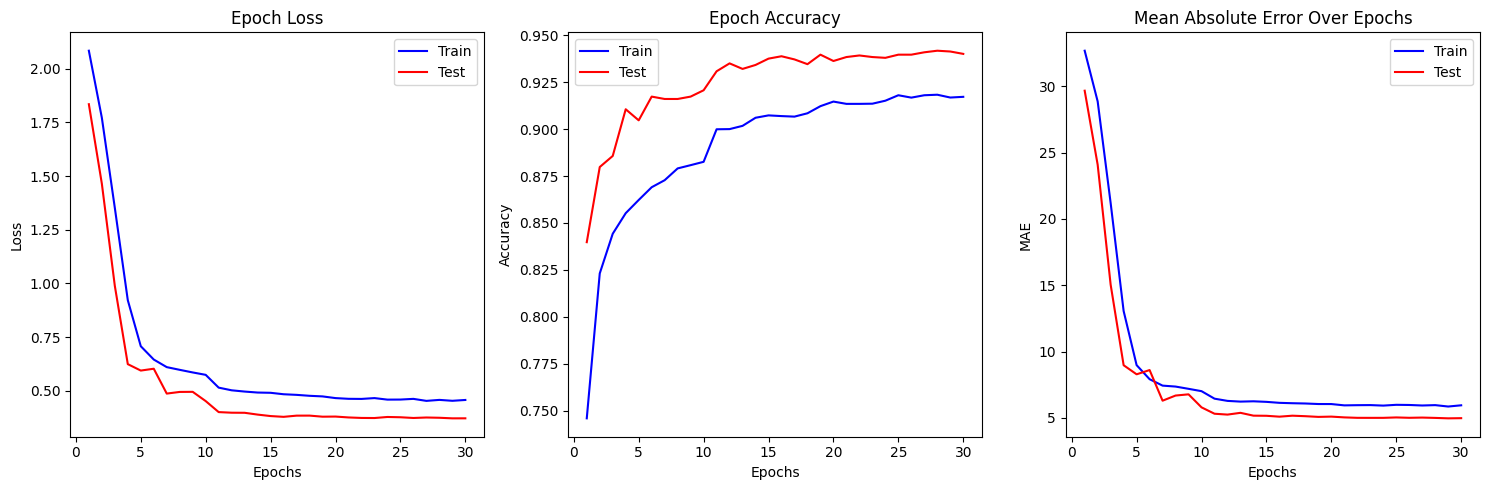

In [36]:
# Plotting epoch loss and accuracy
epochs = range(1, num_epochs + 1)

#Subplot for Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_values, 'b', label='Train')
plt.plot(epochs, test_loss_values, 'r', label='Test')
plt.title('Epoch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc_values, 'b', label='Train')
plt.plot(epochs, test_acc_values, 'r', label='Test')
plt.title('Epoch Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for MAE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_age_error_values, 'b', label='Train')
plt.plot(epochs, test_age_error_values, 'r', label='Test')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

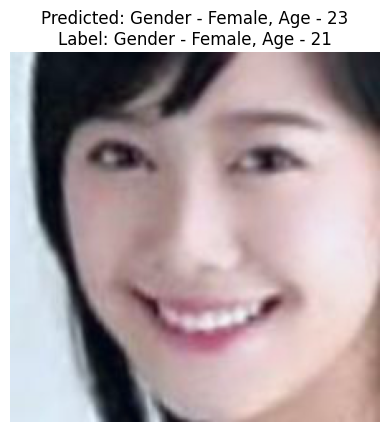

In [45]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Choose a random photo from the test dataset
sample_idx = 31  # Choose the index of the photo to display
sample_data = dataloaders['test'].dataset[sample_idx]
sample_image = sample_data[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
sample_gender_label = int(sample_data[1])  # Convert tensor to integer
sample_age_label = int(sample_data[2])  # Convert tensor to integer

# Make predictions on the sample image
with torch.no_grad():
    sample_gender_pred, sample_age_pred = model(sample_image)

# Convert gender prediction to string label
gender_labels = ['Male', 'Female']
sample_gender_pred_label = gender_labels[sample_gender_pred.argmax()]

# Convert age prediction to integer
sample_age_pred = int(sample_age_pred.item())

# Convert image tensor to NumPy array and transpose the dimensions
sample_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
# Display the photo with predictions and labels
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted: Gender - {sample_gender_pred_label}, Age - {sample_age_pred}\n'
          f'Label: Gender - {gender_labels[sample_gender_label]}, Age - {sample_age_label}')
plt.show()